## Importing libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 7.0)

import math
import numpy as np
#seed = 1337
seed = 42
np.random.seed(seed)
# THEANO_FLAGS="dnn.conv.algo_bwd_filter=deterministic, dnn.conv.algo_bwd_data=deterministic"

# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (10.0, 7.0)

#import numpy as np
#import matplotlib.pyplot as plt
import os
import pandas as pd
from collections import defaultdict
from Bio import SeqIO
from nltk import bigrams
from nltk import trigrams
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# import theano
# theano.config.device = 'gpu'
# theano.config.floatX = 'float32'
from keras.layers import Dropout
from keras.layers import Input, Dense, Lambda, LSTM, RepeatVector, Conv1D, MaxPooling1D, UpSampling1D
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
from keras import regularizers
from keras.layers import GaussianNoise
from keras.layers import Activation
from keras.callbacks import LearningRateScheduler, EarlyStopping

from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras import regularizers
from keras.regularizers import l2, activity_l2, l1, activity_l1
from keras.optimizers import Adam, SGD

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


import dask.dataframe as dd
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from scipy import interp
from itertools import cycle
from scipy import stats

Using TensorFlow backend.


In [6]:
import sys
nb_stdout = sys.stdout
sys.stdout = open('/dev/stdout', 'w')
print 'hello'

In [43]:
sys.stdout = nb_stdout

## Pre-processing

In [3]:
"""
Creating all the trigrams
"""
import itertools
all_tri_grams = []
for p in itertools.product("ARNDCEQGHILKMFPSTWYV", repeat=3):
    tok = p[0] + p[1] + p[2]
    all_tri_grams.append(tok)
    
print len(all_tri_grams)

In [4]:
"""
Writing a method to build tri-grams, as it is frequently needed
input: fasta_file
output: a csv type file of tri-gram values
"""


def build_tri_grams(input_file, output_file):
    tri_dic = defaultdict(int)

    out_handle = open(output_file, "w")
    for rec in SeqIO.parse(input_file, "fasta"):
        tok = rec.description.split("|")[-1]
        #print tok
        #print tok[0], tok[-1]
        #if tok == 'toxin':
        tri_tokens = trigrams(rec.seq)

        # tri_tokens is a generator - you can only go through it once
        for item in ((tri_tokens)):
            if '-' in item:
                continue
            tri_str = item[0] + item[1] + item[2]
            #print bi_str
            tri_dic[tri_str] += 1

        for index, item in enumerate(sorted(all_tri_grams)):
            if index > 0:
                out_handle.write(',')
            out_handle.write("%s" % tri_dic[item])
        out_handle.write("\n")
        tri_dic.update({}.fromkeys(tri_dic, 0)) # setting all key values to be zero again


    out_handle.close()

In [4]:
"""
Building trigrams for 'swissprot_bacteria_seqs.fa' file
"""

import os
#os.chdir('/home/nafizh/Context_gene_mining/operon_db_mining')

in_handle = open('swissprot_bacteria_seqs.fa','r')
build_tri_grams(in_handle, 'swissprot_bacteria_seqs.fa' + '_trigrams')

print "Done"

Done


In [3]:
 print sorted(all_tri_grams).index('MIF')

4144


In [5]:
# Loading negative bacteriocins into pandas dataframe
negative_bacteriocin_data = pd.read_csv("final_negative_bacteriocin_set.fa_trigrams", names=sorted(all_tri_grams))

# taking the values from panda into numpy array
negative_bacteriocin_array = negative_bacteriocin_data.values.astype(float)
print negative_bacteriocin_array.shape

In [6]:
# Loading the BAGEL bacteriocins into pandas dataframe
import pandas as pd
class_1_data = pd.read_csv("class_1_tri_grams", names=sorted(all_tri_grams))
print class_1_data.shape
class_2_data = pd.read_csv("class_2_tri_grams", names=sorted(all_tri_grams))
print class_2_data.shape

array1 = class_1_data.values.astype(float)
array2 = class_2_data.values.astype(float)
positive_bacteriocin_array = np.vstack((array1, array2))

print positive_bacteriocin_array.shape

In [7]:
whole_data_set_array = np.vstack((positive_bacteriocin_array.astype(float), 
                                  negative_bacteriocin_array.astype(float)))

print whole_data_set_array.shape
print whole_data_set_array

In [8]:
# Splitting data into training and test set 
y = np.vstack((np.ones((positive_bacteriocin_array.shape[0], 1)), 
               np.zeros((negative_bacteriocin_array.shape[0],1))))

whole_data_set_array, y = shuffle(whole_data_set_array, y, random_state = 0)

x_train, x_test, y_train, y_test = train_test_split(whole_data_set_array, y, test_size=0.3, random_state=42, 
                                                   stratify = y)

print y_train.shape
print y_test.shape

In [9]:
print x_train.shape
print x_test.shape
print y_train.shape
print y_test[y_test == 0].shape
print y_test.shape

In [24]:
build_tri_grams('whole_bacteriocin_set_without_fragments_length_more_than_21', 
                'whole_bacteriocin_set_without_fragments_length_more_than_21' + '_trigrams')

In [25]:
y_without_fragments = np.vstack((np.ones((245, 1)), 
                                 np.zeros((286,1))))


In [26]:
whole_bacteriocin_data_without_fragments = pd.read_csv("whole_bacteriocin_set_without_fragments_length_more_than_21_trigrams", 
                                        names=sorted(all_tri_grams))

# taking the values from panda into numpy array
whole_bacteriocin_data_without_fragments_array = whole_bacteriocin_data_without_fragments.values.astype(float)
print whole_bacteriocin_data_without_fragments_array.shape

cat temp_negative_bacteriocin_set temp_negative_bacteriocin_set_1 > final_negative_bacteriocin_set.fa
cat all_bagel_bacteriocins.fa final_negative_bacteriocin_set.fa > pos_neg_bacteriocin.fa

In [57]:
out_handle = open('less_than_30_pos_neg_bacteriocin.fa', 'w')
for record in SeqIO.parse('pos_neg_bacteriocin.fa', 'fasta'):
    if len(record.seq) <= 30:
        continue
    else:
        out_handle.write('>%s|%d\n%s\n' % (record.description, len(record.seq),record.seq))
out_handle.close()

In [60]:
count = 0
for record in SeqIO.parse('less_than_30_pos_neg_bacteriocin.fa', 'fasta'):
    tok = record.description.split("|")[0]
    if '.' in tok:
        #print tok
        count = count +1
        
print count

In [5]:
min_ = 10000000
for record in SeqIO.parse('all_genbank.faa', 'fasta'):
    if len(record.seq) < min_:
        min_ = len(record.seq)
        print min_
        print ">", record.seq

print min_

In [22]:
out_handle = open('temp_word_svm_wild_predictions_lacto_10_fold_0.95', 'w')
for record in SeqIO.parse('temp_word_svm_wild_predictions_lacto_10_fold_0.5', 'fasta'):
    tok = record.description.split("|")[-1]
    if float(tok) >= 0.95:
        out_handle.write('>%s\n%s\n' % (record.description,record.seq))
    
print "Done"

## Training a Deep Denoising autoencoder

In [48]:
from keras.layers import Input, Dense
from keras.models import Model

from keras import regularizers
from keras.regularizers import l2, activity_l2, l1, activity_l1
# this is the size of our encoded representations
autoencoder = None
encoding_dim = 128  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(8000,))
encoded = GaussianNoise(0.3)(input_img) #0.3
#encoded = Dropout(0.3)(encoded) #0.3
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(encoded)
#encoded = Dense(encoding_dim, activation='sigmoid', init = 'uniform', W_regularizer=l1(0.1))(input_img)

# "decoded" is the lossy reconstruction of the input
#encoded = Dropout(0.90)(encoded)
decoded = Dense(8000, activation = 'relu')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

# input_img = Input(shape=(6860,))
# encoded = Dense(128, activation='relu')(input_img)
# encoded = Dense(64, activation='relu')(encoded)
# encoded = Dense(32, activation='relu')(encoded)

# decoded = Dense(64, activation='relu')(encoded)
# decoded = Dense(128, activation='relu')(decoded)
# decoded = Dense(6860, activation='sigmoid')(decoded)

# autoencoder = Model(input=input_img, output=decoded)

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))


# # create a placeholder for an encoded (32-dimensional) input
# encoded_input_1 = Input(shape=(32,))
# encoded_input_2 = Input(shape=(64,))
# encoded_input_3 = Input(shape=(128,))
# # retrieve the last layer of the autoencoder model
# decoder_layer_1 = autoencoder.layers[-3]
# decoder_layer_2 = autoencoder.layers[-2]
# decoder_layer_3 = autoencoder.layers[-1]
# # create the decoder model
# decoder_1 = Model(input = encoded_input_1, output = decoder_layer_1(encoded_input_1))
# decoder_2 = Model(input = encoded_input_2, output = decoder_layer_2(encoded_input_2))
# decoder_3 = Model(input = encoded_input_3, output = decoder_layer_3(encoded_input_3))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [6]:
"""
Deep denoising autoencoder
"""

input_img = Input(shape=(8000,))
encoded = GaussianNoise(0.3)(input_img)
encoded = Dense(4096, activation='relu')(input_img)
encoded = Dense(1024, activation='relu')(encoded)
encoded = Dense(256, activation='relu')(encoded)

decoded = Dense(1024, activation='relu')(encoded)
decoded = Dense(4096, activation='relu')(decoded)
decoded = Dense(8000, activation='relu')(decoded)

autoencoder = Model(input=input_img, output=decoded)

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

# create a placeholder for an encoded (32-dimensional) input
#encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
#decoder_layer = autoencoder.layers[-1]
# create the decoder model
#decoder = Model(input = encoded_input, output=decoder_layer(encoded_input))


# # create a placeholder for an encoded (32-dimensional) input
# encoded_input_1 = Input(shape=(32,))
# encoded_input_2 = Input(shape=(64,))
# encoded_input_3 = Input(shape=(128,))
# # retrieve the last layer of the autoencoder model
# decoder_layer_1 = autoencoder.layers[-3]
# decoder_layer_2 = autoencoder.layers[-2]
# decoder_layer_3 = autoencoder.layers[-1]
# # create the decoder model
# decoder_1 = Model(input = encoded_input_1, output = decoder_layer_1(encoded_input_1))
# decoder_2 = Model(input = encoded_input_2, output = decoder_layer_2(encoded_input_2))
# decoder_3 = Model(input = encoded_input_3, output = decoder_layer_3(encoded_input_3))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [8]:
autoencoder.summary()

In [ ]:
filepath="weights-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True,
mode='min')
callbacks_list = [checkpoint]

In [11]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('weights.h5', monitor='loss', save_best_only=True, verbose=2)

In [9]:
def my_generator():
    # Create empty arrays to contain batch of features and labels#
    while True:
        un_training_data = pd.read_csv('swissprot_bacteria_seqs.fa_trigrams', names = sorted(all_tri_grams), 
                                       chunksize=128)
        for index_in_chunk, chunk in enumerate(un_training_data):
            # taking the values from panda into numpy array
            batch_features = chunk.values
            #print
            #print np.mean(batch_features)
            yield batch_features, batch_features
    

In [13]:
autoencoder.fit_generator(my_generator(), samples_per_epoch = 332926, nb_epoch=200, callbacks_list=[checkpoint])

KeyboardInterrupt: 

In [12]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print sess

In [35]:
un_training_data = pd.read_csv('all_curated_context_genes_trigrams', names = sorted(all_tri_grams))
value = un_training_data.values
print np.mean(value[256:384, :])
    

## Layerwise training for Stacked denoising autoencoder

In [23]:
from keras.layers import Input, Dense
from keras.models import Model

from keras import regularizers
from keras.regularizers import l2, activity_l2, l1, activity_l1
# this is the size of our encoded representations
autoencoder = None
encoding_dim = 4000  
# this is our input placeholder
input_img = Input(shape=(8000,))
encoded = GaussianNoise(0.3)(input_img) #0.3
encoded_4000 = Dense(encoding_dim, activation='relu')(encoded)
decoded_4000 = Dense(8000, activation = 'sigmoid')(encoded_4000)

# this model maps an input to its reconstruction
autoencoder_4000 = Model(input=input_img, output=decoded_4000)

encoder_4000 = Model(input=input_img, output=encoded_4000)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder_4000.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

autoencoder_4000.compile(optimizer='adam', loss='binary_crossentropy')

In [24]:
from keras.callbacks import ModelCheckpoint
filepath="weights-encoder-4000-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True,
mode='min')
callbacks_list = [checkpoint]

In [30]:
def my_generator():
    # Create empty arrays to contain batch of features and labels#
    while True:
        un_training_data = pd.read_csv('swissprot_bacteria_seqs.fa_trigrams', names = sorted(all_tri_grams), 
                                       chunksize=128)
        for index_in_chunk, chunk in enumerate(un_training_data):
            # taking the values from panda into numpy array
            batch_features = chunk.values
            #print
            #print np.mean(batch_features)
            yield batch_features, batch_features

In [ ]:
autoencoder_4000.fit_generator(my_generator(), samples_per_epoch = 332926, nb_epoch=200, callbacks = callbacks_list)

/home/nafizh/anaconda3/envs/py2/lib/python2.7/site-packages/Keras-1.2.2-py2.7.egg/keras/callbacks.py:119: UserWarning: Method on_batch_end() is slow compared to the batch update (0.547323). Check your callbacks.
  % delta_t_median)
/home/nafizh/anaconda3/envs/py2/lib/python2.7/site-packages/Keras-1.2.2-py2.7.egg/keras/callbacks.py:119: UserWarning: Method on_batch_end() is slow compared to the batch update (0.445693). Check your callbacks.
  % delta_t_median)
/home/nafizh/anaconda3/envs/py2/lib/python2.7/site-packages/Keras-1.2.2-py2.7.egg/keras/callbacks.py:119: UserWarning: Method on_batch_end() is slow compared to the batch update (0.420362). Check your callbacks.
  % delta_t_median)
/home/nafizh/anaconda3/envs/py2/lib/python2.7/site-packages/Keras-1.2.2-py2.7.egg/keras/callbacks.py:119: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147495). Check your callbacks.
  % delta_t_median)


## Layerwise training for Stacked denoising autoencoder - 0.5 Gaussian noise

### 8000 -> 4000

In [4]:
from keras.layers import Input, Dense
from keras.models import Model

from keras import regularizers
from keras.regularizers import l2, activity_l2, l1, activity_l1
# this is the size of our encoded representations
autoencoder = None
encoding_dim = 4000  
# this is our input placeholder
input_img = Input(shape=(8000,))
encoded = GaussianNoise(0.7)(input_img) #0.3
encoded_4000 = Dense(encoding_dim, activation='relu')(encoded)
decoded_4000 = Dense(8000, activation = 'sigmoid')(encoded_4000)

# this model maps an input to its reconstruction
autoencoder_4000 = Model(input=input_img, output=decoded_4000)

encoder_4000 = Model(input=input_img, output=encoded_4000)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder_4000.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

autoencoder_4000.compile(optimizer='adam', loss='binary_crossentropy')

In [5]:
from keras.callbacks import ModelCheckpoint
filepath="weights-encoder-4000-0.7GN-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True,
mode='min')
callbacks_list = [checkpoint]

In [6]:
def my_generator():
    # Create empty arrays to contain batch of features and labels#
    while True:
        un_training_data = pd.read_csv('swissprot_bacteria_seqs.fa_trigrams', names = sorted(all_tri_grams), 
                                       chunksize=128)
        for index_in_chunk, chunk in enumerate(un_training_data):
            # taking the values from panda into numpy array
            batch_features = chunk.values.astype(float)
            #print
            #print np.mean(batch_features)
            yield batch_features, batch_features

In [7]:
autoencoder_4000.fit_generator(my_generator(), samples_per_epoch = 332926, nb_epoch=200, 
                               callbacks = callbacks_list)

KeyboardInterrupt: 

In [8]:
autoencoder_4000.load_weights('weights-encoder-4000-0.7GN-74-0.1164.hdf5')

In [9]:
un_training_data_small = pd.read_csv('swissprot_bacteria_seqs.fa_trigrams_small', names = sorted(all_tri_grams))
un_training_data_val_small = un_training_data_small.values.astype(float)

In [10]:
encoded_imgs = encoder_4000.predict(un_training_data_val_small[0:5000, :])
print encoded_imgs.shape

TypeError: You must first set_array for mappable

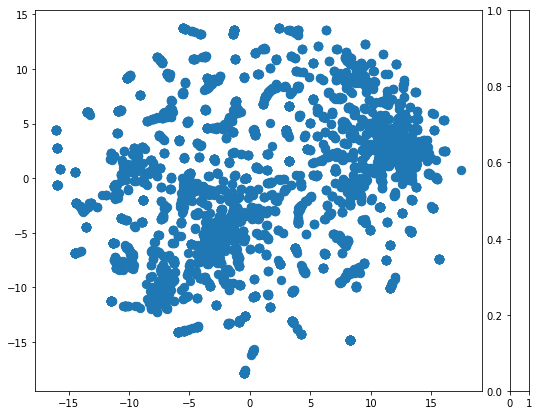

In [68]:
X_embedded_a = TSNE(n_components=2, verbose=2).fit_transform(encoded_imgs)

#X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(encoded_imgs)
vis_x_a = X_embedded_a[:, 0]
vis_y_a = X_embedded_a[:, 1]

plt.scatter(vis_x_a, vis_y_a, s = 70)
#plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=y_train_val_a, cmap = plt.cm.get_cmap("brg", 3), s = 70)
#plt.scatter(vis_x, vis_y, s = 70)
#plt.colorbar()
plt.show()

### 8000 -> 4000 with BN

In [168]:
from keras.layers import Input, Dense
from keras.models import Model


# this is the size of our encoded representations
autoencoder_4000_bn = None
encoding_dim_4000 = 64 
# this is our input placeholder
input_img_4000 = Input(shape=(100,))
#encoded_4000_bn = Dropout(0.1)(input_img_4000)
#encoded_4000_bn = GaussianNoise(0.1)(input_img_4000) #0.3
encoded_4000_bn = Dense(encoding_dim_4000, activity_regularizer=activity_l1(10e-5))(input_img_4000)
encoded_4000_bn = BatchNormalization()(encoded_4000_bn)
encoded_4000_bn = Activation('relu')(encoded_4000_bn)
#encoded_4000_bn = Dropout(0.7)(encoded_4000_bn)
#encoded_4000_bn = Dropout(0.5)(encoded_4000_bn)
decoded_4000_bn = Dense(100, activation = 'linear')(encoded_4000_bn)

# this model maps an input to its reconstruction
autoencoder_4000_bn = Model(input = input_img_4000, output = decoded_4000_bn)

encoder_4000_bn = Model(input = input_img_4000, output = encoded_4000_bn)

# create a placeholder for an encoded (32-dimensional) input
encoded_input_4000_bn = Input(shape=(encoding_dim_4000,))
# retrieve the last layer of the autoencoder model
decoder_layer_4000_bn = autoencoder_4000_bn.layers[-1]
# create the decoder model
decoder_4000_bn = Model(input = encoded_input_4000_bn, output = decoder_layer_4000_bn(encoded_input_4000_bn))

In [173]:
sgd = SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=True)

In [169]:
autoencoder_4000_bn.compile(optimizer= Adam(), loss='mse')

In [177]:
autoencoder_4000_bn.compile(optimizer= Adam(lr = 0.0000001), loss='mse')

In [178]:
import time
tic = time.time()

hist = autoencoder_4000_bn.fit(d_df_array_scaled, d_df_array_scaled,
                nb_epoch= 30,
                batch_size= 128,
                shuffle=True,
                verbose = True
                )
toc = time.time()
print "computed in %fs" % (toc - tic)

KeyboardInterrupt: 

In [23]:
from keras.callbacks import ModelCheckpoint
filepath="weights-encoder-vector-64-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True,
mode='min')
#callbacks_list_check = [checkpoint]

In [34]:
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 2.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

# learning schedule callback
lrate = LearningRateScheduler(step_decay)
#callbacks_list_rate = [lrate]
sgd = SGD(lr=0.0, momentum=0.9, decay=0.0, nesterov=True)

In [31]:
def my_generator():
    # Create empty arrays to contain batch of features and labels#
    while True:
        un_training_data = pd.read_csv('swissprot_bacteria_seqs.fa_trigrams', names = sorted(all_tri_grams), 
                                       chunksize=128)
        for index_in_chunk, chunk in enumerate(un_training_data):
            # taking the values from panda into numpy array
            batch_features = chunk.values.astype(float)
            #print
            #print np.mean(batch_features)
            yield batch_features, batch_features

In [33]:
autoencoder_4000_bn.fit_generator(my_generator(), samples_per_epoch = 332926, nb_epoch=10,
                                 callbacks = [checkpoint])

In [37]:
autoencoder_4000_bn.load_weights('weights-encoder-vector-64-04-0.1571.hdf5')

In [227]:
d_df_array_scaled[32450,]

array([-1.00745872, -0.16081776, -0.53663901, -1.3098651 , -1.10348439,
        0.08375907,  0.16292083,  0.14219703,  0.02525381,  0.23652834,
       -1.52671315, -0.84163833, -0.98607156, -0.66178216,  1.50282105,
       -2.93915059, -1.59658425,  1.50248694,  1.70151541, -0.17410567,
       -1.2260459 , -0.64638715, -0.3205027 ,  1.82592032, -1.48878019,
       -1.85131182,  0.88428   ,  0.77274375, -0.14382613, -0.48387537,
        2.45311585, -0.14628304,  1.73595561, -1.3462524 ,  0.46273771,
        0.36345273, -3.56054935, -0.22781957,  1.70100386, -0.95220021,
        0.72439204,  0.4520879 ,  0.29514311,  0.03159478, -1.30476779,
        2.06758168, -1.75728092,  0.30716271, -0.18761701, -0.46093651,
       -1.98128943, -0.40045562, -0.26969771, -1.64317804, -0.58320296,
       -0.85486468, -2.91373864, -0.11332318, -0.60193377,  0.28812571,
       -0.4853936 ,  0.85263469, -1.33604317,  1.37013989,  0.16861693,
        1.37462656,  0.25497453,  0.53970503,  0.85338106,  0.01

In [220]:
x_word_scaled_minmax[0,]

array([ 0.79375068,  0.50510891,  0.60449027,  0.88350374,  0.72113229,
        0.64024501,  0.50670051,  0.53501554,  0.62592394,  0.27676565,
        0.57648964,  0.84348893,  0.49997839,  0.45290757,  0.6351949 ,
        0.46944411,  0.567314  ,  0.68402444,  0.49959474,  0.49831834,
        0.4543543 ,  0.75374319,  0.65382606,  0.33527162,  0.39419876,
        0.5965284 ,  0.37006411,  0.14385051,  0.42816798,  0.63470556,
        0.51132458,  0.49761004,  0.20511399,  0.62164491,  0.27638447,
        0.4285216 ,  0.6504995 ,  0.33223378,  0.29413531,  0.40491581,
        0.40887235,  0.44621131,  0.40210185,  0.57094836,  0.65090658,
        0.44313936,  0.67403097,  0.3819492 ,  0.63383587,  0.23550784,
        0.45778219,  0.44245743,  0.32068205,  0.66503296,  0.40665677,
        0.74522047,  0.67279526,  0.40163693,  0.19133986,  0.54026561,
        0.46927019,  0.19800955,  0.50515113,  0.28575793,  0.36560562,
        0.53676231,  0.71966015,  0.2774817 ,  0.36208164,  0.59

### 4000 -> 1000 BN

In [181]:
from keras.layers import Input, Dense
from keras.models import Model


# this is the size of our encoded representations
autoencoder_1000_bn = None
encoding_dim_1000 = 32  
# this is our input placeholder
input_img_1000 = Input(shape=(64,))
#encoded_1000_bn = GaussianNoise(0.3)(input_img_1000) #0.3
encoded_1000_bn = Dense(encoding_dim_1000, activity_regularizer=activity_l1(10e-5))(input_img_1000)
encoded_1000_bn = BatchNormalization()(encoded_1000_bn)
encoded_1000_bn = Activation('relu')(encoded_1000_bn)
#encoded_1000_bn = Dropout(0.3)(encoded_1000_bn)
decoded_1000_bn = Dense(64, activation = 'linear')(encoded_1000_bn)

# this model maps an input to its reconstruction
autoencoder_1000_bn = Model(input = input_img_1000, output = decoded_1000_bn)

encoder_1000_bn = Model(input = input_img_1000, output = encoded_1000_bn)

# create a placeholder for an encoded (32-dimensional) input
encoded_input_1000_bn = Input(shape=(encoding_dim_1000,))
# retrieve the last layer of the autoencoder model
decoder_layer_1000_bn = autoencoder_1000_bn.layers[-1]
# create the decoder model
decoder_1000_bn = Model(input = encoded_input_1000_bn, output = decoder_layer_1000_bn(encoded_input_1000_bn))

In [182]:
autoencoder_1000_bn.compile(optimizer= Adam(), loss='mse')

In [192]:
autoencoder_1000_bn.compile(optimizer= Adam(lr = 0.0000001), loss='mse')

In [47]:
from keras.callbacks import ModelCheckpoint
filepath="weights-encoder-vector-32-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True,
mode='min')
#callbacks_list = [checkpoint]

In [ ]:
def my_1000_generator():
    # Create empty arrays to contain batch of features and labels#
    while True:
        un_training_data = pd.read_csv('swissprot_bacteria_seqs.fa_trigrams', names = sorted(all_tri_grams), 
                                       chunksize=128)
        for index_in_chunk, chunk in enumerate(un_training_data):
            # taking the values from panda into numpy array
            batch_features = chunk.values.astype(float)
            # Encoding to a 4000 size representation by the already trained autoencoder
            four_thousand_rep = encoder_4000_bn.predict(batch_features)
            #print four_thousand_rep
            yield four_thousand_rep, four_thousand_rep

In [183]:
make_for_1000 = encoder_4000_bn.predict(d_df_array_scaled)

In [58]:
autoencoder_1000_bn.load_weights('weights-encoder-vector-32-04-0.0362.hdf5')

In [193]:
import time
tic = time.time()

hist = autoencoder_1000_bn.fit(make_for_1000, make_for_1000,
                nb_epoch= 10,
                batch_size= 128,
                shuffle=True,
               verbose = True,
                )
toc = time.time()
print "computed in %fs" % (toc - tic)

KeyboardInterrupt: 

In [14]:
un_training_data_small = pd.read_csv('swissprot_bacteria_seqs.fa_trigrams_small', names = sorted(all_tri_grams))
un_training_data_val_small = un_training_data_small.values.astype(float)

In [15]:
encoded_imgs = encoder_4000_bn.predict(un_training_data_val_small[0:5000, :])
print encoded_imgs.shape

In [48]:
print encoded_imgs

In [46]:
print un_training_data_val_small.shape

### 1000 -> 50 BN

In [196]:
from keras.layers import Input, Dense
from keras.models import Model


# this is the size of our encoded representations
autoencoder_50_bn = None
encoding_dim_50 = 16 
# this is our input placeholder
input_img_50 = Input(shape=(32,))
#encoded_50_bn = GaussianNoise(0.3)(input_img_50) #0.3
encoded_50_bn = Dense(encoding_dim_50, activity_regularizer=activity_l1(10e-5))(input_img_50)
encoded_50_bn = BatchNormalization()(encoded_50_bn)
encoded_50_bn = Activation('relu')(encoded_50_bn)
#encoded_50_bn = Dropout(0.3)(encoded_50_bn)
decoded_50_bn = Dense(32, activation = 'linear')(encoded_50_bn)

# this model maps an input to its reconstruction
autoencoder_50_bn = Model(input = input_img_50, output = decoded_50_bn)

encoder_50_bn = Model(input = input_img_50, output = encoded_50_bn)

# create a placeholder for an encoded (32-dimensional) input
encoded_input_50_bn = Input(shape=(encoding_dim_50,))
# retrieve the last layer of the autoencoder model
decoder_layer_50_bn = autoencoder_50_bn.layers[-1]
# create the decoder model
decoder_50_bn = Model(input = encoded_input_50_bn, output = decoder_layer_50_bn(encoded_input_50_bn))

In [197]:
autoencoder_50_bn.compile(optimizer= Adam(), loss='mse')

In [205]:
autoencoder_50_bn.compile(optimizer= Adam(lr = 0.000001), loss='mse')

In [62]:
from keras.callbacks import ModelCheckpoint
filepath="weights-encoder-vector-16-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True,
mode='min')
#callbacks_list = [checkpoint]

In [76]:
def my_50_generator():
    # Create empty arrays to contain batch of features and labels#
    while True:
        un_training_data = pd.read_csv('swissprot_bacteria_seqs.fa_trigrams', names = sorted(all_tri_grams), 
                                       chunksize=128)
        for index_in_chunk, chunk in enumerate(un_training_data):
            # taking the values from panda into numpy array
            batch_features = chunk.values.astype(float)
            # Encoding to a 4000 size representation by the already trained autoencoder
            four_thousand_rep = encoder_4000_bn.predict(batch_features)
            one_thousand_rep = encoder_1000_bn.predict(four_thousand_rep)
            #print four_thousand_rep
            yield one_thousand_rep, one_thousand_rep

In [198]:
make_for_50 = encoder_1000_bn.predict(make_for_1000)

In [206]:
import time
tic = time.time()

hist = autoencoder_50_bn.fit(make_for_50, make_for_50,
                nb_epoch= 5,
                batch_size= 128,
                shuffle=True,
               verbose = True)
#                callbacks = [checkpoint])
toc = time.time()
print "computed in %fs" % (toc - tic)

In [79]:
encoded_imgs = encoder_4000_bn.predict(un_training_data_val_small[0:5000, :])
encoded_imgs = encoder_1000_bn.predict(encoded_imgs[0:5000, :])
print encoded_imgs.shape

In [78]:
autoencoder_50_bn.load_weights('weights-encoder-vector-16-04-0.0206.hdf5')

## T-SNE

In [4]:
"""
100 -> 100 -> 100
Just 1 layer -> xgboost -> 0.816162645543
2 layer -> xgboost -> 0.769037942978
3 layer -> xgboost -> 0.679376362572

"""


#encoded_imgs = encoder_4000_bn.predict(x_word_scaled)
#encoded_imgs = encoder_1000_bn.predict(encoded_imgs)
#encoded_imgs = encoder_50_bn.predict(encoded_imgs)
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(temp_word_scaled)

#X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(encoded_imgs)
vis_x = X_embedded[:, 0]
vis_y = X_embedded[:, 1]

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 692 / 692
[t-SNE] Mean sigma: 3.760227
[t-SNE] Iteration 25: error = 1.2084047, gradient norm = 0.0191380
[t-SNE] Iteration 50: error = 1.2205156, gradient norm = 0.0185297
[t-SNE] Iteration 75: error = 0.9318930, gradient norm = 0.0126172
[t-SNE] Iteration 100: error = 0.9581714, gradient norm = 0.0129357
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.958171
[t-SNE] Iteration 125: error = 0.8598639, gradient norm = 0.0096229
[t-SNE] Iteration 150: error = 0.9043701, gradient norm = 0.0097090
[t-SNE] Iteration 175: error = 0.9010624, gradient norm = 0.0096033
[t-SNE] Iteration 175: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 175 iterations: 0.958171


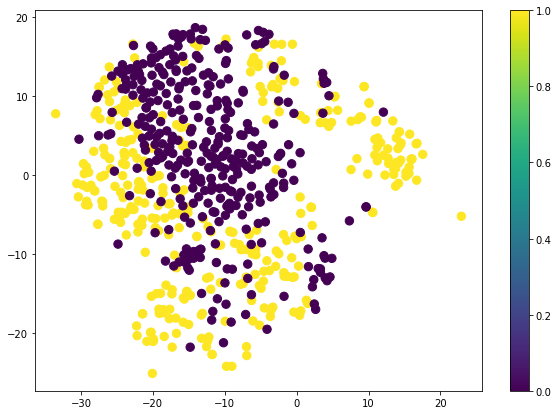

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(vis_x, vis_y, c = y_temp_word, s = 70)
# for index, xy in enumerate(zip(vis_x, vis_y)):
#     if index >= 389:# <--
#         ax.annotate('%s' % index, xy=xy, textcoords='data') # <--
plt.colorbar()
plt.show()

In [55]:
for index, record in enumerate(SeqIO.parse('pos_neg_bacteriocin.fa', 'fasta')):
    if index == 416:
        print record.description
        print record.seq
        break

In [5]:
# encoded_imgs = encoder_4000_bn.predict(fragment_x_word_scaled_d)
# encoded_imgs = encoder_1000_bn.predict(encoded_imgs)
# encoded_imgs = encoder_50_bn.predict(encoded_imgs)
X_embedded = TSNE(n_components=2, perplexity=30, verbose=2).fit_transform(context_word_scaled)

#X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(encoded_imgs)
vis_x = X_embedded[:, 0]
vis_y = X_embedded[:, 1]

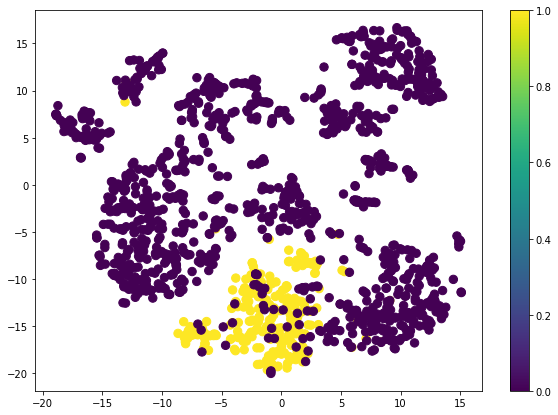

In [6]:
plt.scatter(vis_x, vis_y, c = y_context_word, s = 70)
plt.colorbar()
plt.show()

In [92]:
"""
Encoding the training and test data with the prepared autoencoder
"""

x_true_test_compressed = encoder_4000_bn.predict(x_test, batch_size = 100)
x_true_test_compressed = encoder_1000_bn.predict(x_true_test_compressed, batch_size = 100)
x_true_test_compressed = encoder_50_bn.predict(x_true_test_compressed, batch_size = 100)
print x_true_test_compressed.shape

x_train_whole_compressed = encoder_4000_bn.predict(x_train, batch_size = 100)
x_train_whole_compressed = encoder_1000_bn.predict(x_train_whole_compressed, batch_size = 100)
x_train_whole_compressed = encoder_50_bn.predict(x_train_whole_compressed, batch_size = 100)
print x_train_whole_compressed.shape

## Antibp2 data

In [19]:
pos_antibp_data = pd.read_csv("pos_antibp2.fa_trigrams", names=sorted(all_tri_grams))
pos_antibp_array = pos_antibp_data.values.astype(float)
print pos_antibp_array.shape

In [20]:
neg_antibp_data = pd.read_csv("neg_antibp2.fa_trigrams", names=sorted(all_tri_grams))
neg_antibp_array = neg_antibp_data.values.astype(float)
print neg_antibp_array.shape

In [21]:
anti_data_set_array = np.vstack((pos_antibp_array.astype(float), 
                                  neg_antibp_array.astype(float)))

In [22]:
y_antibp = np.vstack((np.ones((999, 1)), 
                      np.zeros((999,1))))

## Ensemble

Measure performance only with nested cv. Finally get best parameters with k-fold cv, but do not take its preformance measure as you are already using it for hyperparameter tuning.

In [17]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

clf1 = LogisticRegression(C = 1.0, penalty = 'l1', random_state = 1)
clf2 = SVC(gamma = 0.01, C = 1.0, kernel = 'rbf', random_state = 1, probability = True)
#clf3 = DecisionTreeClassifier(criterion= 'gini', max_depth= 9, random_state = 1)

eclf1 = VotingClassifier(estimators=[('lr', clf1), ('svm', clf2)], voting='soft')
cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=42)
f1_scores = cross_val_score(eclf1, temp_word_scaled, y_temp_word, cv = cv, scoring = 'f1')

print 'F1:', f1_scores
print f1_scores.mean()

F1: [ 0.80597015  0.87323944  0.86956522  0.91176471  0.91666667  0.77777778
  0.83076923  0.87878788  0.89230769  0.90410959]
0.86609583445


In [1]:
print 'hello'

hello


## SVM

In [10]:
"""
model is trembl
5-fold
0.866623367518
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}

10-fold
0.863151787706
{'clf__gamma': 0.01, 'clf__C': 1.0, 'clf__kernel': 'rbf'}
"""
pipe_svc = Pipeline([('clf', SVC(random_state=1))])
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'clf__C': param_range, 'clf__kernel': ['linear']}, {'clf__C': param_range, 
             'clf__gamma': param_range, 'clf__kernel': ['rbf']}]

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=42)
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='f1', cv= cv)
gs = gs.fit(temp_word_scaled, y_temp_word)

print(gs.best_score_)
print(gs.best_params_)

0.866623367518
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}


In [24]:
"""
K-fold cross validation
"""
logis = SVC(gamma = 0.01, C = 10.0, kernel = 'rbf', random_state = 1)
cv = StratifiedKFold(np.reshape(y_temp_word, (y_temp_word.shape[0], )), n_folds= 5, shuffle=True, random_state=42)
f1_scores = cross_val_score(logis, temp_word_scaled, y_temp_word, cv=cv, scoring = 'f1')
recall_scores = cross_val_score(logis, temp_word_scaled, y_temp_word, cv=cv, scoring = 'recall')
precision_scores = cross_val_score(logis, temp_word_scaled, y_temp_word, cv=cv, scoring = 'precision')

print 'F1:', f1_scores
print 'Recall:', recall_scores
print 'Precision:', precision_scores
print f1_scores.mean()
print recall_scores.mean()
print precision_scores.mean()

In [93]:
"""
Nested Cross-validation

CV f1: 0.842 (+/- 0.076)
"""

pipe_svc = Pipeline([('clf', SVC(random_state=1))])
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'clf__C': param_range, 'clf__kernel': ['linear']}, {'clf__C': param_range, 
             'clf__gamma': param_range, 'clf__kernel': ['rbf']}]
c, r = y_temp_word.shape
labels = y_temp_word.reshape(c,)
cv_inner = StratifiedKFold(n_splits= 5, shuffle=True, random_state=42)
cv_outer = StratifiedKFold(n_splits= 10, shuffle=True, random_state=43)
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='f1', cv= cv_inner)
scores = cross_val_score(gs, temp_word_scaled, labels, cv=cv_outer, scoring = 'f1')

#print(gs.best_score_)
#print(gs.best_params_)
print('CV f1: %.3f (+/- %.3f)' % (np.mean(scores), np.std(scores))) 

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.911764705882
Recall: 0.885714285714
F1: 0.898550724638
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.896551724138
Recall: 0.742857142857
F1: 0.8125
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.871794871795
Recall: 0.971428571429
F1: 0.918918918919
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.864864864865
Recall: 0.914285714286
F1: 0.888888888889
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.885714285714
Recall: 0.885714285714
F1: 0.885714285714
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.871794871795
Recall: 0.971428571429
F1: 0.918918918919
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.8
Recall: 0.705882352941
F1: 0.75
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.810810810811
Recall: 0.882352941176
F1: 0.845070422535
{'clf__gamma': 0.01, 

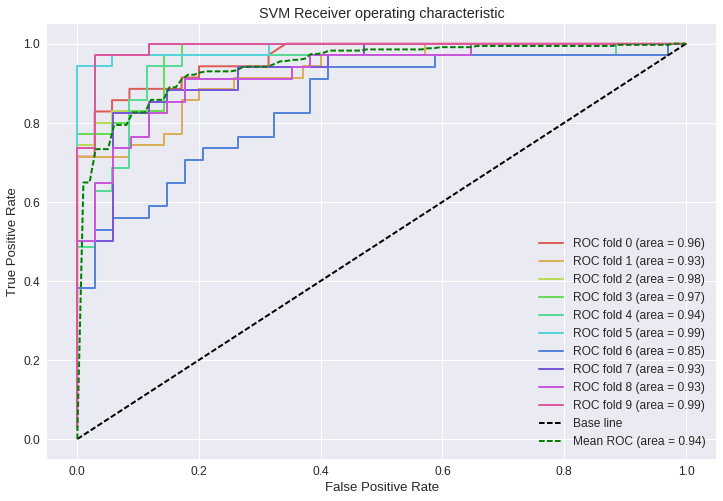

In [47]:
"""
Manual nested cross validation and ROC curve from that

10-fold-------------------------------------------
{'clf__gamma': 0.01, 'clf__C': 1.0, 'clf__kernel': 'rbf'}
Precision 0.9375
Recall: 0.857142857143
F1: 0.89552238806
[I 12:09:35.219 NotebookApp] Saving file at /ML_works/Unsupervised_feature_learning.ipynb
[W 12:09:35.224 NotebookApp] Saving untrusted notebook ML_works/Unsupervised_feature_learning.ipynb
{'clf__gamma': 0.01, 'clf__C': 1.0, 'clf__kernel': 'rbf'}
Precision 0.8125
Recall: 0.742857142857
F1: 0.776119402985
{'clf__gamma': 0.01, 'clf__C': 100.0, 'clf__kernel': 'rbf'}
Precision 0.825
Recall: 0.942857142857
F1: 0.88
{'clf__gamma': 0.01, 'clf__C': 1.0, 'clf__kernel': 'rbf'}
Precision 0.842105263158
Recall: 0.914285714286
F1: 0.876712328767
{'clf__gamma': 0.01, 'clf__C': 1.0, 'clf__kernel': 'rbf'}
Precision 0.911764705882
Recall: 0.885714285714
F1: 0.898550724638
{'clf__gamma': 0.001, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.868421052632
Recall: 0.942857142857
F1: 0.904109589041
{'clf__gamma': 0.01, 'clf__C': 1.0, 'clf__kernel': 'rbf'}
Precision 0.7
Recall: 0.617647058824
F1: 0.65625
{'clf__gamma': 0.01, 'clf__C': 100.0, 'clf__kernel': 'rbf'}
Precision 0.763157894737
Recall: 0.852941176471
F1: 0.805555555556
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.84375
Recall: 0.794117647059
F1: 0.818181818182
{'clf__gamma': 0.01, 'clf__C': 1.0, 'clf__kernel': 'rbf'}
Precision 0.9375
Recall: 0.882352941176
F1: 0.909090909091
0.844169891641 0.0716247185365
0.843277310924 0.0958633495924
0.842009271632 0.0760323519313


5-fold-----------------------------------------
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.869565217391
Recall: 0.857142857143
F1: 0.863309352518
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.8125
Recall: 0.942028985507
F1: 0.872483221477
{'clf__gamma': 0.01, 'clf__C': 1.0, 'clf__kernel': 'rbf'}
Precision 0.853333333333
Recall: 0.927536231884
F1: 0.888888888889
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.797101449275
Recall: 0.797101449275
F1: 0.797101449275
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.888888888889
Recall: 0.811594202899
F1: 0.848484848485
0.844277777778 0.0344878009002
0.867080745342 0.0589011450637
0.854053552129 0.0313476497365


10 fold on extra second negative proper distribution-------------------
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.861111111111
Recall: 0.885714285714
F1: 0.87323943662
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.909090909091
Recall: 0.857142857143
F1: 0.882352941176
{'clf__gamma': 0.01, 'clf__C': 100.0, 'clf__kernel': 'rbf'}
Precision 1.0
Recall: 0.971428571429
F1: 0.985507246377
{'clf__gamma': 0.01, 'clf__C': 1.0, 'clf__kernel': 'rbf'}
Precision 0.942857142857
Recall: 0.942857142857
F1: 0.942857142857
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.842105263158
Recall: 0.914285714286
F1: 0.876712328767
{'clf__gamma': 0.01, 'clf__C': 1.0, 'clf__kernel': 'rbf'}
Precision 0.894736842105
Recall: 0.971428571429
F1: 0.931506849315
{'clf__gamma': 0.01, 'clf__C': 1.0, 'clf__kernel': 'rbf'}
Precision 0.961538461538
Recall: 0.735294117647
F1: 0.833333333333
{'clf__gamma': 0.01, 'clf__C': 1.0, 'clf__kernel': 'rbf'}
Precision 0.969696969697
Recall: 0.941176470588
F1: 0.955223880597
{'clf__gamma': 0.01, 'clf__C': 1.0, 'clf__kernel': 'rbf'}
Precision 0.866666666667
Recall: 0.764705882353
F1: 0.8125
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.914285714286
Recall: 0.941176470588
F1: 0.927536231884
0.916208908051 0.0491363225742
0.892521008403 0.0790884887607
0.902076939093 0.052513090024


10 fold on extra third negative proper distribution-------------------
{'clf__gamma': 0.01, 'clf__C': 1.0, 'clf__kernel': 'rbf'}
Precision 0.971428571429
Recall: 0.971428571429
F1: 0.971428571429
[I 15:36:04.762 NotebookApp] Saving file at /ML_works/Unsupervised_feature_learning.ipynb
[W 15:36:04.764 NotebookApp] Saving untrusted notebook ML_works/Unsupervised_feature_learning.ipynb
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.909090909091
Recall: 0.857142857143
F1: 0.882352941176
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.971428571429
Recall: 0.971428571429
F1: 0.971428571429
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 1.0
Recall: 0.942857142857
F1: 0.970588235294
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.914285714286
Recall: 0.914285714286
F1: 0.914285714286
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.971428571429
Recall: 0.971428571429
F1: 0.971428571429
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.933333333333
Recall: 0.823529411765
F1: 0.875
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.942857142857
Recall: 0.970588235294
F1: 0.95652173913
{'clf__gamma': 0.01, 'clf__C': 1.0, 'clf__kernel': 'rbf'}
Precision 0.966666666667
Recall: 0.852941176471
F1: 0.90625
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.971428571429
Recall: 1.0
F1: 0.985507246377
0.955194805195 0.027608901772
0.92756302521 0.0588484941023
0.940479159055 0.0394828535291

--negative anti-bp data - 10 fold
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.970588235294
Recall: 0.942857142857
F1: 0.95652173913
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.967741935484
Recall: 0.857142857143
F1: 0.909090909091
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 1.0
Recall: 0.885714285714
F1: 0.939393939394
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.942857142857
Recall: 0.942857142857
F1: 0.942857142857
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.944444444444
Recall: 0.971428571429
F1: 0.957746478873
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.8
Recall: 0.914285714286
F1: 0.853333333333
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.970588235294
Recall: 0.970588235294
F1: 0.970588235294
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.914285714286
Recall: 0.941176470588
F1: 0.927536231884
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.944444444444
Recall: 1.0
F1: 0.971428571429
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 1.0
Recall: 0.882352941176
F1: 0.9375
0.94549501521 0.0546331742328
0.930840336134 0.0430101897363
0.936599658129 0.0332148859258

"""

# ROC curve stuff
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
# colors = cycle(['cyan', 'crimson', 'seagreen', 'yellow', 'blue', 'darkorange', 'darkviolet', 'fuchsia',
#                'deepskyblue', 'lightcoral'])
lw = 2
i = 0

sns.set(font_scale = 1.2)
colors = sns.hls_palette(10)
fig, ax = plt.subplots()
fig.set_size_inches(12.0, 8.0)

# Dividing data set for outer cv
cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 43)

precision_scores = []
recall_scores = []
f1_scores = []


# Outer cv
for (train, test), color in zip(cv_outer.split(temp_word_scaled, y_temp_word), colors):
    pipe_svc = Pipeline([('clf', SVC(random_state=1, probability = True))])
    param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
    param_grid = [{'clf__C': param_range, 'clf__kernel': ['linear']}, {'clf__C': param_range, 
             'clf__gamma': param_range, 'clf__kernel': ['rbf']}]

    
    #Inner cv
    cv_inner = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='f1', cv= cv_inner)
    
    gs.fit(temp_word_scaled[train], y_temp_word[train])
    
    print gs.best_params_
    
    scores = gs.best_estimator_.predict(temp_word_scaled[test])
    precision_s = precision_score(y_temp_word[test], scores)
    recall_s = recall_score(y_temp_word[test], scores)
    f1_s = f1_score(y_temp_word[test], scores)
    #print scores
    
    precision_scores.append(precision_s)
    recall_scores.append(recall_s)
    f1_scores.append(f1_s)
    print "Precision", precision_s
    print "Recall:", recall_s
    print "F1:", f1_s
    
    probas_ = gs.best_estimator_.predict_proba(temp_word_scaled[test])
    fpr, tpr, thresholds = roc_curve(y_temp_word[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i += 1
    #break
    
print np.mean(precision_scores), np.std(precision_scores) 
print np.mean(recall_scores), np.std(recall_scores)
print np.mean(f1_scores), np.std(f1_scores)

# Draw ROC curves
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Base line')

mean_tpr /= cv_outer.get_n_splits(temp_word_scaled, y_temp_word)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.911764705882
Recall: 0.885714285714
F1: 0.898550724638
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.896551724138
Recall: 0.742857142857
F1: 0.8125
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.871794871795
Recall: 0.971428571429
F1: 0.918918918919
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.864864864865
Recall: 0.914285714286
F1: 0.888888888889
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.885714285714
Recall: 0.885714285714
F1: 0.885714285714
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.871794871795
Recall: 0.971428571429
F1: 0.918918918919
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.8
Recall: 0.705882352941
F1: 0.75
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.810810810811
Recall: 0.882352941176
F1: 0.845070422535
{'clf__gamma': 0.01, 

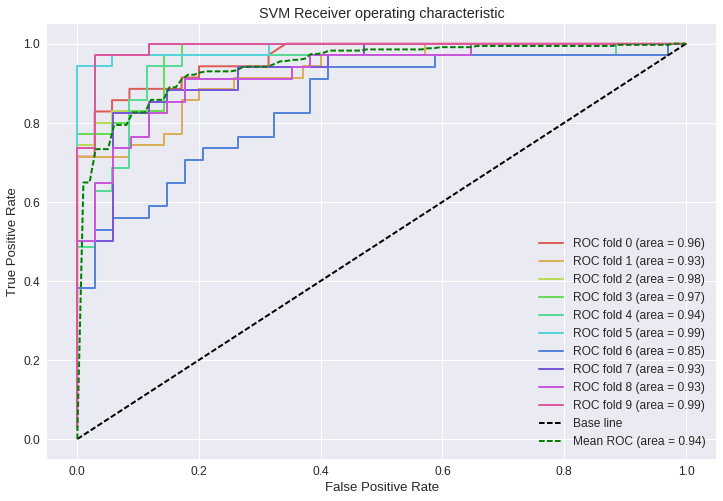

In [16]:


# ROC curve stuff
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
# colors = cycle(['cyan', 'crimson', 'seagreen', 'yellow', 'blue', 'darkorange', 'darkviolet', 'fuchsia',
#                'deepskyblue', 'lightcoral'])
lw = 2
i = 0

sns.set(font_scale = 1.2)
colors = sns.hls_palette(10)
fig, ax = plt.subplots()
fig.set_size_inches(12.0, 8.0)

# Dividing data set for outer cv
cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 43)

precision_scores = []
recall_scores = []
f1_scores = []

fpr_svm = []
tpr_svm = []
threshold_roc_svm = []
# Outer cv
for (train, test), color in zip(cv_outer.split(temp_word_scaled, y_temp_word), colors):
    pipe_svc = Pipeline([('clf', SVC(random_state=1, probability = True))])
    param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
    param_grid = [{'clf__C': param_range, 'clf__kernel': ['linear']}, {'clf__C': param_range, 
             'clf__gamma': param_range, 'clf__kernel': ['rbf']}]

    
    #Inner cv
    cv_inner = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='f1', cv= cv_inner)
    
    gs.fit(temp_word_scaled[train], y_temp_word[train])
    
    print gs.best_params_
    
    scores = gs.best_estimator_.predict(temp_word_scaled[test])
    precision_s = precision_score(y_temp_word[test], scores)
    recall_s = recall_score(y_temp_word[test], scores)
    f1_s = f1_score(y_temp_word[test], scores)
    #print scores
    
    precision_scores.append(precision_s)
    recall_scores.append(recall_s)
    f1_scores.append(f1_s)
    print "Precision", precision_s
    print "Recall:", recall_s
    print "F1:", f1_s
    
    probas_ = gs.best_estimator_.predict_proba(temp_word_scaled[test])
    fpr, tpr, thresholds = roc_curve(y_temp_word[test], probas_[:, 1])
    
    fpr_svm.append(fpr)
    tpr_svm.append(tpr)
    threshold_roc_svm.append(thresholds)
    
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i += 1
    #break
    
print np.mean(precision_scores), np.std(precision_scores) 
print np.mean(recall_scores), np.std(recall_scores)
print np.mean(f1_scores), np.std(f1_scores)

# Draw ROC curves
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Base line')

mean_tpr /= cv_outer.get_n_splits(temp_word_scaled, y_temp_word)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)


plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [17]:
np.save('svm_fpr_10_fold_seed_43.npy', fpr_svm)
np.save('svm_tpr_10_fold_seed_43.npy', tpr_svm)
np.save('svm_threshold_roc_10_fold_seed_43.npy', threshold_roc_svm)

{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.911764705882
Recall: 0.885714285714
F1: 0.898550724638
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.896551724138
Recall: 0.742857142857
F1: 0.8125
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.871794871795
Recall: 0.971428571429
F1: 0.918918918919
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.864864864865
Recall: 0.914285714286
F1: 0.888888888889
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.885714285714
Recall: 0.885714285714
F1: 0.885714285714
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.871794871795
Recall: 0.971428571429
F1: 0.918918918919
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.8
Recall: 0.705882352941
F1: 0.75
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.810810810811
Recall: 0.882352941176
F1: 0.845070422535
{'clf__gamma': 0.01, 

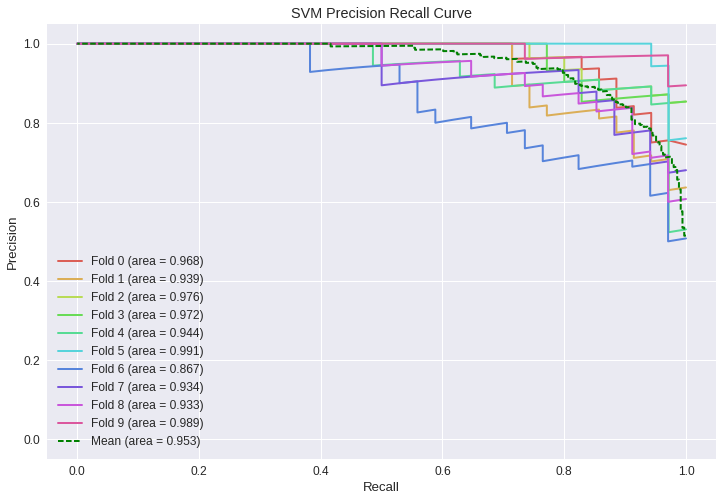

In [48]:
# Precision recall curve
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
# colors = cycle(['cyan', 'crimson', 'seagreen', 'yellow', 'blue', 'darkorange', 'darkviolet', 'fuchsia',
#                'deepskyblue', 'lightcoral'])

sns.set(font_scale = 1.2)
colors = sns.hls_palette(10)
fig, ax = plt.subplots()
fig.set_size_inches(12.0, 8.0)

lw = 2
i = 0


# Dividing data set for outer cv
cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 43)

precision_scores = []
recall_scores = []
f1_scores = []

y_real = []
y_proba = []
# Outer cv
for (train, test), color in zip(cv_outer.split(temp_word_scaled, y_temp_word), colors):
    pipe_svc = Pipeline([('clf', SVC(random_state=1, probability = True))])
    param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
    param_grid = [{'clf__C': param_range, 'clf__kernel': ['linear']}, {'clf__C': param_range, 
             'clf__gamma': param_range, 'clf__kernel': ['rbf']}]

    
    #Inner cv
    cv_inner = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='f1', cv= cv_inner)
    
    gs.fit(temp_word_scaled[train], y_temp_word[train])
    
    print gs.best_params_
    
    scores = gs.best_estimator_.predict(temp_word_scaled[test])
    precision_s = precision_score(y_temp_word[test], scores)
    recall_s = recall_score(y_temp_word[test], scores)
    f1_s = f1_score(y_temp_word[test], scores)
    #print scores
    
    precision_scores.append(precision_s)
    recall_scores.append(recall_s)
    f1_scores.append(f1_s)
    print "Precision", precision_s
    print "Recall:", recall_s
    print "F1:", f1_s
    
    probas_ = gs.best_estimator_.predict_proba(temp_word_scaled[test])
    precision, recall, thresholds = precision_recall_curve(y_temp_word[test], probas_[:, 1])
    plt.plot(recall, precision, lw=lw, color=color,
             label='Fold %d (area = %0.3f)' % (i, auc(recall, precision)))
    y_real.append(y_temp_word[test])
    y_proba.append(probas_[:, 1])
    i += 1
    #break
    
print np.mean(precision_scores), np.std(precision_scores) 
print np.mean(recall_scores), np.std(recall_scores)
print np.mean(f1_scores), np.std(f1_scores)

y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, thresholds = precision_recall_curve(y_real, y_proba)
plt.plot(recall, precision, lw=lw, color='g', linestyle='--',
             label='Mean (area = %0.3f)' % (auc(recall, precision)))

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('SVM Precision Recall Curve')
plt.legend(loc="lower left")
plt.show()

/home/nafizh/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.911764705882
Recall: 0.885714285714
F1: 0.898550724638
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.896551724138
Recall: 0.742857142857
F1: 0.8125
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.871794871795
Recall: 0.971428571429
F1: 0.918918918919
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.864864864865
Recall: 0.914285714286
F1: 0.888888888889
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.885714285714
Recall: 0.885714285714
F1: 0.885714285714
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.871794871795
Recall: 0.971428571429
F1: 0.918918918919
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.8
Recall: 0.705882352941
F1: 0.75
{'clf__gamma': 0.01, 'clf__C': 10.0, 'clf__kernel': 'rbf'}
Precision 0.810810810811
Recall: 0.882352941176
F1: 0.845070422535
{'clf__gamma': 0.01, 

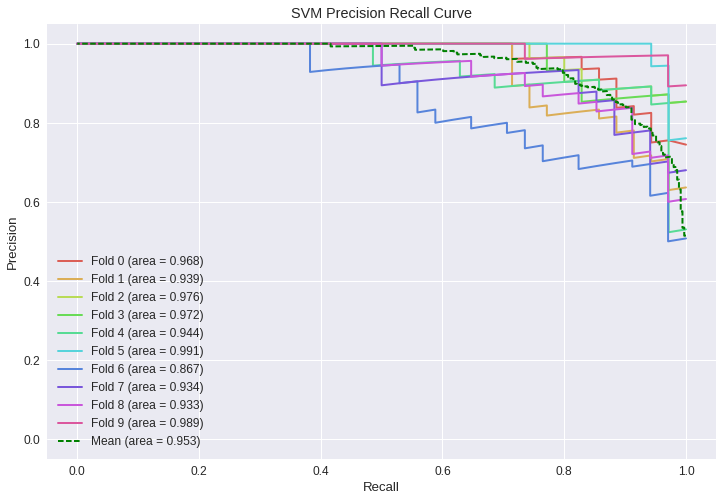

In [6]:
# Precision recall curve
import seaborn as sns
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
# colors = cycle(['cyan', 'crimson', 'seagreen', 'yellow', 'blue', 'darkorange', 'darkviolet', 'fuchsia',
#                'deepskyblue', 'lightcoral'])

sns.set(font_scale = 1.2)
colors = sns.hls_palette(10)
fig, ax = plt.subplots()
fig.set_size_inches(12.0, 8.0)

lw = 2
i = 0


# Dividing data set for outer cv
cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 43)

precision_scores = []
recall_scores = []
f1_scores = []

y_real = []
y_proba = []

precision_svm = []
recall_svm = []
threshold_svm = []
# Outer cv
for (train, test), color in zip(cv_outer.split(temp_word_scaled, y_temp_word), colors):
    pipe_svc = Pipeline([('clf', SVC(random_state=1, probability = True))])
    param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
    param_grid = [{'clf__C': param_range, 'clf__kernel': ['linear']}, {'clf__C': param_range, 
             'clf__gamma': param_range, 'clf__kernel': ['rbf']}]

    
    #Inner cv
    cv_inner = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='f1', cv= cv_inner)
    
    gs.fit(temp_word_scaled[train], y_temp_word[train])
    
    print gs.best_params_
    
    scores = gs.best_estimator_.predict(temp_word_scaled[test])
    precision_s = precision_score(y_temp_word[test], scores)
    recall_s = recall_score(y_temp_word[test], scores)
    f1_s = f1_score(y_temp_word[test], scores)
    #print scores
    
    
    precision_scores.append(precision_s)
    recall_scores.append(recall_s)
    f1_scores.append(f1_s)
    print "Precision", precision_s
    print "Recall:", recall_s
    print "F1:", f1_s
    
    probas_ = gs.best_estimator_.predict_proba(temp_word_scaled[test])
    precision, recall, thresholds = precision_recall_curve(y_temp_word[test], probas_[:, 1])
    
    precision_svm.append(precision)
    recall_svm.append(recall)
    threshold_svm.append(thresholds)
    
    plt.plot(recall, precision, lw=lw, color=color,
             label='Fold %d (area = %0.3f)' % (i, auc(recall, precision)))
    y_real.append(y_temp_word[test])
    y_proba.append(probas_[:, 1])
    i += 1
    #break
    
print np.mean(precision_scores), np.std(precision_scores) 
print np.mean(recall_scores), np.std(recall_scores)
print np.mean(f1_scores), np.std(f1_scores)

y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, thresholds = precision_recall_curve(y_real, y_proba)

precision_svm.append(precision)
recall_svm.append(recall)
threshold_svm.append(thresholds)
plt.plot(recall, precision, lw=lw, color='g', linestyle='--',
             label='Mean (area = %0.3f)' % (auc(recall, precision)))

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('SVM Precision Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [8]:
np.save('svm_precision_10_fold_seed_43.npy', precision_svm)
np.save('svm_recall_10_fold_seed_43.npy', recall_svm)
np.save('svm_threshold_10_fold_seed_43.npy', threshold_svm)

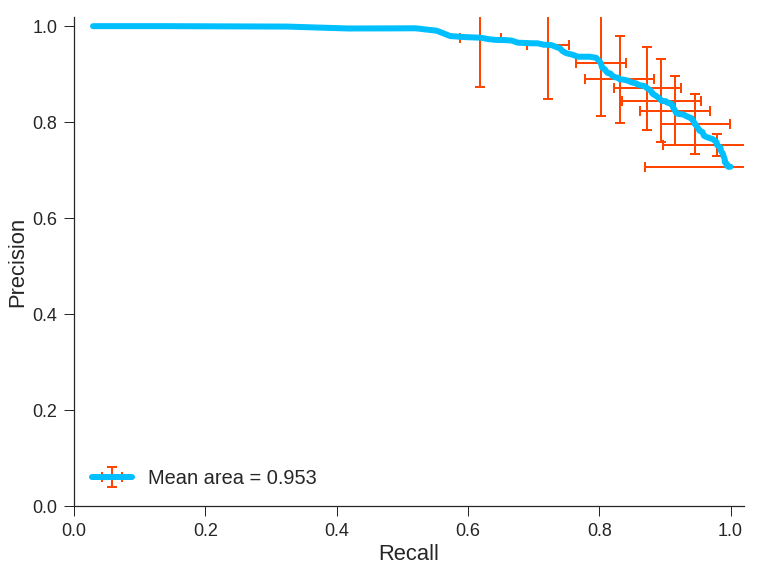

In [19]:
sns.set_style("white")
plt.rc('ytick',labelsize=18)
plt.rc('xtick',labelsize=18)
_, axs = plt.subplots(1, 1, figsize=(12,9))
#fig.set_size_inches(12.0, 8.0)
def label_plot(ax, is_pr=True):
    x, y = (('recall', 'precision')
            if is_pr else
            ('false pos rate', 'true pos rate'))
    ax.set_xlabel('Recall', fontsize = 22)
    ax.set_ylabel('Precision', fontsize = 22)
    ax.set_xlim([0,1.02])
    ax.set_ylim([0,1.02])
    

sampled_thresholds = np.linspace(0.0, 1.0, 100)
sampled_precisions = []
sampled_recalls = []
# assume curves is a list of (precision, recall, threshold)
# tuples where each of those three is a numpy array
count = 0
for precision, recall, threshold in zip(precision_svm, recall_svm, threshold_svm):
    if count == 10:
        break
    sampled_precisions.append(
np.interp(sampled_thresholds, threshold, precision[:-1]))
    sampled_recalls.append(
np.interp(sampled_thresholds, threshold, recall[:-1]))
    count = count + 1

axs.errorbar(
    np.mean(sampled_recalls, axis=0),
    np.mean(sampled_precisions, axis=0),
    np.std(sampled_recalls, axis=0),
    np.std(sampled_precisions, axis=0),
    color='deepskyblue',
    errorevery=10,
    ecolor='orangered',
    lw=2, fmt = '-',  capsize = 5, elinewidth=2,markeredgewidth=2, linewidth = 6.0, 
    label = 'Mean area = %0.3f' % (0.953))
label_plot(axs)
#axs.set_title('N={}'.format(N))
plt.tick_params(size = 10)
axs.spines["top"].set_visible(False)  
axs.spines["right"].set_visible(False)
axs.figure.set_size_inches(12, 9)
axs.legend(loc = 'lower left', fontsize=20)
axs.figure.savefig('pr-svm.pdf', format = 'pdf', dpi = 1200, bbox_inches="tight")
axs.figure.savefig('pr-svm.svg', format = 'svg', dpi = 1200, bbox_inches="tight")

In [19]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', mean_tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - mean_fpr[thresholds > threshold][-1])

In [39]:
evaluate_threshold(0.4)

('Sensitivity:', 0.73327731092436976)
('Specificity:', 0.96969696969696972)


In [28]:
mean_tpr[thresholds > 0.8]

array([ 0.])

In [ ]:
"""
Doing 10-fold manual nested cross validation 10 times with context window of 5
Loop: 0
Precision: 0.872518605683 0.0534703802617
Recall: 0.846890756303 0.038625856401
F1: 0.858184668492 0.0323885320028

Loop: 1
Precision: 0.87452600778 0.0464723791145
Recall: 0.863949579832 0.0566830860815
F1: 0.867302662458 0.0313714225952

Loop: 2
Precision: 0.885350090011 0.0381705856718
Recall: 0.864285714286 0.0477843973863
F1: 0.874123856159 0.0371465058704

Loop: 3
Precision: 0.867783011465 0.0491677640714
Recall: 0.873193277311 0.0333041441768
F1: 0.869644748545 0.0325675879431

Loop: 4
Precision: 0.873147795318 0.0462987016068
Recall: 0.87243697479 0.0857025861186
F1: 0.870960693573 0.0574062884628

Loop: 5
Precision: 0.877298906263 0.0312196737254
Recall: 0.861428571429 0.045509380743
F1: 0.868684404897 0.0315428839807

Loop: 6
Precision: 0.876018497253 0.043725550941
Recall: 0.861260504202 0.0667561776975
F1: 0.866804746804 0.0419150410148

Loop: 7
Precision: 0.876012945719 0.0402169176316
Recall: 0.872521008403 0.038363990631
F1: 0.873815254284 0.034162052527

Loop: 8
Precision: 0.874535377478 0.0621150901336
Recall: 0.866806722689 0.0423986847809
F1: 0.868993442373 0.0387814875019

Loop: 9
Precision: 0.891081962543 0.0423373110594
Recall: 0.855630252101 0.0821381180262
F1: 0.870277080961 0.0490326389093

Precision for 10 times: 0.876827319951 0.00808089319128
Recall for 10 times: 0.863840336134 0.0176648289062
F1 for 10 times: 0.868879155855 0.00819978388965

--------------------Context window of 7 doesn't improve the results

Loop: 0
Precision: 0.867782885319 0.0618582545748
Recall: 0.852857142857 0.0341086422691
F1: 0.858312154642 0.0296671959794
Loop: 1
Precision: 0.879415104837 0.0443921531298
Recall: 0.864201680672 0.0645640702897
F1: 0.869673948042 0.0362881652725
Loop: 2
Precision: 0.877418583256 0.0360631037578
Recall: 0.858487394958 0.0347785472433
F1: 0.867208919324 0.026375427947
Loop: 3
Precision: 0.864906209208 0.0470132801965
Recall: 0.855714285714 0.0420790295572
F1: 0.859523792 0.0368507913108
Loop: 4
Precision: 0.87093645473 0.0518949673521
Recall: 0.872268907563 0.0989072417407
F1: 0.869034445105 0.0650037698215
Loop: 5
Precision: 0.881735156184 0.0546132239456
Recall: 0.867226890756 0.0466897290188
F1: 0.873797996379 0.0443510070462
Loop: 6
Precision: 0.876489465619 0.0455005416308
Recall: 0.864201680672 0.0716823962672
F1: 0.866826799222 0.0238922570918
Loop: 7
Precision: 0.874926634044 0.0403084617297
Recall: 0.861176470588 0.0317704854464
F1: 0.867526504869 0.03059921626
Loop: 8
Precision: 0.873801487359 0.0736304737479
Recall: 0.849495798319 0.0538568930765
F1: 0.860176866965 0.0542735763788
Loop: 9
Precision: 0.882354492555 0.0437535975685
Recall: 0.852605042017 0.0864633605525
F1: 0.864573696124 0.0510894422295


Precision for 10 times: 0.874976647311 0.0105431962038
Recall for 10 times: 0.859823529412 0.0221080203591
F1 for 10 times: 0.865665512267 0.0127847436193

-------------- size 300, context window 11, doesn't improve results
Loop: 0
Precision: 0.87445261461 0.0532246939667
Recall: 0.850168067227 0.0532630604169
F1: 0.859820487162 0.031711512695
Loop: 1
Precision: 0.876797857766 0.0429039195323
Recall: 0.843781512605 0.0690574819235
F1: 0.857762244378 0.0387886228194
Loop: 2
Precision: 0.883950011608 0.0518845122167
Recall: 0.866806722689 0.0543162101818
F1: 0.873216890822 0.0318945714011
Loop: 3
Precision: 0.890873060368 0.0496079255455
Recall: 0.855714285714 0.0353781512605
F1: 0.872409328284 0.0369799975924
Loop: 4
Precision: 0.891295493001 0.0482768797459
Recall: 0.858151260504 0.0935213704668
F1: 0.871202134267 0.0564640371005
Loop: 5
Precision: 0.897813226606 0.0537252405592
Recall: 0.844117647059 0.0558735065975
F1: 0.869104012954 0.0465064434957
Loop: 6
Precision: 0.877808362883 0.0403045866935
Recall: 0.855462184874 0.0576889379202
F1: 0.864956780925 0.0349717337668
Loop: 7
Precision: 0.892378034547 0.0533503366498
Recall: 0.867058823529 0.0191986923736
F1: 0.878982331178 0.0327278723822
Loop: 8
Precision: 0.880565004746 0.0321059850358
Recall: 0.838067226891 0.0350794794005
F1: 0.857841516561 0.0180334263887
Loop: 9
Precision: 0.885966547442 0.0369699640814
Recall: 0.87025210084 0.071552240939
F1: 0.876549447909 0.0450625393635

Precision for 10 times: 0.885190021358 0.00731290831889
Recall for 10 times: 0.854957983193 0.0200698025283
F1 for 10 times: 0.868184517444 0.00986188743297

---------------------------- 50 times 10-fold cv

Precision for 50 times: 0.877925709204 0.00974223697836
Recall for 50 times: 0.863964705882 0.0150765592423
F1 for 50 times: 0.86927821441 0.00901207153213

"""
outer_random_seed_list = [3,13,23,33,43,53,63,73,83,93, 103,113,123,133,143,153,163,173,183,193,
                         203,213,223,233,243,253,263,273,283,293, 303,313,323,333,343,353,363,373,383,393,
                          403,413,423,433,443,453,463,473,483,493]
random_seed_list = [2,12,22,32,42,52,62,72,82,92, 102,112,122,132,142,152,162,172,182,192,
                   202,212,222,232,242,252,262,272,282,292, 302,312,322,332,342,352,362,372,382,392,
                   402,412,422,432,442,452,462,472,482,492]

precision_scores_mean_list = []
recall_scores_mean_list = []
f1_scores_mean_list = []

precision_scores_std_list = []
recall_scores_std_list = []
f1_scores_std_list = []

# Outer cv
for index, rand_seed_i in enumerate(random_seed_list):
    precision_scores = []
    recall_scores = []
    f1_scores = []
    cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = outer_random_seed_list[index])
    for (train, test), color in zip(cv_outer.split(temp_word_scaled, y_temp_word), colors):
        pipe_svc = Pipeline([('clf', SVC(random_state=1, probability = True))])
        param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
        param_grid = [{'clf__C': param_range, 'clf__kernel': ['linear']}, {'clf__C': param_range, 
                 'clf__gamma': param_range, 'clf__kernel': ['rbf']}]


        #Inner cv
        cv_inner = StratifiedKFold(n_splits = 5, shuffle = True, random_state = rand_seed_i)
        gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='f1', cv= cv_inner)

        gs.fit(temp_word_scaled[train], y_temp_word[train])

        #print gs.best_params_

        scores = gs.best_estimator_.predict(temp_word_scaled[test])
        precision_s = precision_score(y_temp_word[test], scores)
        recall_s = recall_score(y_temp_word[test], scores)
        f1_s = f1_score(y_temp_word[test], scores)
        #print scores

        precision_scores.append(precision_s)
        recall_scores.append(recall_s)
        f1_scores.append(f1_s)
    
    # These are the mean of the 10 folds of this particular iteration
    print 'Loop:', index
    print 'Precision:', np.mean(precision_scores), np.std(precision_scores) 
    print 'Recall:', np.mean(recall_scores), np.std(recall_scores)
    print 'F1:', np.mean(f1_scores), np.std(f1_scores)
    
    # Adding to a list, the mean score from each iteration, this list will hold 50
    # values from 50 iterations
    precision_scores_mean_list.append(np.mean(precision_scores))
    recall_scores_mean_list.append(np.mean(recall_scores))
    f1_scores_mean_list.append(np.mean(f1_scores))
    
print 'Precision mean for 50 times:', np.mean(precision_scores_mean_list), 'Std. error:', stats.sem(precision_scores_mean_list)
print 'Recall mean for 50 times:', np.mean(recall_scores_mean_list), 'Std. error:', stats.sem(recall_scores_mean_list)
print 'F1 mean for 50 times:', np.mean(f1_scores_mean_list), 'Std. error:', stats.sem(f1_scores_mean_list)

In [3]:
precision_scores_mean_list = [0.87251860568274231, 0.87452600778027723, 0.88535009001090592, 0.86778301146528702, 0.87314779531818076, 0.8772989062631279, 0.87601849725334868, 0.87601294571882815, 0.87453537747769805, 0.89108196254339445, 0.89069730210703835, 0.86156223613847449, 0.88751622692087584, 0.87343487506417072, 0.89346053966547334, 0.8801881297723082, 0.87558883887038541, 0.88547425612761388, 0.87746157826228743, 0.87031300793704724, 0.88594558109509358, 0.88319965430222103, 0.87845210331598711, 0.88139182490962686, 0.87039203068614834, 0.86606587921603406, 0.86550836550836541, 0.87906576998615527, 0.87057468811824523, 0.8776061448886775, 0.873527660611639, 0.87901716377178063, 0.87100648766515154, 0.87965268930028628, 0.88538153023447141, 0.87745842615755476, 0.87062022491028568, 0.89539753249372134, 0.87702654307336958, 0.88278831752266274, 0.88520895198107541, 0.85849559311633605, 0.88318122095184659, 0.8856086518052837, 0.88419106549680548, 0.86712330841956065, 0.86727812618604594, 0.88366273989632371, 0.8850559611956671, 0.8824310330192684]
recall_scores_mean_list = [0.84689075630252098, 0.86394957983193277, 0.86428571428571443, 0.87319327731092444, 0.87243697478991589, 0.86142857142857143, 0.86126050420168065, 0.87252100840336122, 0.86680672268907555, 0.85563025210084009, 0.87571428571428578, 0.86142857142857143, 0.86420168067226899, 0.85252100840336131, 0.87563025210084044, 0.86428571428571421, 0.85848739495798321, 0.86722689075630244, 0.86983193277310922, 0.84672268907563031, 0.86991596638655477, 0.85831932773109243, 0.86949579831932766, 0.8671428571428571, 0.86151260504201677, 0.86142857142857154, 0.84999999999999998, 0.87016806722689088, 0.85529411764705876, 0.86731092436974799, 0.86411764705882366, 0.85521008403361343, 0.86420168067226888, 0.86134453781512621, 0.87588235294117656, 0.87016806722689088, 0.86991596638655455, 0.85823529411764699, 0.86117647058823543, 0.85521008403361343, 0.87243697478991589, 0.86655462184873944, 0.86386554621848732, 0.86134453781512621, 0.85554621848739498, 0.85268907563025209, 0.86134453781512621, 0.87588235294117633, 0.88142857142857134, 0.86663865546218477]
f1_scores_mean_list = [0.85818466849157393, 0.86730266245753995, 0.87412385615929244, 0.8696447485450044, 0.87096069357333084, 0.86868440489665788, 0.86680474680413688, 0.8738152542837172, 0.86899344237289733, 0.87027708096132894, 0.88220863469766009, 0.86007498320606701, 0.87498955835157111, 0.86101722167593342, 0.88279614005328588, 0.86976527588387498, 0.86512411009285262, 0.87381820413448141, 0.87242856445033079, 0.85737360940971108, 0.87607937851534989, 0.86985104102268118, 0.87219403094205306, 0.8708853213199923, 0.86397184360892454, 0.86313985196435061, 0.85650446759952903, 0.87285423877840385, 0.85884130741209019, 0.87068723521781821, 0.86819575195395715, 0.8649257236803265, 0.86449221750328742, 0.86839796860556806, 0.87954608791337985, 0.87291671720678232, 0.86837087619783893, 0.8733172132889141, 0.86812760223665497, 0.8676455867984002, 0.87681242244323077, 0.86114441016808496, 0.87080713963714695, 0.8725694813233329, 0.8687913159035805, 0.85820651171409423, 0.86302767612509024, 0.87791929366131993, 0.88198100479291131, 0.87331914247634157]
print (np.mean(precision_scores_mean_list), stats.sem(precision_scores_mean_list))
print (np.mean(recall_scores_mean_list), stats.sem(recall_scores_mean_list))
print (np.mean(f1_scores_mean_list), stats.sem(f1_scores_mean_list))

(0.87792570920430313, 0.0011493241231450848)
(0.86396470588235286, 0.0011063027538615441)
(0.86927821441025377, 0.00091497726291605056)


In [52]:
"""
Calculating if word2vec results are significant 
"""
from scipy.stats import wilcoxon

k_mer_precision = [0.86773643527273292, 0.87253825063405155, 0.85983623651329177, 0.85579045180207414, 
                   0.86452404896590951, 0.86996682755303445, 0.88730606055202821, 0.87425662974131568, 
                   0.85787800237397016, 0.84561718966993971, 0.84924435034555668, 0.87031691974902292, 
                   0.84515918269806944, 0.88228603777797332, 0.88498762698359479, 0.84695279845667026, 
                   0.89360630826000842, 0.8810832791829496, 0.85621310878603618, 0.86779130475999544, 
                   0.88767902971347967, 0.83866637893570195, 0.86778397022299458, 0.90411463032381612, 
                   0.87971981313893077, 0.86321676326111807, 0.85421198687375155, 0.88802156250812436, 
                   0.83971810130360058, 0.86679882962141031, 0.86480925707474943, 0.87621274873236121, 
                   0.86198912809240069, 0.86803579868934444, 0.85367604402864961, 0.87575865226727301, 
                   0.86842176901671009, 0.84446162418648196, 0.8333475295090963, 0.83943483142244746, 
                   0.86798939631800209, 0.8615392040361215, 0.85043582291747322, 0.85935204435204438, 
                   0.88725504628374652, 0.83464424054802255, 0.85044361448618599, 0.85429330614594523, 
                   0.85453704032651401, 0.87790658942081268]

precision_statistic_val, precision_p_value = wilcoxon(k_mer_precision, precision_scores_mean_list)
print precision_statistic_val, precision_p_value

#print precision_scores_mean_list
k_mer_recall = [0.84134453781512608, 0.82084033613445373, 0.84689075630252086, 0.82126050420168073, 
                0.83151260504201685, 0.84411764705882353, 0.82991596638655474, 0.84630252100840342, 
                0.84705882352941175, 0.84168067226890764, 0.86100840336134454, 0.82966386554621852, 
                0.83243697478991607, 0.81999999999999995, 0.81798319327731106, 0.84689075630252098, 
                0.81756302521008395, 0.82890756302521018, 0.84621848739495797, 0.81554621848739506, 
                0.81504201680672261, 0.83218487394957974, 0.82294117647058818, 0.82386554621848751, 
                0.81252100840336128, 0.82084033613445373, 0.85596638655462187, 0.8322689075630253, 
                0.85521008403361343, 0.84705882352941164, 0.83210084033613452, 0.82974789915966396, 
                0.84647058823529409, 0.8373949579831933, 0.83243697478991607, 0.80605042016806716, 
                0.83815126050420174, 0.87025210084033622, 0.83453781512605052, 0.87831932773109234, 
                0.84647058823529409, 0.83420168067226896, 0.84689075630252098, 0.83285714285714296, 
                0.82672268907563018, 0.85823529411764699, 0.84378151260504208, 0.8360504201680673, 
                0.85798319327731087, 0.85848739495798321]

recall_statistic_val, recall_p_value = wilcoxon(k_mer_recall, recall_scores_mean_list)
print recall_statistic_val, recall_p_value

k_mer_f1 = [0.8495970029571065, 0.84299825565560926, 0.85091209408664648, 0.83469013704845363, 
            0.84251250521592769, 0.85365976152300116, 0.85392253109037775, 0.85350210500699342, 
            0.85041584981295648, 0.83863221819701561, 0.85327297708459471, 0.84634931848437545, 
            0.83378137472115754, 0.84558133623704923, 0.84598157228247128, 0.84453030790129091, 
            0.85254869828239388, 0.85114196201051961, 0.84633337755335525, 0.83908501571724481, 
            0.84883240618054534, 0.83241502016364122, 0.84103352406333765, 0.85768870512224082, 
            0.84183672759346673, 0.83549543991065889, 0.85142197826863908, 0.85592180205506074, 
            0.84305864321556379, 0.85548884336194675, 0.84593356465483982, 0.8480154431473389, 
            0.85049869307158799, 0.84759454286591596, 0.83941824420105315, 0.83807928126957987, 
            0.85087583453571458, 0.85383033574440059, 0.82891928856674046, 0.85489772504238337, 
            0.85250737443058466, 0.84430822102460323, 0.84354726132585367, 0.84298744873147824, 
            0.8512042200541885, 0.84357297646098428, 0.84337859040762608, 0.83788192082147861, 
            0.85230022251850457, 0.8647281372444573]

f1_statistic_val, f1_p_value = wilcoxon(k_mer_f1, f1_scores_mean_list)
print f1_statistic_val, f1_p_value

print precision_scores_mean_list
print recall_scores_mean_list
print f1_scores_mean_list

191.0 1.63115130551e-05
29.5 4.37739755982e-09
0.0 7.55692945586e-10
[0.87251860568274231, 0.87452600778027723, 0.88535009001090592, 0.86778301146528702, 0.87314779531818076, 0.8772989062631279, 0.87601849725334868, 0.87601294571882815, 0.87453537747769805, 0.89108196254339445, 0.89069730210703835, 0.86156223613847449, 0.88751622692087584, 0.87343487506417072, 0.89346053966547334, 0.8801881297723082, 0.87558883887038541, 0.88547425612761388, 0.87746157826228743, 0.87031300793704724, 0.88594558109509358, 0.88319965430222103, 0.87845210331598711, 0.88139182490962686, 0.87039203068614834, 0.86606587921603406, 0.86550836550836541, 0.87906576998615527, 0.87057468811824523, 0.8776061448886775, 0.873527660611639, 0.87901716377178063, 0.87100648766515154, 0.87965268930028628, 0.88538153023447141, 0.87745842615755476, 0.87062022491028568, 0.89539753249372134, 0.87702654307336958, 0.88278831752266274, 0.88520895198107541, 0.85849559311633605, 0.88318122095184659, 0.8856086518052837, 0.8841910654

In [51]:
# 95% confidence intervals for precision, recall, f1
from scipy import stats
print stats.t.interval(0.95, len(precision_scores_mean_list)-1, loc=np.mean(precision_scores_mean_list), 
                       scale=stats.sem(precision_scores_mean_list))
print stats.t.interval(0.95, len(recall_scores_mean_list)-1, loc=np.mean(recall_scores_mean_list), 
                       scale=stats.sem(recall_scores_mean_list))
print stats.t.interval(0.95, len(f1_scores_mean_list)-1, loc=np.mean(f1_scores_mean_list), 
                       scale=stats.sem(f1_scores_mean_list))

(0.87561605591002978, 0.88023536249857648)
(0.86174150726634546, 0.86618790449836025)
(0.86743949876257698, 0.87111693005793056)


## Logistic Regression

In [82]:
"""
non-overlapping
0.751480282229
{'logis__penalty': 'l2', 'logis__C': 0.1}

overlapping
0.826181543202
{'logis__penalty': 'l2', 'logis__C': 0.1}

overlapping - x_word_scaled_minmax
0.820503494472
{'logis__penalty': 'l2', 'logis__C': 10.0}

model is trembl
10-fold less_than_30_pos_neg
0.840894147316
{'logis__penalty': 'l1', 'logis__C': 1.0}

"""

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold

pipe_logis = Pipeline([('logis', LogisticRegression(random_state = 1))])
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'logis__C': param_range, 'logis__penalty': ['l1']}, 
             {'logis__C': param_range, 'logis__penalty': ['l2']}]

cv = StratifiedKFold(np.reshape(y_temp_word, (y_temp_word.shape[0], )), n_folds= 10, shuffle=True, random_state=42)
gs = GridSearchCV(estimator=pipe_logis, param_grid=param_grid, scoring='f1', cv= cv)
gs = gs.fit(temp_word_scaled, y_temp_word)

print(gs.best_score_)
print(gs.best_params_)

In [7]:
"""
Nested Cross-validation

CV f1: 0.837 (+/- 0.034)
"""
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

pipe_logis = Pipeline([('logis', LogisticRegression(random_state = 1))])
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'logis__C': param_range, 'logis__penalty': ['l1']}, 
             {'logis__C': param_range, 'logis__penalty': ['l2']}]


c, r = y_temp_word.shape
labels = y_temp_word.reshape(c,)
cv_inner = StratifiedKFold(n_splits= 5, shuffle=True, random_state=42)
cv_outer = StratifiedKFold(n_splits= 10, shuffle=True, random_state=43)
gs = GridSearchCV(estimator=pipe_logis, param_grid=param_grid, scoring='accuracy', cv= cv_inner)
scores = cross_val_score(gs, temp_word_scaled, labels, cv=cv_outer, scoring = 'accuracy')

#print(gs.best_score_)
#print(gs.best_params_)
print('CV f1: %.3f (+/- %.3f)' % (np.mean(scores), np.std(scores))) 

{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.903225806452
Recall: 0.8
F1: 0.848484848485
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.8
Recall: 0.8
F1: 0.8
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.825
Recall: 0.942857142857
F1: 0.88
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.837837837838
Recall: 0.885714285714
F1: 0.861111111111
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.866666666667
Recall: 0.742857142857
F1: 0.8
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.861111111111
Recall: 0.885714285714
F1: 0.87323943662
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.758620689655
Recall: 0.647058823529
F1: 0.698412698413
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.833333333333
Recall: 0.882352941176
F1: 0.857142857143
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.8125
Recall: 0.764705882353
F1: 0.787878787879
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.916666666667
Recall: 0.647058823529
F1: 0.7

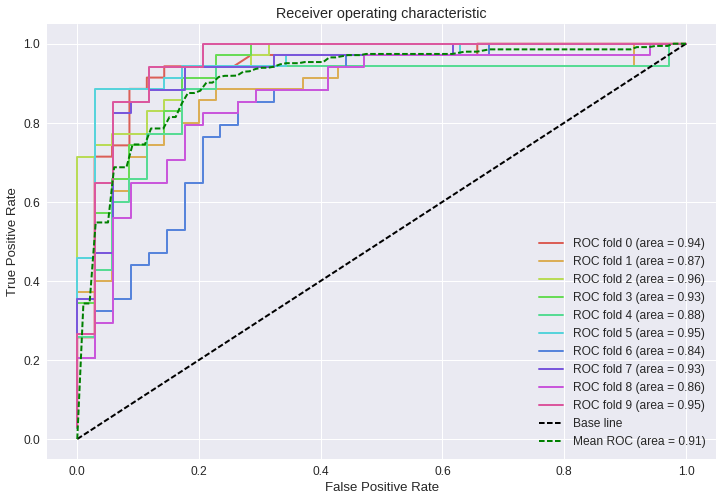

In [46]:
"""
Manual nested cross validation and ROC curve from that
"""

# ROC curve stuff
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
# colors = cycle(['cyan', 'crimson', 'seagreen', 'yellow', 'blue', 'darkorange', 'darkviolet', 'fuchsia',
#                'deepskyblue', 'lightcoral'])
lw = 2
i = 0

sns.set(font_scale = 1.2)
colors = sns.hls_palette(10)
fig, ax = plt.subplots()
fig.set_size_inches(12.0, 8.0)

# Dividing data set for outer cv
cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 43)

precision_scores = []
recall_scores = []
f1_scores = []

# Outer cv
for (train, test), color in zip(cv_outer.split(temp_word_scaled, y_temp_word), colors):
    pipe_logis = Pipeline([('logis', LogisticRegression(random_state = 1))])
    param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
    param_grid = [{'logis__C': param_range, 'logis__penalty': ['l1']}, 
             {'logis__C': param_range, 'logis__penalty': ['l2']}]
    
    #Inner cv
    cv_inner = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    gs = GridSearchCV(estimator=pipe_logis, param_grid=param_grid, scoring='f1', cv= cv_inner)
    
    gs.fit(temp_word_scaled[train], y_temp_word[train])
    
    print gs.best_params_
    
    scores = gs.best_estimator_.predict(temp_word_scaled[test])
    precision_s = precision_score(y_temp_word[test], scores)
    recall_s = recall_score(y_temp_word[test], scores)
    f1_s = f1_score(y_temp_word[test], scores)
    #print scores
    
    precision_scores.append(precision_s)
    recall_scores.append(recall_s)
    f1_scores.append(f1_s)
    print "Precision", precision_s
    print "Recall:", recall_s
    print "F1:", f1_s
    
    probas_ = gs.best_estimator_.predict_proba(temp_word_scaled[test])
    fpr, tpr, thresholds = roc_curve(y_temp_word[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i += 1
    
    
    #break
    
print np.mean(precision_scores), np.std(precision_scores) 
print np.mean(recall_scores), np.std(recall_scores)
print np.mean(f1_scores), np.std(f1_scores)

# Draw ROC curves
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Base line')

mean_tpr /= cv_outer.get_n_splits(temp_word_scaled, y_temp_word)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.903225806452
Recall: 0.8
F1: 0.848484848485
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.8
Recall: 0.8
F1: 0.8
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.825
Recall: 0.942857142857
F1: 0.88
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.837837837838
Recall: 0.885714285714
F1: 0.861111111111
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.866666666667
Recall: 0.742857142857
F1: 0.8
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.861111111111
Recall: 0.885714285714
F1: 0.87323943662
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.758620689655
Recall: 0.647058823529
F1: 0.698412698413
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.833333333333
Recall: 0.882352941176
F1: 0.857142857143
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.8125
Recall: 0.764705882353
F1: 0.787878787879
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.916666666667
Recall: 0.647058823529
F1: 0.7

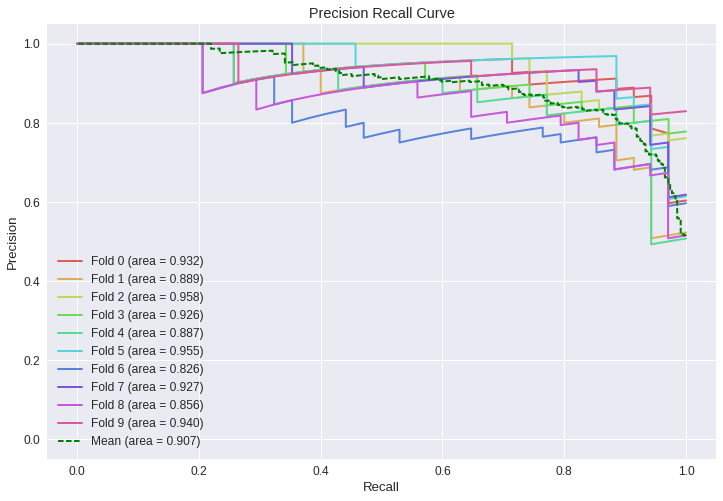

In [45]:
"""
Manual nested cross validation and ROC curve from that
"""
import seaborn as sns
sns.set(font_scale = 1.2)
colors = sns.hls_palette(10)
# ROC curve stuff
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
# colors = cycle(['cyan', 'crimson', 'seagreen', 'yellow', 'blue', 'darkorange', 'darkviolet', 'fuchsia',
#                'deepskyblue', 'lightcoral'])

# construct cmap
#flatui = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
fig, ax = plt.subplots()
fig.set_size_inches(12.0, 8.0)

#colors = my_cmap
lw = 2
i = 0



# Dividing data set for outer cv
cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 43)

precision_scores = []
recall_scores = []
f1_scores = []

y_real = []
y_proba = []

for i in range(1, 10):
    for (train, test), color in zip(cv_outer.split(temp_word_scaled, y_temp_word), colors):
        pipe_logis = Pipeline([('logis', LogisticRegression(random_state = 1))])
        param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
        param_grid = [{'logis__C': param_range, 'logis__penalty': ['l1']}, 
                 {'logis__C': param_range, 'logis__penalty': ['l2']}]

        #Inner cv
        cv_inner = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
        gs = GridSearchCV(estimator=pipe_logis, param_grid=param_grid, scoring='f1', cv= cv_inner)

        gs.fit(temp_word_scaled[train], y_temp_word[train])

        print gs.best_params_

        scores = gs.best_estimator_.predict(temp_word_scaled[test])
        precision_s = precision_score(y_temp_word[test], scores)
        recall_s = recall_score(y_temp_word[test], scores)
        f1_s = f1_score(y_temp_word[test], scores)
        #print scores

        precision_scores.append(precision_s)
        recall_scores.append(recall_s)
        f1_scores.append(f1_s)
        print "Precision", precision_s
        print "Recall:", recall_s
        print "F1:", f1_s

        probas_ = gs.best_estimator_.predict_proba(temp_word_scaled[test])
    #     fpr, tpr, thresholds = roc_curve(y_temp_word[test], probas_[:, 1])
    #     mean_tpr += interp(mean_fpr, fpr, tpr)
    #     mean_tpr[0] = 0.0
    #     roc_auc = auc(fpr, tpr)
    #     plt.plot(fpr, tpr, lw=lw, color=color,
    #              label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

        precision, recall, thresholds = precision_recall_curve(y_temp_word[test], probas_[:, 1])
        plt.plot(recall, precision, lw=lw, color=color,
                 label='Fold %d (area = %0.3f)' % (i, auc(recall, precision)))
        y_real.append(y_temp_word[test])
        y_proba.append(probas_[:, 1])
        i += 1
    
    
    #break
    
print np.mean(precision_scores), np.std(precision_scores) 
print np.mean(recall_scores), np.std(recall_scores)
print np.mean(f1_scores), np.std(f1_scores)

# # Draw ROC curves
# plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
#          label='Base line')

# mean_tpr /= cv_outer.get_n_splits(temp_word_scaled, y_temp_word)
# mean_tpr[-1] = 1.0
# mean_auc = auc(mean_fpr, mean_tpr)
# plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
#          label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, thresholds = precision_recall_curve(y_real, y_proba)
plt.plot(recall, precision, lw=lw, color='g', linestyle='--',
             label='Mean (area = %0.3f)' % (auc(recall, precision)))

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend(loc="lower left")
plt.show()

{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.903225806452
Recall: 0.8
F1: 0.848484848485
(58,)
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.8
Recall: 0.8
F1: 0.8
(68,)
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.825
Recall: 0.942857142857
F1: 0.88
(45,)
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.837837837838
Recall: 0.885714285714
F1: 0.861111111111
(46,)
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.866666666667
Recall: 0.742857142857
F1: 0.8
(70,)
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.861111111111
Recall: 0.885714285714
F1: 0.87323943662
(58,)
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.758620689655
Recall: 0.647058823529
F1: 0.698412698413
(57,)
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.833333333333
Recall: 0.882352941176
F1: 0.857142857143
(56,)
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.8125
Recall: 0.764705882353
F1: 0.787878787879
(67,)
{'logis__penalty': 'l2', 'logis__C': 0.1}
P

/home/nafizh/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:82: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/home/nafizh/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:84: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.8
Recall: 0.8
F1: 0.8
(68,)
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.825
Recall: 0.942857142857
F1: 0.88
(45,)
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.837837837838
Recall: 0.885714285714
F1: 0.861111111111
(46,)
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.866666666667
Recall: 0.742857142857
F1: 0.8
(70,)
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.861111111111
Recall: 0.885714285714
F1: 0.87323943662
(58,)
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.758620689655
Recall: 0.647058823529
F1: 0.698412698413
(57,)
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.833333333333
Recall: 0.882352941176
F1: 0.857142857143
(56,)
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.8125
Recall: 0.764705882353
F1: 0.787878787879
(67,)
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.916666666667
Recall: 0.647058823529
F1: 0.758620689655
(42,)
{'logis__penalty': 'l2', 'logis__

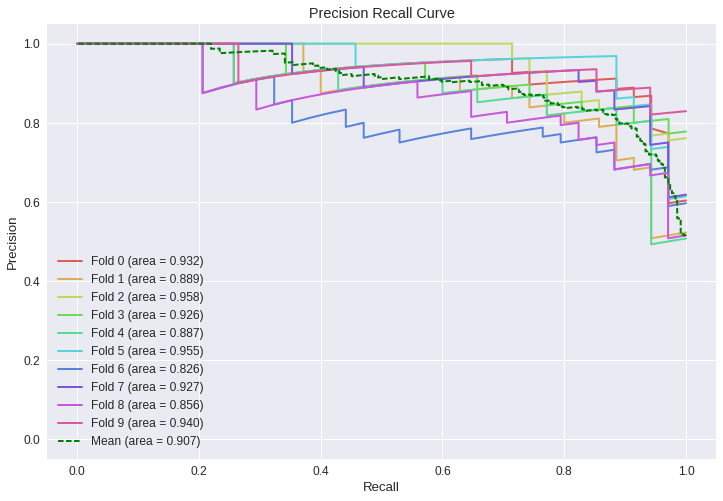

In [84]:
"""
Manual nested cross validation and ROC curve from that
"""
import seaborn as sns
sns.set(font_scale = 1.2)
colors = sns.hls_palette(10)
# ROC curve stuff
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
# colors = cycle(['cyan', 'crimson', 'seagreen', 'yellow', 'blue', 'darkorange', 'darkviolet', 'fuchsia',
#                'deepskyblue', 'lightcoral'])

# construct cmap
#flatui = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
fig, ax = plt.subplots()
fig.set_size_inches(12.0, 8.0)

#colors = my_cmap
lw = 2
i = 0



# Dividing data set for outer cv
cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 43)

precision_scores = []
recall_scores = []
f1_scores = []

y_real = []
y_proba = []

fold_to_prec = defaultdict(list)
fold_to_re = defaultdict(list)


for i in range(0, 10):
    count = 0
    for (train, test) in cv_outer.split(temp_word_scaled, y_temp_word):
        pipe_logis = Pipeline([('logis', LogisticRegression(random_state = 1))])
        param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
        param_grid = [{'logis__C': param_range, 'logis__penalty': ['l1']}, 
                 {'logis__C': param_range, 'logis__penalty': ['l2']}]

        #Inner cv
        cv_inner = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
        gs = GridSearchCV(estimator=pipe_logis, param_grid=param_grid, scoring='f1', cv= cv_inner)

        gs.fit(temp_word_scaled[train], y_temp_word[train])

        print gs.best_params_

        scores = gs.best_estimator_.predict(temp_word_scaled[test])
        precision_s = precision_score(y_temp_word[test], scores)
        recall_s = recall_score(y_temp_word[test], scores)
        f1_s = f1_score(y_temp_word[test], scores)
        #print scores

        precision_scores.append(precision_s)
        recall_scores.append(recall_s)
        f1_scores.append(f1_s)
        print "Precision", precision_s
        print "Recall:", recall_s
        print "F1:", f1_s

        probas_ = gs.best_estimator_.predict_proba(temp_word_scaled[test])
    #     fpr, tpr, thresholds = roc_curve(y_temp_word[test], probas_[:, 1])
    #     mean_tpr += interp(mean_fpr, fpr, tpr)
    #     mean_tpr[0] = 0.0
    #     roc_auc = auc(fpr, tpr)
    #     plt.plot(fpr, tpr, lw=lw, color=color,
    #              label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

        precision, recall, thresholds = precision_recall_curve(y_temp_word[test], probas_[:, 1])
#         plt.plot(recall, precision, lw=lw, color=color,
#                  label='Fold %d (area = %0.3f)' % (i, auc(recall, precision)))
        print (precision.shape)
        
        if fold_to_prec[count] == []:
            fold_to_prec[count] = np.zeros(precision.shape)
        if fold_to_re[count] == []:
            fold_to_re[count] = np.zeros(recall.shape)
        fold_to_prec[count] = np.add(fold_to_prec[count], precision)
        #print (fold_to_prec[count])
        fold_to_re[count] = np.add(fold_to_re[count], recall)
        y_real.append(y_temp_word[test])
        y_proba.append(probas_[:, 1])
        i += 1
        count = count + 1
    
    
    #break

for i, color in zip(range(0, 10), colors):
    m_recall = fold_to_re[i]/10.0
    m_precision = fold_to_prec[i]/10.0
    plt.plot(m_recall, m_precision, lw=lw, color=color,
         label='Fold %d (area = %0.3f)' % (i, auc(m_recall, m_precision)))

    
# print np.mean(precision_scores), np.std(precision_scores) 
# print np.mean(recall_scores), np.std(recall_scores)
# print np.mean(f1_scores), np.std(f1_scores)

# # Draw ROC curves
# plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
#          label='Base line')

# mean_tpr /= cv_outer.get_n_splits(temp_word_scaled, y_temp_word)
# mean_tpr[-1] = 1.0
# mean_auc = auc(mean_fpr, mean_tpr)
# plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
#          label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, thresholds = precision_recall_curve(y_real, y_proba)
plt.plot(recall, precision, lw=lw, color='g', linestyle='--',
             label='Mean (area = %0.3f)' % (auc(recall, precision)))

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [86]:
y_real.shape
y_proba.shape

(6920,)

{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.903225806452
Recall: 0.8
F1: 0.848484848485
(17,)
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.8
Recall: 0.8
F1: 0.8
(25,)
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.825
Recall: 0.942857142857
F1: 0.88
(19,)
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.837837837838
Recall: 0.885714285714
F1: 0.861111111111
(19,)
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.866666666667
Recall: 0.742857142857
F1: 0.8
(17,)
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.861111111111
Recall: 0.885714285714
F1: 0.87323943662
(13,)
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.758620689655
Recall: 0.647058823529
F1: 0.698412698413
(30,)
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.833333333333
Recall: 0.882352941176
F1: 0.857142857143
(17,)
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.8125
Recall: 0.764705882353
F1: 0.787878787879
(25,)
{'logis__penalty': 'l2', 'logis__C': 0.1}
P

/home/nafizh/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:64: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/home/nafizh/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:66: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.8
Recall: 0.8
F1: 0.8
(25,)
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.825
Recall: 0.942857142857
F1: 0.88
(19,)
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.837837837838
Recall: 0.885714285714
F1: 0.861111111111
(19,)
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.866666666667
Recall: 0.742857142857
F1: 0.8
(17,)
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.861111111111
Recall: 0.885714285714
F1: 0.87323943662
(13,)
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.758620689655
Recall: 0.647058823529
F1: 0.698412698413
(30,)
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.833333333333
Recall: 0.882352941176
F1: 0.857142857143
(17,)
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.8125
Recall: 0.764705882353
F1: 0.787878787879
(25,)
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.916666666667
Recall: 0.647058823529
F1: 0.758620689655
(11,)


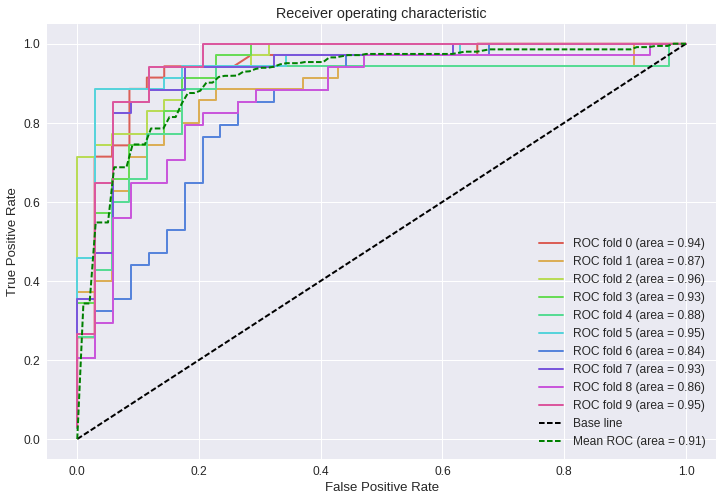

In [90]:
"""
Manual nested cross validation and ROC curve from that
"""

# ROC curve stuff
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
# colors = cycle(['cyan', 'crimson', 'seagreen', 'yellow', 'blue', 'darkorange', 'darkviolet', 'fuchsia',
#                'deepskyblue', 'lightcoral'])
lw = 2
i = 0

sns.set(font_scale = 1.2)
colors = sns.hls_palette(10)
fig, ax = plt.subplots()
fig.set_size_inches(12.0, 8.0)

# Dividing data set for outer cv
cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 43)

precision_scores = []
recall_scores = []
f1_scores = []

# Outer cv
fold_to_fpr = defaultdict(list)
fold_to_tpr = defaultdict(list)


for i in range(0, 2):
    count = 0
    for (train, test), color in zip(cv_outer.split(temp_word_scaled, y_temp_word), colors):
        pipe_logis = Pipeline([('logis', LogisticRegression(random_state = 1))])
        param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
        param_grid = [{'logis__C': param_range, 'logis__penalty': ['l1']}, 
                 {'logis__C': param_range, 'logis__penalty': ['l2']}]

        #Inner cv
        cv_inner = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
        gs = GridSearchCV(estimator=pipe_logis, param_grid=param_grid, scoring='f1', cv= cv_inner)

        gs.fit(temp_word_scaled[train], y_temp_word[train])

        print gs.best_params_

        scores = gs.best_estimator_.predict(temp_word_scaled[test])
        precision_s = precision_score(y_temp_word[test], scores)
        recall_s = recall_score(y_temp_word[test], scores)
        f1_s = f1_score(y_temp_word[test], scores)
        #print scores

        precision_scores.append(precision_s)
        recall_scores.append(recall_s)
        f1_scores.append(f1_s)
        print "Precision", precision_s
        print "Recall:", recall_s
        print "F1:", f1_s

        probas_ = gs.best_estimator_.predict_proba(temp_word_scaled[test])
        fpr, tpr, thresholds = roc_curve(y_temp_word[test], probas_[:, 1])
        
        print (fpr.shape)
        
        if fold_to_fpr[count] == []:
            fold_to_fpr[count] = np.zeros(fpr.shape)
        if fold_to_tpr[count] == []:
            fold_to_tpr[count] = np.zeros(tpr.shape)
        fold_to_fpr[count] = np.add(fold_to_fpr[count], fpr)
        #print (fold_to_prec[count])
        fold_to_tpr[count] = np.add(fold_to_tpr[count], tpr)
        
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
#         roc_auc = auc(fpr, tpr)
#         plt.plot(fpr, tpr, lw=lw, color=color,
#                  label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
        i += 1
        count = count + 1
    
    
    #break
    
for i, color in zip(range(0, 10), colors):
    m_tpr = fold_to_tpr[i]/2.0
    m_fpr = fold_to_fpr[i]/2.0
    roc_auc = auc(m_fpr, m_tpr)
    plt.plot(m_fpr, m_tpr, lw=lw, color=color,
         label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

# Draw ROC curves
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Base line')

mean_tpr /= 20
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.903225806452
Recall: 0.8
F1: 0.848484848485
(58,)
(17,)
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.8
Recall: 0.8
F1: 0.8
(68,)
(25,)
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.825
Recall: 0.942857142857
F1: 0.88
(45,)
(19,)
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.837837837838
Recall: 0.885714285714
F1: 0.861111111111
(46,)
(19,)
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.866666666667
Recall: 0.742857142857
F1: 0.8
(70,)
(17,)
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.861111111111
Recall: 0.885714285714
F1: 0.87323943662
(58,)
(13,)
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.758620689655
Recall: 0.647058823529
F1: 0.698412698413
(57,)
(30,)
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.833333333333
Recall: 0.882352941176
F1: 0.857142857143
(56,)
(17,)
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.8125
Recall: 0.764705882353
F1: 0.787878787879
(

/home/nafizh/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:82: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/home/nafizh/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:84: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/home/nafizh/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:94: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/home/nafizh/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:96: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.8
Recall: 0.8
F1: 0.8
(68,)
(25,)
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.825
Recall: 0.942857142857
F1: 0.88
(45,)
(19,)
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.837837837838
Recall: 0.885714285714
F1: 0.861111111111
(46,)
(19,)
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.866666666667
Recall: 0.742857142857
F1: 0.8
(70,)
(17,)
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.861111111111
Recall: 0.885714285714
F1: 0.87323943662
(58,)
(13,)
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.758620689655
Recall: 0.647058823529
F1: 0.698412698413
(57,)
(30,)
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.833333333333
Recall: 0.882352941176
F1: 0.857142857143
(56,)
(17,)
{'logis__penalty': 'l2', 'logis__C': 0.01}
Precision 0.8125
Recall: 0.764705882353
F1: 0.787878787879
(67,)
(25,)
{'logis__penalty': 'l2', 'logis__C': 0.1}
Precision 0.916666666667
Recall: 0.647058823529
F1: 0.7586

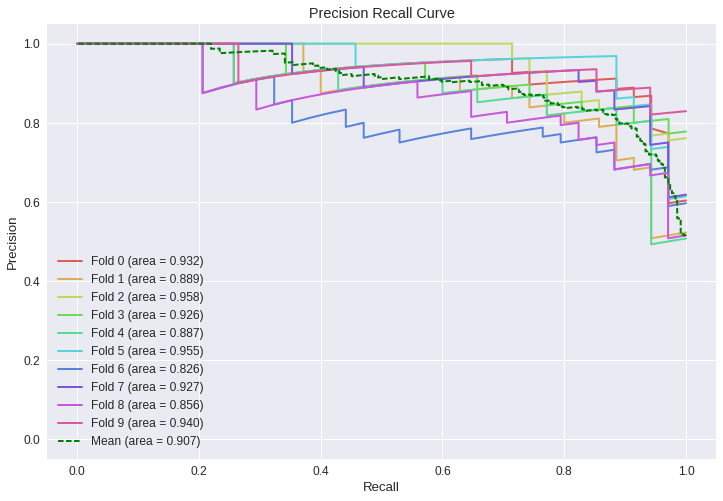

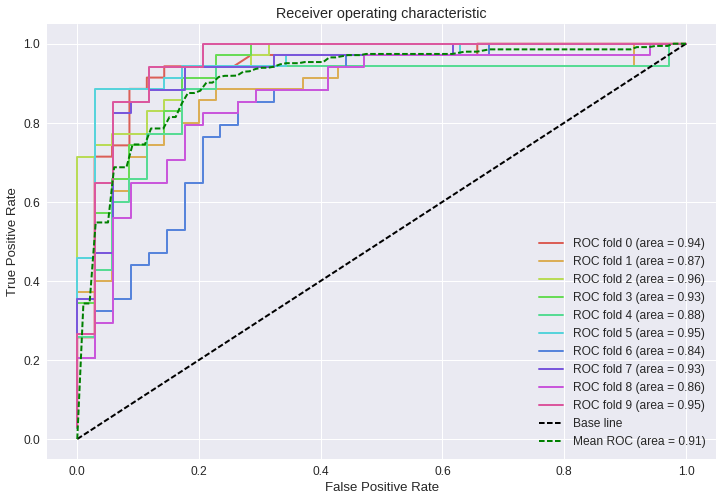

In [98]:
"""
Manual nested cross validation and ROC curve from that
"""
import seaborn as sns
sns.set(font_scale = 1.2)
colors = sns.hls_palette(10)
# ROC curve stuff
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
# colors = cycle(['cyan', 'crimson', 'seagreen', 'yellow', 'blue', 'darkorange', 'darkviolet', 'fuchsia',
#                'deepskyblue', 'lightcoral'])

# construct cmap
#flatui = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
# fig, ax = plt.subplots()

fig1 = plt.figure()
fig1.set_size_inches(12.0, 8.0)

ax1 = fig1.add_subplot(111)

fig2 = plt.figure()
fig2.set_size_inches(12.0, 8.0)
ax2 = fig2.add_subplot(111)


#colors = my_cmap
lw = 2
i = 0



# Dividing data set for outer cv
cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 43)

precision_scores = []
recall_scores = []
f1_scores = []

y_real = []
y_proba = []

fold_to_prec = defaultdict(list)
fold_to_re = defaultdict(list)
fold_to_fpr = defaultdict(list)
fold_to_tpr = defaultdict(list)


for i in range(0, 2):
    count = 0
    for (train, test) in cv_outer.split(temp_word_scaled, y_temp_word):
        pipe_logis = Pipeline([('logis', LogisticRegression(random_state = 1))])
        param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
        param_grid = [{'logis__C': param_range, 'logis__penalty': ['l1']}, 
                 {'logis__C': param_range, 'logis__penalty': ['l2']}]

        #Inner cv
        cv_inner = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
        gs = GridSearchCV(estimator=pipe_logis, param_grid=param_grid, scoring='f1', cv= cv_inner)

        gs.fit(temp_word_scaled[train], y_temp_word[train])

        print gs.best_params_

        scores = gs.best_estimator_.predict(temp_word_scaled[test])
        precision_s = precision_score(y_temp_word[test], scores)
        recall_s = recall_score(y_temp_word[test], scores)
        f1_s = f1_score(y_temp_word[test], scores)
        #print scores

        precision_scores.append(precision_s)
        recall_scores.append(recall_s)
        f1_scores.append(f1_s)
        print "Precision", precision_s
        print "Recall:", recall_s
        print "F1:", f1_s

        probas_ = gs.best_estimator_.predict_proba(temp_word_scaled[test])

        precision, recall, thresholds = precision_recall_curve(y_temp_word[test], probas_[:, 1])
        print (precision.shape)
        if fold_to_prec[count] == []:
            fold_to_prec[count] = np.zeros(precision.shape)
        if fold_to_re[count] == []:
            fold_to_re[count] = np.zeros(recall.shape)
        fold_to_prec[count] = np.add(fold_to_prec[count], precision)
        #print (fold_to_prec[count])
        fold_to_re[count] = np.add(fold_to_re[count], recall)
        y_real.append(y_temp_word[test])
        y_proba.append(probas_[:, 1])
        
        fpr, tpr, thresholds = roc_curve(y_temp_word[test], probas_[:, 1])
        print (fpr.shape)
        if fold_to_fpr[count] == []:
            fold_to_fpr[count] = np.zeros(fpr.shape)
        if fold_to_tpr[count] == []:
            fold_to_tpr[count] = np.zeros(tpr.shape)
        fold_to_fpr[count] = np.add(fold_to_fpr[count], fpr)
        fold_to_tpr[count] = np.add(fold_to_tpr[count], tpr)
        
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        
        i += 1
        count = count + 1
    
    
    #break

for i, color in zip(range(0, 10), colors):
    m_recall = fold_to_re[i]/2.0
    m_precision = fold_to_prec[i]/2.0
    ax1.plot(m_recall, m_precision, lw=lw, color=color,
         label='Fold %d (area = %0.3f)' % (i, auc(m_recall, m_precision)))
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, thresholds = precision_recall_curve(y_real, y_proba)
ax1.plot(recall, precision, lw=lw, color='g', linestyle='--',
             label='Mean (area = %0.3f)' % (auc(recall, precision)))
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Precision Recall Curve')
ax1.legend(loc="lower left")


# Plotting the ROC curve
for i, color in zip(range(0, 10), colors):
    m_tpr = fold_to_tpr[i]/2.0
    m_fpr = fold_to_fpr[i]/2.0
    roc_auc = auc(m_fpr, m_tpr)
    ax2.plot(m_fpr, m_tpr, lw=lw, color=color,
         label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
ax2.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Base line')
mean_tpr /= 20.0
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
ax2.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver operating characteristic')
ax2.legend(loc="lower right")
plt.show()

array([ 0.01421182,  0.0146332 ,  0.01464024,  0.01470227,  0.01537233,
        0.01637505,  0.01644719,  0.01651449,  0.01716821,  0.01793584,
        0.01905066,  0.01931753,  0.0193963 ,  0.01948017,  0.02104466,
        0.02177464,  0.02207203,  0.02270409,  0.02299921,  0.02356026,
        0.02422941,  0.02447869,  0.02456269,  0.0255775 ,  0.02574972,
        0.02606838,  0.02703768,  0.02727985,  0.02795291,  0.02843743,
        0.02873645,  0.02902667,  0.02919643,  0.03014727,  0.03072309,
        0.03074296,  0.03154377,  0.0318254 ,  0.03241374,  0.0324735 ,
        0.03467036,  0.03490812,  0.03805096,  0.03940268,  0.03959882,
        0.03973901,  0.04155546,  0.04209149,  0.04288852,  0.0444374 ,
        0.04519855,  0.04580077,  0.0458276 ,  0.04837473,  0.04912145,
        0.04970208,  0.04971841,  0.05090776,  0.05127882,  0.05141019,
        0.05154691,  0.0547066 ,  0.05502769,  0.05775806,  0.05792139,
        0.05939256,  0.05943573,  0.06151997,  0.06242587,  0.06

In [9]:
"""
10 fold Manual nested cross validation 50 times

Precision mean for 50 times: 0.850357548895 Std. error: 0.0010069625147
Recall mean for 50 times: 0.823423529412 Std. error: 0.00136927974762
F1 mean for 50 times: 0.834954168914 Std. error: 0.000955248279815

"""

colors = cycle(['cyan', 'crimson', 'seagreen', 'yellow', 'blue', 'darkorange', 'darkviolet', 'fuchsia',
               'deepskyblue', 'lightcoral'])

outer_random_seed_list = [3,13,23,33,43,53,63,73,83,93, 103,113,123,133,143,153,163,173,183,193,
                         203,213,223,233,243,253,263,273,283,293, 303,313,323,333,343,353,363,373,383,393,
                          403,413,423,433,443,453,463,473,483,493]
random_seed_list = [2,12,22,32,42,52,62,72,82,92, 102,112,122,132,142,152,162,172,182,192,
                   202,212,222,232,242,252,262,272,282,292, 302,312,322,332,342,352,362,372,382,392,
                   402,412,422,432,442,452,462,472,482,492]

precision_scores_mean_list = []
recall_scores_mean_list = []
f1_scores_mean_list = []

precision_scores_std_list = []
recall_scores_std_list = []
f1_scores_std_list = []

# Outer cv
for index, rand_seed_i in enumerate(random_seed_list):
    precision_scores = []
    recall_scores = []
    f1_scores = []
    cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = outer_random_seed_list[index])
    for (train, test), color in zip(cv_outer.split(temp_word_scaled, y_temp_word), colors):
        pipe_logis = Pipeline([('logis', LogisticRegression(random_state = 1))])
        param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
        param_grid = [{'logis__C': param_range, 'logis__penalty': ['l1']}, 
             {'logis__C': param_range, 'logis__penalty': ['l2']}]


        #Inner cv
        cv_inner = StratifiedKFold(n_splits = 5, shuffle = True, random_state = rand_seed_i)
        gs = GridSearchCV(estimator=pipe_logis, param_grid=param_grid, scoring='f1', cv= cv_inner)

        gs.fit(temp_word_scaled[train], y_temp_word[train])

        #print gs.best_params_

        scores = gs.best_estimator_.predict(temp_word_scaled[test])
        precision_s = precision_score(y_temp_word[test], scores)
        recall_s = recall_score(y_temp_word[test], scores)
        f1_s = f1_score(y_temp_word[test], scores)
        #print scores

        precision_scores.append(precision_s)
        recall_scores.append(recall_s)
        f1_scores.append(f1_s)
    
    # These are the mean of the 10 folds of this particular iteration
    print 'Loop:', index
    print 'Precision:', np.mean(precision_scores), np.std(precision_scores) 
    print 'Recall:', np.mean(recall_scores), np.std(recall_scores)
    print 'F1:', np.mean(f1_scores), np.std(f1_scores)
    
    # Adding to a list, the mean score from each iteration, this list will hold 50
    # values from 50 iterations
    precision_scores_mean_list.append(np.mean(precision_scores))
    recall_scores_mean_list.append(np.mean(recall_scores))
    f1_scores_mean_list.append(np.mean(f1_scores))
    
print 'Precision mean for 50 times:', np.mean(precision_scores_mean_list), 'Std. error:', stats.sem(precision_scores_mean_list)
print 'Recall mean for 50 times:', np.mean(recall_scores_mean_list), 'Std. error:', stats.sem(recall_scores_mean_list)
print 'F1 mean for 50 times:', np.mean(f1_scores_mean_list), 'Std. error:', stats.sem(f1_scores_mean_list)

/home/nafizh/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [10]:
# so that don't have to run the experiment again
precision_scores_mean_list

[0.85880159352142105,
 0.84437669908258139,
 0.85512014167433459,
 0.8520527197365434,
 0.84149621117224016,
 0.86341781575047283,
 0.85212369014076805,
 0.83983906658021679,
 0.85969190419437047,
 0.84108736983736987,
 0.84079834082614957,
 0.84109278635132534,
 0.85682565312446468,
 0.84816809231420243,
 0.84793266441355164,
 0.83460797429450684,
 0.8464324903959628,
 0.86826647878355667,
 0.83752342868772744,
 0.85323320809388914,
 0.85651917479803719,
 0.86086306398119794,
 0.84756270005558432,
 0.85172135076056377,
 0.84730816789640317,
 0.84482949675074914,
 0.8554778607719784,
 0.84927703437191104,
 0.84570517529391265,
 0.85374620824217595,
 0.84198343079922022,
 0.85197552776860286,
 0.851876969370297,
 0.85955649208227103,
 0.84181162505859375,
 0.85232883075135124,
 0.83837182101887975,
 0.85212748247541792,
 0.849399082599547,
 0.8542107955938425,
 0.85243780516264545,
 0.85408397000427372,
 0.8528334485343132,
 0.84986989936083701,
 0.85526341314966103,
 0.8455031580233193

In [11]:
# so that don't have to run the experiment again
recall_scores_mean_list

[0.80067226890756305,
 0.8265546218487394,
 0.82924369747899151,
 0.82386554621848751,
 0.79983193277310927,
 0.81252100840336128,
 0.8234453781512604,
 0.8036974789915966,
 0.82025210084033606,
 0.82647058823529418,
 0.81193277310924361,
 0.81848739495798328,
 0.82663865546218496,
 0.80907563025210083,
 0.83226890756302507,
 0.8294117647058824,
 0.81226890756302517,
 0.83504201680672274,
 0.82067226890756295,
 0.83554621848739496,
 0.82647058823529407,
 0.8147899159663865,
 0.8321008403361343,
 0.82386554621848729,
 0.8272268907563024,
 0.82974789915966396,
 0.83277310924369752,
 0.82361344537815118,
 0.82084033613445373,
 0.81521008403361361,
 0.8147899159663865,
 0.81773109243697473,
 0.8321008403361343,
 0.82050420168067217,
 0.8234453781512604,
 0.81798319327731084,
 0.81798319327731084,
 0.8265546218487394,
 0.84134453781512608,
 0.84344537815126053,
 0.82336134453781518,
 0.84067226890756308,
 0.82058823529411762,
 0.81453781512605039,
 0.83235294117647052,
 0.82386554621848729,

In [12]:
# so that don't have to run the experiment again
f1_scores_mean_list

[0.82815529204130467,
 0.83474057109327138,
 0.84113130021983518,
 0.83702681192279249,
 0.81648904293051938,
 0.835305251772539,
 0.83636612500415397,
 0.82050620356435933,
 0.83726508075612949,
 0.83225245886296473,
 0.82468901852311016,
 0.82787478637350864,
 0.83897517575442104,
 0.82667041980470712,
 0.83888030880933973,
 0.8310501015166446,
 0.82821228522721069,
 0.84889188610071142,
 0.82713092406484279,
 0.84132176394838909,
 0.84014378119904332,
 0.83618413029540528,
 0.83854186999775548,
 0.83355636376615005,
 0.83395756484287475,
 0.83630999283675889,
 0.84212058680085866,
 0.83547709634995182,
 0.82961211565926196,
 0.83255415286381174,
 0.82635817299476177,
 0.83225577741205536,
 0.84037337373691512,
 0.83685120454383899,
 0.83067359542306396,
 0.83282876874492617,
 0.82585143476596823,
 0.83711829503461654,
 0.84408969061342898,
 0.84728330197153368,
 0.83369118105231421,
 0.84630361895657646,
 0.83484629525540499,
 0.8308998938807457,
 0.84277467302263354,
 0.83274469781

In [26]:
print gs.best_estimator_
print np.mean(f1_scores)
print np.std(f1_scores)

In [38]:
def find_optimal_cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

# Find optimal probability threshold
#scores = models_logis_c[2].predict(x_train_compressed)
temp_mod = LogisticRegression(C = 0.1, penalty = 'l2', random_state = 1)
temp_mod.fit(x_word_scaled, y_word)
logi_prob_c = temp_mod.predict_proba(x_word_scaled)
threshold = find_optimal_cutoff(y_word, logi_prob_c[:, 1])
print threshold
#print logi_prob_c[:, 1]

## Decision Tree

In [10]:
"""
Nested CV
"""
pipe_dect = Pipeline([('dect', DecisionTreeClassifier(random_state=1))])
#param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'dect__criterion': ['gini', 'entropy'], 'dect__max_depth': [3,4,5,6,7,8,9,10,None]},
             {'dect__criterion': ['gini', 'entropy'], 'dect__max_depth': [3,4,5,6,7,8,9,10,None],
             'dect__class_weight': ['balanced']}]

cv_inner = StratifiedKFold(n_splits= 5, shuffle=True, random_state=42)
cv_outer = StratifiedKFold(n_splits= 10, shuffle=True, random_state=43)
gs = GridSearchCV(estimator=pipe_dect, param_grid=param_grid, scoring='f1', cv= cv_inner)
scores = cross_val_score(gs, temp_word_scaled, y_temp_word, cv=cv_outer, scoring = 'f1')

print('CV f1: %.3f (+/- %.3f)' % (np.mean(scores), np.std(scores))) 
print scores

CV f1: 0.757 (+/- 0.040)
[ 0.79452055  0.73015873  0.72463768  0.75675676  0.82191781  0.75
  0.70769231  0.8         0.6984127   0.78873239]


In [11]:
pipe_dect = Pipeline([('dect', DecisionTreeClassifier(random_state=1))])
#param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'dect__criterion': ['gini', 'entropy'], 'dect__max_depth': [3,4,5,6,7,8,9,10,None]},
             {'dect__criterion': ['gini', 'entropy'], 'dect__max_depth': [3,4,5,6,7,8,9,10,None],
             'dect__class_weight': ['balanced']}]

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=42)
gs = GridSearchCV(estimator=pipe_dect, param_grid=param_grid, scoring='f1', cv= cv)
gs = gs.fit(temp_word_scaled, y_temp_word)

print(gs.best_score_)
print(gs.best_params_)

0.769602405176
{'dect__criterion': 'gini', 'dect__max_depth': 9}


In [12]:
"""
Doing cross validation and checking precision, recall, F1 score
"""
dect_cl = DecisionTreeClassifier(criterion= 'gini', max_depth= 9, random_state = 1)
cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=42)
f1_scores = cross_val_score(dect_cl, temp_word_scaled, y_temp_word, cv=cv, scoring = 'f1')
recall_scores = cross_val_score(dect_cl, temp_word_scaled, y_temp_word, cv=cv, scoring = 'recall')
precision_scores = cross_val_score(dect_cl, temp_word_scaled, y_temp_word, cv=cv, scoring = 'precision')

print 'F1:', f1_scores
print 'Recall:', recall_scores
print 'Precision:', precision_scores

F1: [ 0.67741935  0.81481481  0.79452055  0.77777778  0.74626866  0.73239437
  0.75        0.74666667  0.82051282  0.83783784]
Recall: [ 0.6         0.94285714  0.82857143  0.8         0.71428571  0.74285714
  0.70588235  0.82352941  0.94117647  0.91176471]
Precision: [ 0.77777778  0.7173913   0.76315789  0.75675676  0.78125     0.72222222
  0.8         0.68292683  0.72727273  0.775     ]


{'dect__criterion': 'entropy', 'dect__max_depth': 8}
Precision 0.763157894737
Recall: 0.828571428571
F1: 0.794520547945
{'dect__criterion': 'entropy', 'dect__max_depth': 6}
Precision 0.821428571429
Recall: 0.657142857143
F1: 0.730158730159
{'dect__criterion': 'entropy', 'dect__max_depth': 10}
Precision 0.735294117647
Recall: 0.714285714286
F1: 0.724637681159
{'dect__criterion': 'entropy', 'dect__max_depth': None}
Precision 0.717948717949
Recall: 0.8
F1: 0.756756756757
{'dect__criterion': 'entropy', 'dect__max_depth': 9}
Precision 0.789473684211
Recall: 0.857142857143
F1: 0.821917808219
{'dect__criterion': 'entropy', 'dect__max_depth': 8}
Precision 0.72972972973
Recall: 0.771428571429
F1: 0.75
{'dect__criterion': 'entropy', 'dect__max_depth': 6}
Precision 0.741935483871
Recall: 0.676470588235
F1: 0.707692307692
{'dect__criterion': 'entropy', 'dect__max_depth': 8}
Precision 0.777777777778
Recall: 0.823529411765
F1: 0.8
{'dect__criterion': 'entropy', 'dect__max_depth': 8}
Precision 0.7586

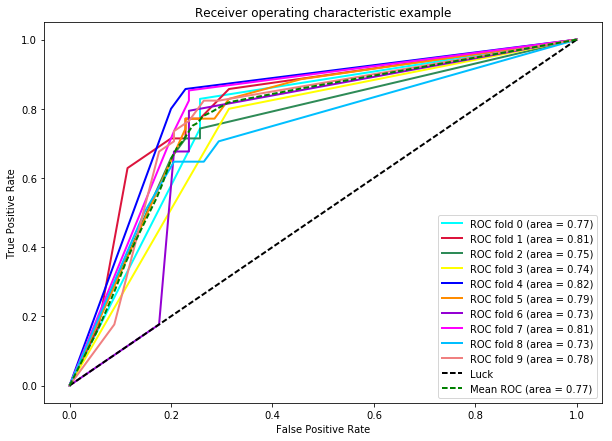

In [7]:
"""
Manual nested cross validation and ROC curve from that
"""

# ROC curve stuff
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
colors = cycle(['cyan', 'crimson', 'seagreen', 'yellow', 'blue', 'darkorange', 'darkviolet', 'fuchsia',
               'deepskyblue', 'lightcoral'])
lw = 2
i = 0



# Dividing data set for outer cv
cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 43)

precision_scores = []
recall_scores = []
f1_scores = []

# Outer cv
for (train, test), color in zip(cv_outer.split(temp_word_scaled, y_temp_word), colors):
    pipe_dect = Pipeline([('dect', DecisionTreeClassifier(random_state=1))])
    #param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
    param_grid = [{'dect__criterion': ['gini', 'entropy'], 'dect__max_depth': [3,4,5,6,7,8,9,10,None]},
             {'dect__criterion': ['gini', 'entropy'], 'dect__max_depth': [3,4,5,6,7,8,9,10,None],
             'dect__class_weight': ['balanced']}]
    
    #Inner cv
    cv_inner = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    gs = GridSearchCV(estimator=pipe_dect, param_grid=param_grid, scoring='f1', cv= cv_inner)
    
    gs.fit(temp_word_scaled[train], y_temp_word[train])
    
    print gs.best_params_
    
    scores = gs.best_estimator_.predict(temp_word_scaled[test])
    precision_s = precision_score(y_temp_word[test], scores)
    recall_s = recall_score(y_temp_word[test], scores)
    f1_s = f1_score(y_temp_word[test], scores)
    #print scores
    
    precision_scores.append(precision_s)
    recall_scores.append(recall_s)
    f1_scores.append(f1_s)
    print "Precision", precision_s
    print "Recall:", recall_s
    print "F1:", f1_s
    
    probas_ = gs.best_estimator_.predict_proba(temp_word_scaled[test])
    fpr, tpr, thresholds = roc_curve(y_temp_word[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i += 1
    #break
    
print np.mean(precision_scores), np.std(precision_scores) 
print np.mean(recall_scores), np.std(recall_scores)
print np.mean(f1_scores), np.std(f1_scores)

# Draw ROC curves
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv_outer.get_n_splits(temp_word_scaled, y_temp_word)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [11]:
"""
10 fold Manual nested cross validation 50 times

Loop: 0
Precision: 0.725200008496 0.0378454511801
Recall: 0.777899159664 0.0640235219998
F1: 0.749801570101 0.0452841926781
Loop: 1
Precision: 0.722826590024 0.0739792795386
Recall: 0.73731092437 0.05791031835
F1: 0.728788823921 0.0607513232765
Loop: 2
Precision: 0.750759243193 0.0492882771898
Recall: 0.763361344538 0.0996464337782
F1: 0.754150574079 0.0656021009423
Loop: 3
Precision: 0.714078813344 0.0613456153162
Recall: 0.749075630252 0.0711414893253
F1: 0.727286625778 0.038900252743
Loop: 4
Precision: 0.760047599459 0.0738045958188
Recall: 0.728571428571 0.0875023580543
F1: 0.741453671418 0.0664863551423
Loop: 5
Precision: 0.756724205858 0.0465103237456
Recall: 0.751596638655 0.0438204475338
F1: 0.752714614155 0.0301454167277
Loop: 6
Precision: 0.731825525654 0.063510336904
Recall: 0.783277310924 0.0922009591997
F1: 0.752779088692 0.0574530330859
Loop: 7
Precision: 0.723142997379 0.0479286460028
Recall: 0.734621848739 0.114072217786
F1: 0.726216752734 0.079452914143
Loop: 8
Precision: 0.716313886417 0.0811576254134
Recall: 0.76 0.0649424900262
F1: 0.733766363356 0.0538774572276
Loop: 9
Precision: 0.746547260328 0.0745770943217
Recall: 0.748655462185 0.079017919805
F1: 0.744276371483 0.0604965283691
Loop: 10
Precision: 0.72977807159 0.0285713913319
Recall: 0.740168067227 0.0806519582275
F1: 0.732850890078 0.0466872101757
Loop: 11
Precision: 0.757102259161 0.0973940558754
Recall: 0.762773109244 0.0811183831004
F1: 0.758411044162 0.0825614428082
Loop: 12
Precision: 0.732225713476 0.0377745632964
Recall: 0.791344537815 0.0682816934599
F1: 0.758921356681 0.0381326402498
Loop: 13
Precision: 0.717440651208 0.0549680094527
Recall: 0.73974789916 0.0563414514849
F1: 0.727277888394 0.0479301190145
Loop: 14
Precision: 0.705339523 0.0525412563486
Recall: 0.751260504202 0.0721016238621
F1: 0.726607302531 0.0567496718844
Loop: 15
Precision: 0.71882929624 0.0816942672268
Recall: 0.757478991597 0.064817321913
F1: 0.735175974738 0.0611681768889
Loop: 16
Precision: 0.762296723617 0.0646099396885
Recall: 0.731344537815 0.0781015926024
F1: 0.744558938734 0.0598915293113
Loop: 17
Precision: 0.711944717381 0.0492123951828
Recall: 0.742857142857 0.0911344440958
F1: 0.724096948061 0.0577251973964
Loop: 18
Precision: 0.743518919628 0.0425345300625
Recall: 0.743277310924 0.0996613501744
F1: 0.737637207694 0.0491102592931
Loop: 19
Precision: 0.720591585933 0.0707316791897
Recall: 0.754369747899 0.077592699878
F1: 0.735027367232 0.0620843167759
Loop: 20
Precision: 0.717560036165 0.0712409944395
Recall: 0.774369747899 0.0594234117879
F1: 0.744100906392 0.0618774066396
Loop: 21
Precision: 0.694126871166 0.0778637887045
Recall: 0.684621848739 0.139385929194
F1: 0.684347690993 0.0992126547915
Loop: 22
Precision: 0.727495895685 0.0866769993323
Recall: 0.776890756303 0.117542120065
F1: 0.746211349422 0.0814945897266
Loop: 23
Precision: 0.738711133803 0.0556715937181
Recall: 0.765378151261 0.0929464949015
F1: 0.745928163457 0.0364599133005
Loop: 24
Precision: 0.698028452915 0.057529597979
Recall: 0.763781512605 0.102474469393
F1: 0.723433607033 0.0578953994039
Loop: 25
Precision: 0.707274147212 0.0544788633344
Recall: 0.752016806723 0.0664423231345
F1: 0.72854210051 0.057950077273
Loop: 26
Precision: 0.748593394218 0.055172006868
Recall: 0.719495798319 0.0866604558151
F1: 0.730356958604 0.0532782714803
Loop: 27
Precision: 0.740425856048 0.0570209902226
Recall: 0.705462184874 0.100764852701
F1: 0.719500763568 0.0692851423422
Loop: 28
Precision: 0.740090415176 0.0486965434397
Recall: 0.739915966387 0.0995337268724
F1: 0.734260711143 0.0472140864131
Loop: 29
Precision: 0.729630093544 0.0765706888683
Recall: 0.743025210084 0.0955013826496
F1: 0.733608368014 0.0744405026216
Loop: 30
Precision: 0.737960998083 0.0649845080521
Recall: 0.701932773109 0.0808104995692
F1: 0.718551518104 0.0690911765775
Loop: 31
Precision: 0.734554237134 0.0583877968295
Recall: 0.736890756303 0.0582522681315
F1: 0.732614977652 0.033320976809
Loop: 32
Precision: 0.724053565047 0.067898231271
Recall: 0.751344537815 0.11230201922
F1: 0.733566673595 0.0753321444217
Loop: 33
Precision: 0.724974720963 0.0486989821886
Recall: 0.737226890756 0.0890891459542
F1: 0.729192342633 0.0609271815934
Loop: 34
Precision: 0.763311016408 0.0723717447082
Recall: 0.739831932773 0.104677147817
F1: 0.744911252956 0.0569206506301
Loop: 35
Precision: 0.705812252153 0.0408382164683
Recall: 0.76 0.0683252708093
F1: 0.728889667257 0.028592165954
Loop: 36
Precision: 0.743107448107 0.0803325460641
Recall: 0.754117647059 0.0976087227137
F1: 0.742723019988 0.0556934814638
Loop: 37
Precision: 0.7492421915 0.0433654020173
Recall: 0.743025210084 0.047957799871
F1: 0.744891880544 0.0352247189166
Loop: 38
Precision: 0.726424016791 0.0578083047838
Recall: 0.751344537815 0.0703943415467
F1: 0.737411518452 0.057243874124
Loop: 39
Precision: 0.742473492385 0.0642320710628
Recall: 0.805882352941 0.106227262695
F1: 0.769707135748 0.0710317753759
Loop: 40
Precision: 0.768283099276 0.0764106119237
Recall: 0.751260504202 0.0653098517754
F1: 0.755665460001 0.0453621501127
Loop: 41
Precision: 0.713775966035 0.050719961589
Recall: 0.756806722689 0.0913435714621
F1: 0.728911539973 0.0367800036767
Loop: 42
Precision: 0.718392582747 0.0479953068578
Recall: 0.713949579832 0.0555527653498
F1: 0.714705348951 0.0408831145356
Loop: 43
Precision: 0.754400514629 0.0610028868564
Recall: 0.763025210084 0.10407962491
F1: 0.752988918363 0.0558022238564
Loop: 44
Precision: 0.737105695791 0.104013673674
Recall: 0.701932773109 0.0878744522371
F1: 0.713045462025 0.0687606671635
Loop: 45
Precision: 0.71956075331 0.057848961657
Recall: 0.731008403361 0.0787663963089
F1: 0.721691945343 0.0467219352683
Loop: 46
Precision: 0.731324447599 0.0541622805269
Recall: 0.717731092437 0.13596132263
F1: 0.718629616738 0.0835758632188
Loop: 47
Precision: 0.747221138189 0.0634054287659
Recall: 0.748655462185 0.0688854750416
F1: 0.744078536459 0.0400835203737
Loop: 48
Precision: 0.723568186211 0.0708301615218
Recall: 0.76268907563 0.0805550619151
F1: 0.741177180483 0.0682872176952
Loop: 49
Precision: 0.743613107818 0.0662120900606
Recall: 0.762941176471 0.0664688884186
F1: 0.750915707185 0.0525444696241

Precision for 50 times: 0.73195258635 0.0152241018727
Recall for 50 times: 0.74731092437 0.0208841558964
F1 for 50 times: 0.736127193912 0.0150484461515
"""

colors = cycle(['cyan', 'crimson', 'seagreen', 'yellow', 'blue', 'darkorange', 'darkviolet', 'fuchsia',
               'deepskyblue', 'lightcoral'])

outer_random_seed_list = [3,13,23,33,43,53,63,73,83,93, 103,113,123,133,143,153,163,173,183,193,
                         203,213,223,233,243,253,263,273,283,293, 303,313,323,333,343,353,363,373,383,393,
                          403,413,423,433,443,453,463,473,483,493]
random_seed_list = [2,12,22,32,42,52,62,72,82,92, 102,112,122,132,142,152,162,172,182,192,
                   202,212,222,232,242,252,262,272,282,292, 302,312,322,332,342,352,362,372,382,392,
                   402,412,422,432,442,452,462,472,482,492]

precision_scores_mean_list = []
recall_scores_mean_list = []
f1_scores_mean_list = []

precision_scores_std_list = []
recall_scores_std_list = []
f1_scores_std_list = []

# Outer cv
for index, rand_seed_i in enumerate(random_seed_list):
    precision_scores = []
    recall_scores = []
    f1_scores = []
    cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = outer_random_seed_list[index])
    for (train, test), color in zip(cv_outer.split(temp_word_scaled, y_temp_word), colors):
        pipe_dect = Pipeline([('dect', DecisionTreeClassifier(random_state=1))])
        #param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
        param_grid = [{'dect__criterion': ['gini', 'entropy'], 'dect__max_depth': [3,4,5,6,7,8,9,10,None]},
             {'dect__criterion': ['gini', 'entropy'], 'dect__max_depth': [3,4,5,6,7,8,9,10,None],
             'dect__class_weight': ['balanced']}]


        #Inner cv
        cv_inner = StratifiedKFold(n_splits = 5, shuffle = True, random_state = rand_seed_i)
        gs = GridSearchCV(estimator=pipe_dect, param_grid=param_grid, scoring='f1', cv= cv_inner)

        gs.fit(temp_word_scaled[train], y_temp_word[train])

        #print gs.best_params_

        scores = gs.best_estimator_.predict(temp_word_scaled[test])
        precision_s = precision_score(y_temp_word[test], scores)
        recall_s = recall_score(y_temp_word[test], scores)
        f1_s = f1_score(y_temp_word[test], scores)
        #print scores

        precision_scores.append(precision_s)
        recall_scores.append(recall_s)
        f1_scores.append(f1_s)
    
    # These are the mean of the 10 folds of this particular iteration
    print 'Loop:', index
    print 'Precision:', np.mean(precision_scores), np.std(precision_scores) 
    print 'Recall:', np.mean(recall_scores), np.std(recall_scores)
    print 'F1:', np.mean(f1_scores), np.std(f1_scores)
    
    # Adding to a list, the mean score from each iteration, this list will hold 50
    # values from 50 iterations
    precision_scores_mean_list.append(np.mean(precision_scores))
    recall_scores_mean_list.append(np.mean(recall_scores))
    f1_scores_mean_list.append(np.mean(f1_scores))
    
print 'Precision mean for 50 times:', np.mean(precision_scores_mean_list), 'Std. error:', stats.sem(precision_scores_mean_list)
print 'Recall mean for 50 times:', np.mean(recall_scores_mean_list), 'Std. error:', stats.sem(recall_scores_mean_list)
print 'F1 mean for 50 times:', np.mean(f1_scores_mean_list), 'Std. error:', stats.sem(f1_scores_mean_list)

In [4]:
precision_scores_mean_list = [0.72520000849590072,
 0.72282659002356175,
 0.75075924319345366,
 0.71407881334351919,
 0.76004759945936429,
 0.75672420585814426,
 0.73182552565436088,
 0.72314299737899068,
 0.71631388641659766,
 0.7465472603277481,
 0.72977807158975083,
 0.75710225916108265,
 0.73222571347571352,
 0.71744065120838107,
 0.70533952299998526,
 0.71882929624013481,
 0.76229672361723488,
 0.71194471738082288,
 0.74351891962813776,
 0.72059158593264527,
 0.7175600361653458,
 0.69412687116640004,
 0.72749589568475026,
 0.73871113380320208,
 0.69802845291523385,
 0.70727414721222781,
 0.74859339421839421,
 0.74042585604830946,
 0.74009041517594154,
 0.72963009354415875,
 0.73796099808315174,
 0.7345542371340541,
 0.72405356504682572,
 0.72497472096265914,
 0.76331101640773036,
 0.7058122521532848,
 0.743107448107448,
 0.74924219150025606,
 0.72642401679076707,
 0.74247349238476623,
 0.76828309927574634,
 0.71377596603501403,
 0.7183925827465476,
 0.75440051462941571,
 0.73710569579070795,
 0.71956075330994973,
 0.73132444759862758,
 0.74722113818888014,
 0.72356818621056507,
 0.74361310781826617]
recall_scores_mean_list = [0.77789915966386558,
 0.73731092436974799,
 0.76336134453781512,
 0.74907563025210089,
 0.72857142857142865,
 0.75159663865546222,
 0.78327731092436981,
 0.73462184873949588,
 0.76000000000000001,
 0.748655462184874,
 0.74016806722689077,
 0.76277310924369746,
 0.79134453781512604,
 0.73974789915966388,
 0.75126050420168067,
 0.75747899159663867,
 0.73134453781512598,
 0.74285714285714288,
 0.74327731092436977,
 0.75436974789915967,
 0.77436974789915969,
 0.68462184873949572,
 0.77689075630252102,
 0.76537815126050412,
 0.76378151260504201,
 0.75201680672268911,
 0.71949579831932764,
 0.70546218487394952,
 0.73991596638655466,
 0.74302521008403366,
 0.70193277310924374,
 0.7368907563025211,
 0.751344537815126,
 0.73722689075630243,
 0.73983193277310932,
 0.76000000000000001,
 0.75411764705882356,
 0.74302521008403366,
 0.751344537815126,
 0.80588235294117649,
 0.75126050420168067,
 0.75680672268907556,
 0.71394957983193286,
 0.76302521008403357,
 0.70193277310924362,
 0.73100840336134454,
 0.71773109243697475,
 0.748655462184874,
 0.76268907563025201,
 0.76294117647058823]
f1_scores_mean_list = [0.74980157010071147,
 0.72878882392089817,
 0.75415057407909603,
 0.72728662577786529,
 0.74145367141766638,
 0.75271461415505569,
 0.75277908869241061,
 0.72621675273356534,
 0.73376636335552881,
 0.74427637148306069,
 0.7328508900778461,
 0.75841104416156901,
 0.7589213566813201,
 0.72727788839442853,
 0.72660730253144235,
 0.73517597473815965,
 0.74455893873350898,
 0.72409694806054259,
 0.73763720769441599,
 0.7350273672319958,
 0.74410090639151316,
 0.68434769099258008,
 0.74621134942191258,
 0.7459281634568945,
 0.72343360703274384,
 0.72854210050978896,
 0.73035695860445193,
 0.71950076356754433,
 0.7342607111425119,
 0.73360836801414175,
 0.71855151810394779,
 0.73261497765159644,
 0.73356667359488537,
 0.72919234263291333,
 0.74491125295555793,
 0.72888966725747451,
 0.74272301998779666,
 0.74489188054405431,
 0.73741151845226993,
 0.76970713574827754,
 0.75566546000146106,
 0.72891153997254854,
 0.71470534895087334,
 0.75298891836298609,
 0.71304546202522645,
 0.72169194534299952,
 0.71862961673758496,
 0.74407853645855737,
 0.74117718048261438,
 0.75091570718526379]

print 'Precision mean for 50 times:', np.mean(precision_scores_mean_list), 'Std. error:', stats.sem(precision_scores_mean_list)
print 'Recall mean for 50 times:', np.mean(recall_scores_mean_list), 'Std. error:', stats.sem(recall_scores_mean_list)
print 'F1 mean for 50 times:', np.mean(f1_scores_mean_list), 'Std. error:', stats.sem(f1_scores_mean_list)

Precision mean for 50 times: 0.73195258635 Std. error: 0.00249729749572
Recall mean for 50 times: 0.74731092437 Std. error: 0.00325431204758
F1 mean for 50 times: 0.736127193912 Std. error: 0.00207790238933


In [13]:
recall_scores_mean_list

[0.77789915966386558,
 0.73731092436974799,
 0.76336134453781512,
 0.74907563025210089,
 0.72857142857142865,
 0.75159663865546222,
 0.78327731092436981,
 0.73462184873949588,
 0.76000000000000001,
 0.748655462184874,
 0.74016806722689077,
 0.76277310924369746,
 0.79134453781512604,
 0.73974789915966388,
 0.75126050420168067,
 0.75747899159663867,
 0.73134453781512598,
 0.74285714285714288,
 0.74327731092436977,
 0.75436974789915967,
 0.77436974789915969,
 0.68462184873949572,
 0.77689075630252102,
 0.76537815126050412,
 0.76378151260504201,
 0.75201680672268911,
 0.71949579831932764,
 0.70546218487394952,
 0.73991596638655466,
 0.74302521008403366,
 0.70193277310924374,
 0.7368907563025211,
 0.751344537815126,
 0.73722689075630243,
 0.73983193277310932,
 0.76000000000000001,
 0.75411764705882356,
 0.74302521008403366,
 0.751344537815126,
 0.80588235294117649,
 0.75126050420168067,
 0.75680672268907556,
 0.71394957983193286,
 0.76302521008403357,
 0.70193277310924362,
 0.73100840336134

In [14]:
f1_scores_mean_list

[0.74980157010071147,
 0.72878882392089817,
 0.75415057407909603,
 0.72728662577786529,
 0.74145367141766638,
 0.75271461415505569,
 0.75277908869241061,
 0.72621675273356534,
 0.73376636335552881,
 0.74427637148306069,
 0.7328508900778461,
 0.75841104416156901,
 0.7589213566813201,
 0.72727788839442853,
 0.72660730253144235,
 0.73517597473815965,
 0.74455893873350898,
 0.72409694806054259,
 0.73763720769441599,
 0.7350273672319958,
 0.74410090639151316,
 0.68434769099258008,
 0.74621134942191258,
 0.7459281634568945,
 0.72343360703274384,
 0.72854210050978896,
 0.73035695860445193,
 0.71950076356754433,
 0.7342607111425119,
 0.73360836801414175,
 0.71855151810394779,
 0.73261497765159644,
 0.73356667359488537,
 0.72919234263291333,
 0.74491125295555793,
 0.72888966725747451,
 0.74272301998779666,
 0.74489188054405431,
 0.73741151845226993,
 0.76970713574827754,
 0.75566546000146106,
 0.72891153997254854,
 0.71470534895087334,
 0.75298891836298609,
 0.71304546202522645,
 0.721691945342

## Random Forest

In [7]:
"""
Nested cv

CV f1: 0.814 (+/- 0.041)
[ 0.81818182  0.78873239  0.85333333  0.82857143  0.84931507  0.84615385
  0.72727273  0.7761194   0.78787879  0.86153846]

"""

pipe_randf = Pipeline([('randf', RandomForestClassifier(random_state=1))])
#param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'randf__n_estimators': [10, 13, 15, 17, 20], 'randf__criterion': ['gini', 'entropy'], 
               'randf__max_depth': [3,4,5,6,7,8,9,10,None]},
             {'randf__n_estimators': [10, 13, 15, 17, 20], 'randf__criterion': ['gini', 'entropy'], 
              'randf__max_depth': [3,4,5,6,7,8,9,10,None], 'randf__class_weight': ['balanced']}]

cv_inner = StratifiedKFold(n_splits= 5, shuffle=True, random_state=42)
cv_outer = StratifiedKFold(n_splits= 10, shuffle=True, random_state=43)
gs = GridSearchCV(estimator=pipe_randf, param_grid=param_grid, scoring='f1', cv= cv_inner)
scores = cross_val_score(gs, temp_word_scaled, y_temp_word, cv=cv_outer, scoring = 'f1')

print('CV f1: %.3f (+/- %.3f)' % (np.mean(scores), np.std(scores))) 
print scores

In [9]:
gs.get_params

<bound method GridSearchCV.get_params of GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=Pipeline(steps=[('randf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'randf__criterion': ['gini', 'entropy'], 'randf__n_estimators': [10, 13, 15, 17, 20], 'randf__max_depth': [3, 4, 5, 6, 7, 8, 9, 10, None]}, {'randf__criterion': ['gini', 'entropy'], 'randf__n_estimators': [10, 13, 15, 17, 20], 'randf__max_depth': [3, 4, 5, 6, 7, 8, 9, 10, None], 'randf__class_weight': ['balanced']}],
       pre_dispatch='2*n_jobs', refit=True, ret

{'randf__n_estimators': 20, 'randf__criterion': 'entropy', 'randf__max_depth': 7}
Precision 0.870967741935
Recall: 0.771428571429
F1: 0.818181818182
{'randf__n_estimators': 15, 'randf__criterion': 'gini', 'randf__max_depth': 6}
Precision 0.777777777778
Recall: 0.8
F1: 0.788732394366
{'randf__n_estimators': 20, 'randf__criterion': 'entropy', 'randf__max_depth': 7}
Precision 0.8
Recall: 0.914285714286
F1: 0.853333333333
{'randf__n_estimators': 15, 'randf__criterion': 'entropy', 'randf__max_depth': 9}
Precision 0.828571428571
Recall: 0.828571428571
F1: 0.828571428571
{'randf__n_estimators': 15, 'randf__criterion': 'entropy', 'randf__max_depth': None}
Precision 0.815789473684
Recall: 0.885714285714
F1: 0.849315068493
{'randf__n_estimators': 17, 'randf__criterion': 'entropy', 'randf__max_depth': 8}
Precision 0.767441860465
Recall: 0.942857142857
F1: 0.846153846154
{'randf__n_estimators': 17, 'randf__criterion': 'entropy', 'randf__max_depth': None}
Precision 0.75
Recall: 0.705882352941
F1: 0

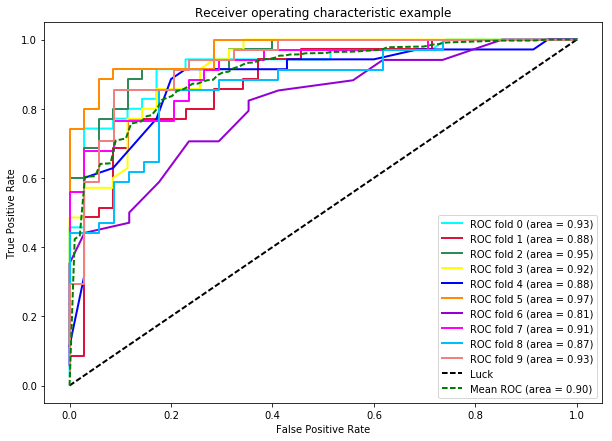

In [8]:
"""
Manual nested cross validation and ROC curve from that
"""

# ROC curve stuff
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
colors = cycle(['cyan', 'crimson', 'seagreen', 'yellow', 'blue', 'darkorange', 'darkviolet', 'fuchsia',
               'deepskyblue', 'lightcoral'])
lw = 2
i = 0



# Dividing data set for outer cv
cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 43)

precision_scores = []
recall_scores = []
f1_scores = []

# Outer cv
for (train, test), color in zip(cv_outer.split(temp_word_scaled, y_temp_word), colors):
    pipe_randf = Pipeline([('randf', RandomForestClassifier(random_state=1))])
    #param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
    param_grid = [{'randf__n_estimators': [10, 13, 15, 17, 20], 'randf__criterion': ['gini', 'entropy'], 
               'randf__max_depth': [3,4,5,6,7,8,9,10,None]},
             {'randf__n_estimators': [10, 13, 15, 17, 20], 'randf__criterion': ['gini', 'entropy'], 
              'randf__max_depth': [3,4,5,6,7,8,9,10,None], 'randf__class_weight': ['balanced']}]
    #Inner cv
    cv_inner = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    gs = GridSearchCV(estimator=pipe_randf, param_grid=param_grid, scoring='f1', cv= cv_inner)
    
    gs.fit(temp_word_scaled[train], y_temp_word[train])
    
    print gs.best_params_
    
    scores = gs.best_estimator_.predict(temp_word_scaled[test])
    precision_s = precision_score(y_temp_word[test], scores)
    recall_s = recall_score(y_temp_word[test], scores)
    f1_s = f1_score(y_temp_word[test], scores)
    #print scores
    
    precision_scores.append(precision_s)
    recall_scores.append(recall_s)
    f1_scores.append(f1_s)
    print "Precision", precision_s
    print "Recall:", recall_s
    print "F1:", f1_s
    
    probas_ = gs.best_estimator_.predict_proba(temp_word_scaled[test])
    fpr, tpr, thresholds = roc_curve(y_temp_word[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i += 1
    #break
    
print np.mean(precision_scores), np.std(precision_scores) 
print np.mean(recall_scores), np.std(recall_scores)
print np.mean(f1_scores), np.std(f1_scores)

# Draw ROC curves
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv_outer.get_n_splits(temp_word_scaled, y_temp_word)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [7]:
"""
10 fold Manual nested cross validation 50 times

Precision mean for 50 times: 0.82080014791 Std. error: 0.00158100355235
Recall mean for 50 times: 0.813378151261 Std. error: 0.00222232197977
F1 mean for 50 times: 0.814986764965 Std. error: 0.00147923398584

"""

colors = cycle(['cyan', 'crimson', 'seagreen', 'yellow', 'blue', 'darkorange', 'darkviolet', 'fuchsia',
               'deepskyblue', 'lightcoral'])

outer_random_seed_list = [3,13,23,33,43,53,63,73,83,93, 103,113,123,133,143,153,163,173,183,193,
                         203,213,223,233,243,253,263,273,283,293, 303,313,323,333,343,353,363,373,383,393,
                          403,413,423,433,443,453,463,473,483,493]
random_seed_list = [2,12,22,32,42,52,62,72,82,92, 102,112,122,132,142,152,162,172,182,192,
                   202,212,222,232,242,252,262,272,282,292, 302,312,322,332,342,352,362,372,382,392,
                   402,412,422,432,442,452,462,472,482,492]

precision_scores_mean_list = []
recall_scores_mean_list = []
f1_scores_mean_list = []

precision_scores_std_list = []
recall_scores_std_list = []
f1_scores_std_list = []

# Outer cv
for index, rand_seed_i in enumerate(random_seed_list):
    precision_scores = []
    recall_scores = []
    f1_scores = []
    cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = outer_random_seed_list[index])
    for (train, test), color in zip(cv_outer.split(temp_word_scaled, y_temp_word), colors):
        pipe_randf = Pipeline([('randf', RandomForestClassifier(random_state=1))])
        #param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
        param_grid = [{'randf__n_estimators': [10, 13, 15, 17, 20], 'randf__criterion': ['gini', 'entropy'], 
               'randf__max_depth': [3,4,5,6,7,8,9,10,None]},
             {'randf__n_estimators': [10, 13, 15, 17, 20], 'randf__criterion': ['gini', 'entropy'], 
              'randf__max_depth': [3,4,5,6,7,8,9,10,None], 'randf__class_weight': ['balanced']}]


        #Inner cv
        cv_inner = StratifiedKFold(n_splits = 5, shuffle = True, random_state = rand_seed_i)
        gs = GridSearchCV(estimator=pipe_randf, param_grid=param_grid, scoring='f1', cv= cv_inner)

        gs.fit(temp_word_scaled[train], y_temp_word[train])

        #print gs.best_params_

        scores = gs.best_estimator_.predict(temp_word_scaled[test])
        precision_s = precision_score(y_temp_word[test], scores)
        recall_s = recall_score(y_temp_word[test], scores)
        f1_s = f1_score(y_temp_word[test], scores)
        #print scores

        precision_scores.append(precision_s)
        recall_scores.append(recall_s)
        f1_scores.append(f1_s)
    
    # These are the mean of the 10 folds of this particular iteration
    print 'Loop:', index
    print 'Precision:', np.mean(precision_scores), np.std(precision_scores) 
    print 'Recall:', np.mean(recall_scores), np.std(recall_scores)
    print 'F1:', np.mean(f1_scores), np.std(f1_scores)
    
    # Adding to a list, the mean score from each iteration, this list will hold 50
    # values from 50 iterations
    precision_scores_mean_list.append(np.mean(precision_scores))
    recall_scores_mean_list.append(np.mean(recall_scores))
    f1_scores_mean_list.append(np.mean(f1_scores))
    
print 'Precision mean for 50 times:', np.mean(precision_scores_mean_list), 'Std. error:', stats.sem(precision_scores_mean_list)
print 'Recall mean for 50 times:', np.mean(recall_scores_mean_list), 'Std. error:', stats.sem(recall_scores_mean_list)
print 'F1 mean for 50 times:', np.mean(f1_scores_mean_list), 'Std. error:', stats.sem(f1_scores_mean_list)

In [8]:
precision_scores_mean_list

[0.82477526825345537,
 0.81103575711934839,
 0.83244475850225874,
 0.81405237632791805,
 0.81062133026579242,
 0.82305477857075215,
 0.79813715868594526,
 0.80852343847200525,
 0.81054993221054927,
 0.81802155459029113,
 0.82511502073074605,
 0.83000152043795306,
 0.81586059391806898,
 0.79850251927909344,
 0.81799483854749511,
 0.82201059420633449,
 0.81463947890031485,
 0.82383078840355706,
 0.82437011269928484,
 0.81871512997388152,
 0.84312134850060549,
 0.82823473864189834,
 0.82863735282353124,
 0.81582348057717125,
 0.80769514641031681,
 0.81500980637010056,
 0.83956751394251405,
 0.82505917130205542,
 0.82549296744661671,
 0.79272767497867558,
 0.82228945429103517,
 0.8181868769012981,
 0.83807726173091202,
 0.82293244588466585,
 0.81649782809609517,
 0.81351243465340828,
 0.83013943549547253,
 0.83663011155316203,
 0.83798033300082575,
 0.82319060664648891,
 0.82420864802184446,
 0.84857344905394938,
 0.812194818143125,
 0.83034708519035139,
 0.81342468902823595,
 0.8224272533

In [9]:
recall_scores_mean_list

[0.8125210084033615,
 0.82394957983193273,
 0.8294117647058824,
 0.8036974789915966,
 0.79689075630252104,
 0.78638655462184881,
 0.80033613445378149,
 0.83193277310924374,
 0.81159663865546217,
 0.82075630252100851,
 0.81218487394957983,
 0.82025210084033606,
 0.83554621848739496,
 0.81781512605042006,
 0.8125210084033615,
 0.78613445378151259,
 0.78873949579831937,
 0.81210084033613439,
 0.83529411764705874,
 0.81504201680672261,
 0.82327731092436984,
 0.80596638655462183,
 0.81739495798319317,
 0.8123529411764705,
 0.83016806722689063,
 0.80092436974789938,
 0.80647058823529405,
 0.80344537815126049,
 0.80630252100840338,
 0.78058823529411758,
 0.84058823529411764,
 0.82941176470588229,
 0.80310924369747894,
 0.78588235294117648,
 0.81201680672268906,
 0.81521008403361339,
 0.85554621848739509,
 0.82369747899159651,
 0.81781512605042006,
 0.80025210084033616,
 0.81747899159663862,
 0.80588235294117649,
 0.80352941176470583,
 0.81470588235294117,
 0.83235294117647052,
 0.826722689075

In [10]:
f1_scores_mean_list

[0.81577464447317394,
 0.81663654033849631,
 0.82855153469747012,
 0.80784383376823377,
 0.80123113226671072,
 0.80358559783813632,
 0.79725536992641499,
 0.81874211661620233,
 0.80953430832277784,
 0.8172820928052662,
 0.81704352581389639,
 0.82344834623549745,
 0.82302505249124691,
 0.80552606387130576,
 0.81365669154700626,
 0.80327376800522587,
 0.80040256757277284,
 0.81498684368483887,
 0.82844948924843576,
 0.8150956644941264,
 0.83063465587816121,
 0.8144660736660525,
 0.82123676553325775,
 0.81199852740519574,
 0.81482882473781026,
 0.80625111404070604,
 0.82115406689581949,
 0.81268468355008117,
 0.81322942412597321,
 0.7832749144765293,
 0.82870424180622015,
 0.82223453555459236,
 0.81726195258099976,
 0.80041258202574073,
 0.81257017803864107,
 0.81221442599979032,
 0.84125858008354459,
 0.82850439325286018,
 0.82633614512185094,
 0.8100209311746811,
 0.81835150836429604,
 0.82507226223152874,
 0.80489602231012591,
 0.82043525712727605,
 0.820621861619796,
 0.82293347735580

## Xgboost

In [81]:
encoded_imgs.shape

(778, 16)

In [26]:
"""
Grid Search for parameters

x_word_scaled_minmax and x_word_scaled and x_word
0.838354952856
{'xgb__gamma': 1, 'xgb__max_depth': 4, 'xgb__min_child_weight': 3}

overlapping for classification gives better scores than non-overlapping
0.754589275579 for non-overlapping with bacteria word vector
0.81 for overlapping with bacteria word vector
"""
#del StratifiedKFold
from sklearn.grid_search import GridSearchCV
from xgboost import XGBClassifier
from sklearn.cross_validation import StratifiedKFold

gamm = range(0,11)
max_dep = range(1, 8)
min_weight = range(1, 11)
pipe_xgb = Pipeline([('xgb', XGBClassifier())])
#param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'xgb__gamma': gamm, 'xgb__min_child_weight': max_dep, 
               'xgb__max_depth': min_weight}]

cv = StratifiedKFold(np.reshape(y_word, (y_word.shape[0], )), n_folds= 5, shuffle=True, 
                     random_state=42)
gs = GridSearchCV(estimator=pipe_xgb, param_grid=param_grid, scoring='f1', cv= cv)
gs = gs.fit(x_word_scaled, y_word)

print(gs.best_score_)
print(gs.best_params_)

In [153]:
"""
Doing cross validation and checking precision, recall, F1 score

x_word_scaled_minmax and x_word_scaled and x_word
F1: [ 0.88050314  0.83333333  0.83333333  0.80254777  0.84210526]
Recall: [ 0.8974359   0.83333333  0.83333333  0.80769231  0.83116883]
Precision: [ 0.86419753  0.83333333  0.83333333  0.79746835  0.85333333]
"""
from sklearn.model_selection import cross_val_score
xgb_cl = XGBClassifier(gamma = 1, min_child_weight = 3, max_depth = 4)
cv = StratifiedKFold(np.reshape(y_word, (y_word.shape[0], )), n_folds= 5, shuffle=True, random_state=42)

f1_scores = cross_val_score(xgb_cl, x_word_scaled, y_word, cv=cv, scoring = 'f1')
recall_scores = cross_val_score(xgb_cl, x_word_scaled, y_word, cv=cv, scoring = 'recall')
precision_scores = cross_val_score(xgb_cl, x_word_scaled, y_word, cv=cv, scoring = 'precision')

print 'F1:', f1_scores
print 'Recall:', recall_scores
print 'Precision:', precision_scores

In [154]:
"""
x_word_scaled_minmax and x_word_scaled and x_word
0.838364569036
0.840592740593
0.836333177059
"""
print f1_scores.mean()
print recall_scores.mean()
print precision_scores.mean()

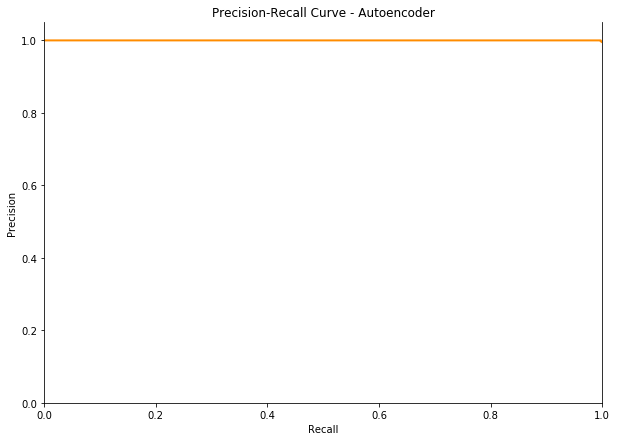

In [241]:
fig, ax = plt.subplots()
#ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

#fig.clf()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_ylim([0.0, 1.05])
ax.set_xlim([0.0, 1.0])
ax.set_title('Precision-Recall Curve - Autoencoder')

classifier = XGBClassifier(gamma = 1, min_child_weight = 3, max_depth = 4)
classifier.fit(x_word_scaled, y_word)
scores = classifier.predict_proba(x_word_scaled)
precision, recall, thresholds = precision_recall_curve(y_word, scores[:, 1], pos_label = 1)
ax.plot(recall, precision, lw = 2, color='darkorange',
         label='GB')

plt.show()

In [244]:
recall

array([ 1.        ,  0.99742931,  0.99742931,  0.99485861,  0.99228792,
        0.98971722,  0.98714653,  0.98457584,  0.98200514,  0.97943445,
        0.97686375,  0.97429306,  0.97172237,  0.96915167,  0.96658098,
        0.96401028,  0.96143959,  0.95886889,  0.9562982 ,  0.95372751,
        0.95115681,  0.94858612,  0.94601542,  0.94344473,  0.94087404,
        0.93830334,  0.93573265,  0.93316195,  0.93059126,  0.92802057,
        0.92544987,  0.92287918,  0.92030848,  0.91773779,  0.9151671 ,
        0.9125964 ,  0.91002571,  0.90745501,  0.90488432,  0.90231362,
        0.89974293,  0.89717224,  0.89460154,  0.89203085,  0.88946015,
        0.88688946,  0.88431877,  0.88174807,  0.87917738,  0.87660668,
        0.87403599,  0.8714653 ,  0.8688946 ,  0.86632391,  0.86375321,
        0.86118252,  0.85861183,  0.85604113,  0.85347044,  0.85089974,
        0.84832905,  0.84575835,  0.84318766,  0.84061697,  0.83804627,
        0.83547558,  0.83290488,  0.83033419,  0.8277635 ,  0.82

## NN

In [40]:
autoencoder_4000_bn.load_weights('weights-encoder-4000_BN-0.3GN-09-0.0608.hdf5')
autoencoder_1000_bn.load_weights('weights-encoder-1000_BN-0.3GN-04-0.2479.hdf5')
autoencoder_50_bn.load_weights('weights-encoder-50_BN-0.1GN-24-0.1560.hdf5')

In [9]:
def create_nn(neuron_num, dr_rate):
    nn = None
    # autoencoder_4000_bn.load_weights('weights-encoder-4000_BN-0.3GN-09-0.0608.hdf5')
    # autoencoder_1000_bn.load_weights('weights-encoder-1000_BN-0.3GN-04-0.2479.hdf5')
    # autoencoder_50_bn.load_weights('weights-encoder-50_BN-0.1GN-24-0.1560.hdf5')

    input_ = Input(shape=(100,))
    #encoded = Dropout(0.7)(input_)
    #encoded = encoder_4000_bn(input_)
    #encoded = Dropout(0.5)(encoded)
    #encoded = encoder_1000_bn(encoded)
    #encoded = Dropout(0.3)(encoded)
    #encoded = encoder_50_bn(encoded)
    #encoded = Dropout(0.1)(encoded)
    encoded = Dense(neuron_num)(input_)
    encoded = BatchNormalization()(encoded)
    encoded = Activation('relu')(encoded)
    encoded = Dropout(dr_rate)(encoded)
    encoded = Dense(1, activation = 'sigmoid')(encoded)

    nn = Model(input = input_, output = encoded)

    nn.compile(optimizer= Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    return nn

In [145]:
nn.summary()

In [153]:
nn.compile(optimizer= Adam(), loss='binary_crossentropy', metrics=['accuracy'])
earl = EarlyStopping(monitor = 'val_acc')

In [154]:
nn.fit(fragment_x_word_scaled_d, y_fragment_word,
                nb_epoch = 50,
                batch_size = 64,
                shuffle = True,
                validation_split = 0.2,
                callbacks = [earl])

In [10]:
"""
Results: 79.93% (4.54%)
[ 0.82051283  0.7948718   0.79487181  0.84615386  0.70512821  0.84615386
  0.78205129  0.82051283  0.84615385  0.73684211]
"""
hidden_layer_neuron = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]
dropout_rate_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

labels = y_temp_word.reshape(y_temp_word.shape[0],)
kfold = StratifiedKFold(np.reshape(y_temp_word, (y_temp_word.shape[0], )), n_folds = 10, shuffle = True, 
                                random_state = seed)

#for neuron_num in hidden_layer_neuron:
#    for dr_rate in dropout_rate_list:
estimator = None
estimator = KerasClassifier(build_fn = create_nn, neuron_num = 40, dr_rate = 0.7,
                            nb_epoch = 100, batch_size = 32, 
                            verbose = 0)

#print estimator
results = cross_val_score(estimator, temp_word_scaled, labels, cv = kfold)
#print "Neuron_num:", neuron_num, "Dropout:", dr_rate
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

NameError: name 'neuron_num' is not defined

In [18]:
"""
Manual cross-validation
"""
def create_model():
    nn = None
    # autoencoder_4000_bn.load_weights('weights-encoder-4000_BN-0.3GN-09-0.0608.hdf5')
    # autoencoder_1000_bn.load_weights('weights-encoder-1000_BN-0.3GN-04-0.2479.hdf5')
    # autoencoder_50_bn.load_weights('weights-encoder-50_BN-0.1GN-24-0.1560.hdf5')

    input_ = Input(shape=(100,))
    encoded = Dropout(0.4)(input_)
    #encoded = encoder_4000_bn(input_)
    #encoded = Dropout(0.5)(encoded)
    #encoded = encoder_1000_bn(encoded)
    #encoded = Dropout(0.3)(encoded)
    #encoded = encoder_50_bn(encoded)
    #encoded = Dropout(0.1)(encoded)
    encoded = Dense(40)(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Activation('relu')(encoded)
    encoded = Dropout(0.2)(encoded)
    encoded = Dense(1, activation = 'sigmoid')(encoded)

    nn = Model(input = input_, output = encoded)

    nn.compile(optimizer= Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    return nn

models_precision_list = []
models_recall_list = []
models_f1_list = []
def train_and_evaluate_model(model, train_set, train_label, test_set, test_label):
#     print "tr", tr.shape
#     print "tr_l", tr_l.shape
#     print "tr_te", tr_te.shape
#     print "tr_te_l", tr_te_l.shape
    model.fit(train_set, train_label, nb_epoch = 50,
                batch_size = 32,
                shuffle = True,
                verbose = 0)
    #tr_te = np.ravel(tr_te)
    scores = model.predict(test_set)
    scores_classes = np_utils.probas_to_classes(scores)
    print(metrics.classification_report(test_label, scores_classes))
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    precision = metrics.precision_score(test_label, scores_classes)
    recall = metrics.recall_score(test_label, scores_classes)
    f1 = metrics.f1_score(test_label, scores_classes)
    models_precision_list.append(precision)
    models_recall_list.append(recall)
    models_f1_list.append(f1)
    #models_logis_c.append(model)
    # fit and evaluate here.


    
#skf = KFold(1040, n_folds=10, shuffle=True)
skf = StratifiedKFold(np.reshape(y_temp_word, (y_temp_word.shape[0], )), n_folds=5, shuffle=True, random_state=42)
#print skf

for i, (train, test) in enumerate(skf):
    print "Running Fold", i+1, "/", 5
    model = None # Clearing the NN.
    model = create_model()
    print train.shape, test.shape
    train_and_evaluate_model(model, temp_word_scaled[train], y_temp_word[train], temp_word_scaled[test], 
                             y_temp_word[test])
    
print "F1"
print models_f1_list
print np.mean(models_f1_list)
print "Recall"
print models_recall_list
print np.mean(models_recall_list)
print "Precision"
print models_precision_list
print np.mean(models_precision_list)

In [37]:
KerasClassifier??

In [11]:
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
print results

In [63]:
print y_train.shape
print x_train.shape

In [80]:
xx = nn.predict_on_batch(anti_data_set_array)

In [81]:
print xx.shape

In [82]:
xx[xx < 0.5]

(408,)

In [95]:
y_classes = np_utils.probas_to_classes(xx)
print metrics.classification_report(y_antibp, y_classes)

In [91]:
y_test[y_test == 1].shape
y_train.shape

(544, 1)

In [98]:
xy = nn.predict_on_batch(whole_data_set_array)

In [99]:
y_classes = np_utils.probas_to_classes(xy)
print metrics.classification_report(y, y_classes)

In [102]:
neg_antibp_array.shape

(999, 8000)

## Word-vectors

In [2]:
new_model = gensim.models.Word2Vec.load('my_wordvec_model_trembl_size_200')

2017-12-12 16:03:42,834 : INFO : loading Word2Vec object from my_wordvec_model_trembl_size_200
2017-12-12 16:03:42,896 : INFO : loading wv recursively from my_wordvec_model_trembl_size_200.wv.* with mmap=None
2017-12-12 16:03:42,898 : INFO : setting ignored attribute syn0norm to None
2017-12-12 16:03:42,899 : INFO : setting ignored attribute cum_table to None
2017-12-12 16:03:42,900 : INFO : loaded my_wordvec_model_trembl_size_200


In [3]:
df = pd.read_csv('protVec_100d_3grams_new.csv', sep = '\t', header = None)

#df.values
#df.columns.values[0] = 'trigram_name'

df = df.set_index(0)
df.head(10)

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,,,,,,,,,,,,,,,,,,,,,
AAA,-0.174060,-0.095756,0.059515,0.039673,-0.375934,-0.115415,0.090725,0.173422,0.292520,0.190375,...,0.244482,0.015974,0.012903,0.137528,0.138140,0.005474,0.070719,-0.164084,-0.179274,0.184899
ALA,-0.114085,-0.093288,0.155800,-0.037351,-0.121446,0.084037,0.023819,0.093442,0.143256,0.044627,...,0.075584,-0.139661,0.034863,0.056078,0.028975,-0.012233,0.059669,0.037811,-0.172493,0.074655
LLL,-0.075594,-0.100834,-0.046616,-0.208980,-0.008596,-0.038612,-0.049360,0.060720,-0.062662,-0.155879,...,0.174677,-0.175961,-0.193242,-0.072965,-0.075560,0.158286,-0.026378,0.037155,-0.176038,0.319293
LAA,-0.137546,-0.135425,0.121566,-0.038295,-0.212129,0.040009,0.078545,0.029837,0.138343,0.049377,...,0.133947,-0.156484,-0.048541,0.141848,0.081842,0.070573,0.006927,0.035281,-0.138971,0.105997
AAL,-0.156112,-0.133524,0.114426,-0.020264,-0.058513,0.057005,0.076881,0.054781,0.129436,0.019448,...,0.154597,-0.050440,0.054866,0.066185,0.017498,0.001773,-0.083944,-0.003867,-0.106367,0.070706
ALL,-0.056191,-0.144594,0.043214,-0.146754,-0.058094,0.024076,0.074966,-0.028923,0.056939,0.104797,...,0.127284,-0.136185,0.018533,-0.021787,0.018663,-0.045316,-0.015182,0.043806,-0.066563,0.159971
LLA,-0.177890,-0.001898,0.032638,-0.053407,-0.036736,-0.021239,-0.013052,-0.026865,0.029256,0.061432,...,0.106187,-0.136744,-0.021721,-0.010791,0.001195,0.059006,-0.080312,0.075235,-0.109046,0.123678
LAL,-0.188611,-0.002185,0.108836,-0.126098,-0.001931,-0.017215,-0.056647,0.043682,0.039895,-0.084752,...,0.142023,-0.155075,-0.020684,0.017047,0.090200,-0.026145,0.027764,0.055355,-0.167330,0.201886
SSS,0.012405,-0.368833,-0.368951,-0.212781,-0.227907,-0.243726,0.056344,-0.137908,0.083584,-0.105236,...,0.315106,0.290427,0.173865,0.038017,0.129015,0.026049,0.117615,-0.661962,-0.036233,-0.178995


In [113]:
df.loc['MIF'].values + df.loc['IFD'].values + df.loc['FDG'].values

array([-0.194646,  0.566141,  0.085759, -0.278939, -0.032068, -0.094009,
        0.090095, -0.06948 ,  0.048231,  0.161589, -0.259066,  0.111125,
       -0.332696, -0.066684, -0.23692 ,  0.05667 ,  0.339666, -0.249286,
       -0.353126, -0.100422,  0.146973, -0.228246, -0.426907, -0.049088,
       -0.232575, -0.03855 ,  0.10989 ,  0.310837,  0.215447,  0.118016,
        0.452972, -0.205597,  0.365209,  0.144382, -0.051229,  0.209062,
       -0.264074,  0.124904, -0.0063  , -0.150806,  0.233231,  0.202478,
       -0.018369,  0.256884,  0.135295,  0.025753, -0.187603, -0.150294,
        0.182788,  0.060735, -0.173932, -0.449596,  0.359696, -0.225687,
        0.079988, -0.370969, -0.074777, -0.492979, -0.132874, -0.124287,
       -0.179274,  0.001392, -0.247667,  0.031665,  0.084783, -0.183536,
       -0.375403,  0.085785,  0.116827, -0.057196, -0.051036,  0.092489,
       -0.035938, -0.068559,  0.269924, -0.001679,  0.024075,  0.111323,
        0.02853 , -0.074064,  0.189984, -0.169092, 

In [81]:
fragment_x_word = np.zeros(shape=(531,100))
for index, record in enumerate(SeqIO.parse('whole_bacteriocin_set_without_fragments_length_more_than_21', 'fasta')):
    sum_of_sequence = 0
    tri_tokens = trigrams(record.seq)
    for item in ((tri_tokens)):
        tri_str = item[0] + item[1] + item[2]
        if tri_str not in list(df.index):
            continue
        #print tri_str
        #print 
        sum_of_sequence += new_model[tri_str]
    fragment_x_word[index] = sum_of_sequence
    

print "Done"
y_fragment_word = np.vstack((np.ones((245, 1)), 
                    np.zeros((286,1))))

print y_fragment_word.shape

scaler = preprocessing.StandardScaler().fit(fragment_x_word)
fragment_word_scaled = scaler.transform(fragment_x_word)

min_max_scaler = preprocessing.MinMaxScaler()
fragment_word_scaled_minmax = min_max_scaler.fit_transform(fragment_word_scaled)

In [11]:
antibp_x_word = np.zeros(shape=(1998,100))
for index, record in enumerate(SeqIO.parse('whole_antibp_data.fa', 'fasta')):
    sum_of_sequence = 0
    tri_tokens = trigrams(record.seq)
    for item in ((tri_tokens)):
        tri_str = item[0] + item[1] + item[2]
        if tri_str not in list(new_model.wv.vocab):
            continue
        #print tri_str
        #print 
        sum_of_sequence += new_model[tri_str]
    antibp_x_word[index] = sum_of_sequence
    

print "Done"
y_antibp_word = np.vstack((np.ones((999, 1)), 
                    np.zeros((999,1))))

print y_antibp_word.shape

scaler = preprocessing.StandardScaler().fit(antibp_x_word)
antibp_x_word_scaled = scaler.transform(antibp_x_word)

min_max_scaler = preprocessing.MinMaxScaler()
antibp_x_word_scaled_minmax = min_max_scaler.fit_transform(antibp_x_word_scaled)

In [4]:
import time
t0 = time.time()

temp_word = np.zeros(shape=(692,200))
for index, record in enumerate(SeqIO.parse('less_than_30_pos_neg_bacteriocin.fa', 'fasta')):
    sum_of_sequence = 0
    tri_tokens = trigrams(record.seq)
    for item in ((tri_tokens)):
        tri_str = item[0] + item[1] + item[2]
        if tri_str not in list(new_model.wv.vocab):
            continue
        #print tri_str
        #print 
        sum_of_sequence = sum_of_sequence + new_model[tri_str]
    temp_word[index] = sum_of_sequence
# print (sum_of_sequence.shape)    
# print ("Done")

t1 = time.time()
# print (t1-t0)
# print (temp_word)

y_temp_word = np.vstack((np.ones((346, 1)), 
                    np.zeros((346,1))))

temp_scaler = preprocessing.StandardScaler().fit(temp_word)
temp_word_scaled = temp_scaler.transform(temp_word)

c, r = y_temp_word.shape
y_temp_word = y_temp_word.reshape(c,)

In [72]:
# Trying our with an operation that is not associative hence should preserve order

temp_word = np.zeros(shape=(692,200))
my_count = 0
enter = 0
for index, record in enumerate(SeqIO.parse('less_than_30_pos_neg_bacteriocin.fa', 'fasta')):
    sum_of_sequence = np.ones(shape = (200,))
    tri_tokens = trigrams(record.seq)
    #if index == 1:
    #    break
    for item in ((tri_tokens)):
        my_count = my_count + 1
        tri_str = item[0] + item[1] + item[2]
        if tri_str not in list(new_model.wv.vocab):
            continue
        #print tri_str
        #print 
        #print np.size(new_model[tri_str])
        #print sum_of_sequence
        #print
        #print new_model[tri_str].shape
        #print np.count_nonzero(sum_of_sequence)
        #print sum_of_sequence
        #if np.count_nonzero(sum_of_sequence) != 0:
        sum_of_sequence = (sum_of_sequence * new_model[tri_str]) 
            #print 'hello'
        #else:
        #    sum_of_sequence = sum_of_sequence + new_model[tri_str]
            #enter = enter + 1
            #print 'why not'
    temp_word[index] = sum_of_sequence
    #print sum_of_sequence

print "Done"
#print my_count
#print enter

y_temp_word = np.vstack((np.ones((346, 1)), 
                    np.zeros((346,1))))

temp_scaler = preprocessing.StandardScaler().fit(temp_word)
temp_word_scaled = temp_scaler.transform(temp_word)

c, r = y_temp_word.shape
y_temp_word = y_temp_word.reshape(c,)
print temp_word_scaled

In [14]:
import time
t0 = time.time()

temp_word = np.zeros(shape=(692,200))
for index, record in enumerate(SeqIO.parse('temp.fa', 'fasta')):
    sum_of_sequence = 0
    tri_tokens = trigrams(record.seq)
    for item in ((tri_tokens)):
        tri_str = item[0] + item[1] + item[2]
        if tri_str not in list(new_model.wv.vocab):
            continue
        #print tri_str
        #print 
        sum_of_sequence = sum_of_sequence + new_model[tri_str]
    temp_word[index] = sum_of_sequence
print sum_of_sequence.shape    
print "Done"

t1 = time.time()
print t1-t0
print temp_word

y_temp_word = np.vstack((np.ones((346, 1)), 
                    np.zeros((346,1))))

temp_scaler = preprocessing.StandardScaler().fit(temp_word)
temp_word_scaled = temp_scaler.transform(temp_word)

c, r = y_temp_word.shape
y_temp_word = y_temp_word.reshape(c,)

In [9]:
temp_word = np.zeros(shape=(1345,100))
for index, record in enumerate(SeqIO.parse('temp.fa', 'fasta')):
    sum_of_sequence = 0
    tri_tokens = trigrams(record.seq)
    for item in ((tri_tokens)):
        tri_str = item[0] + item[1] + item[2]
        if tri_str not in list(new_model.wv.vocab):
            continue
        #print tri_str
        #print 
        sum_of_sequence = sum_of_sequence + new_model[tri_str]
    temp_word[index] = sum_of_sequence
    
print "Done"

y_temp_word = np.vstack((np.ones((346, 1)), 
                    np.zeros((999,1))))

temp_scaler = preprocessing.StandardScaler().fit(temp_word)
temp_word_scaled = temp_scaler.transform(temp_word)

c, r = y_temp_word.shape
y_temp_word = y_temp_word.reshape(c,)

In [4]:
context_word = np.zeros(shape=(1495,100))
for index, record in enumerate(SeqIO.parse('temp.fa', 'fasta')):
    sum_of_sequence = 0
    tri_tokens = trigrams(record.seq)
    for item in ((tri_tokens)):
        tri_str = item[0] + item[1] + item[2]
        if tri_str not in list(new_model.wv.vocab):
            continue
        #print tri_str
        #print 
        sum_of_sequence = sum_of_sequence + new_model[tri_str]
    context_word[index] = sum_of_sequence
    

print "Done"
y_context_word = np.vstack((np.ones((255, 1)), 
                    np.zeros((1240,1))))

print y_context_word.shape

scaler = preprocessing.StandardScaler().fit(context_word)
context_word_scaled = scaler.transform(context_word)

min_max_scaler = preprocessing.MinMaxScaler()
context_word_scaled_minmax = min_max_scaler.fit_transform(context_word_scaled)

In [4]:
x_word = np.zeros(shape=(778,100))
for index, record in enumerate(SeqIO.parse('pos_neg_bacteriocin.fa', 'fasta')):
    sum_of_sequence = 0
    tri_tokens = trigrams(record.seq)
    for index1, item in enumerate(tri_tokens):
        tri_str = item[0] + item[1] + item[2]
        if tri_str not in list(new_model.wv.vocab):
            continue
        #print tri_str
        #print 
        sum_of_sequence = sum_of_sequence + new_model[tri_str]
    x_word[index] = sum_of_sequence
    

print "Done"
y_word = np.vstack((np.ones((389, 1)), 
                    np.zeros((389,1))))

print y_word.shape

In [6]:
#new_model['MTK'] + 
x_word_scaled[1,]

array([-2.00356357,  1.13863938,  1.09012848,  0.55624019, -0.81714474,
        1.19011991, -0.8495774 ,  0.5651442 , -1.25715776,  0.2008608 ,
       -1.29669238, -0.67509015,  0.89280182,  0.88718354, -0.47638336,
       -0.95699211, -1.79688568, -0.60326737,  1.6581266 ,  1.12542662,
       -0.42545158,  0.76307606,  1.6747358 ,  0.2113871 ,  0.02178633,
       -1.13320298, -0.49476346, -1.45430685,  1.44979785, -0.4949123 ,
        1.77294527, -0.2175592 ,  0.86860428,  1.11929158,  1.10951782,
        1.23613248, -1.29606262,  0.99387387,  0.71811148,  1.33346025,
       -0.67551185,  0.167316  , -0.71001263,  0.07016065,  0.57492705,
        0.38658759,  1.11496316, -0.40852966, -0.71743748, -1.32697247,
       -0.30142668, -1.40572171,  1.69737435,  0.76454352,  0.32476409,
       -0.00484936, -0.84258696,  0.8062983 , -1.44513755,  0.44222947,
        1.71682665,  1.14446773, -0.43258787,  1.5013767 ,  1.34835864,
        0.2585597 ,  1.72670553, -1.64876521, -1.01772718, -0.99

In [5]:
scaler = preprocessing.StandardScaler().fit(x_word)
x_word_scaled = scaler.transform(x_word)

min_max_scaler = preprocessing.MinMaxScaler()
x_word_scaled_minmax = min_max_scaler.fit_transform(x_word_scaled)

In [109]:
temp_word_scaled = scaler.transform(temp_word)
temp_word_scaled_minmax = min_max_scaler.fit_transform(temp_word_scaled)

In [3]:
d_df = dd.read_csv('swissprot_word_vector.csv', sep = '\t', header = None)

In [78]:
d_df = dd.read_csv('swissprot_bacteria_seqs.fa_trigrams', sep = ',', header = None)

KeyboardInterrupt: 

In [4]:
d_df_array = d_df.values.compute()

In [5]:
scaler = preprocessing.StandardScaler().fit(d_df_array)
d_df_array_scaled = scaler.transform(d_df_array)

In [10]:
x_word_scaled_d = scaler.transform(x_word)

In [11]:
context_word_scaled_d = scaler.transform(context_word)

In [83]:
fragment_x_word_scaled_d = scaler.transform(fragment_x_word)

In [187]:
antibp_x_word_scaled_d = scaler.transform(antibp_x_word)

In [12]:
min_max_scaler = preprocessing.MinMaxScaler((0, 1))
d_minmax = min_max_scaler.fit(d_df_array_scaled)
d_df_array_scaled_minmax = d_minmax.transform(d_df_array_scaled)
x_word_scaled_d_minmax = d_minmax.transform(x_word_scaled_d)

In [172]:
print x_word[0,]

In [173]:
print x_word_scaled[0,]

In [174]:
print x_word_scaled_minmax[0,]

## Variational Autoencoder

In [101]:
batch_size = 32
original_dim = 100
latent_dim = 2
intermediate_dim = 64
nb_epoch = 2
epsilon_std = 0.01

x = Input(batch_shape=(batch_size, original_dim))
#x = Dropout(0.8)(x)
h = Dense(intermediate_dim)(x)
h = BatchNormalization()(h)
h = Activation('relu')(h)
#h.add(Dropout(0.5))
#h = Dropout(0.8)(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              std=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [103]:
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='tanh')
h_decoded = decoder_h(z)
h_decoded = BatchNormalization()(h_decoded)
x_decoded_mean = decoder_mean(h_decoded)


vae = Model(x, x_decoded_mean)
encoder = Model(x, z_mean)

In [104]:
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.mse(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='adam', loss=vae_loss)

In [92]:
vae.compile(optimizer= Adam(lr =0.00001), loss=vae_loss)

In [105]:
# train the VAE on MNIST digits
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


vae.fit(d_df_array_scaled_minmax[0:332896, ], d_df_array_scaled_minmax[0:332896,],
        shuffle=True,
        nb_epoch= 20,
        verbose = True,
        batch_size = 32)

# vae.fit(x_word_scaled_d_minmax[0:608, ], x_word_scaled_d_minmax[0:608,],
#         shuffle=True,
#         nb_epoch= 2,
#         verbose = True,
#         batch_size = 32)

KeyboardInterrupt: 

In [ ]:
print z_mean.shape
print len(vae.layers)
my_layer = vae.layers[0]
end_layer = vae.layers[6]
print my_layer.get_config()
#print end_layer.get_config()
print vae.layers[1].get_config()
print vae.layers[2].get_config()
print vae.layers[3].get_config()
print vae.layers[4].get_config()
print vae.layers[5].get_config()
print vae.layers[6].get_config()

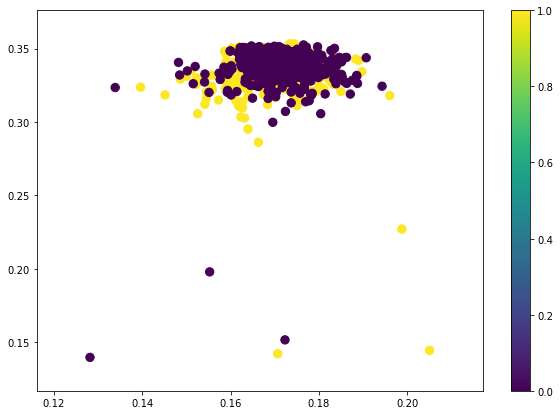

In [110]:
# build a model to project inputs on the latent space


# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_word_scaled_d_minmax[0:768,], batch_size=32)
print x_test_encoded.shape
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_word[0:768,], s = 70)
plt.colorbar()
plt.show()

In [18]:
print x_word_scaled_d_minmax.shape

## Seq to Seq Autoencoder

In [89]:
inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(latent_dim)(inputs)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)

NameError: name 'timesteps' is not defined

## Convolutional Autoencoder

In [6]:
sequence_input = Input(shape=(100, 1))
#sequence_input = np.reshape(sequence_input, (100, 1))
x = Conv1D(32, 5, activation='relu')(sequence_input)
x = MaxPooling1D(3)(x)
x = Conv1D(16, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(16, 3, activation='relu')(x)
encoded = MaxPooling1D(3)(x)

x = Conv1D(16, 2, activation='relu', border_mode = 'same')(encoded)
x = UpSampling1D(5)(x)
x = Conv1D(16, 3, activation='relu', border_mode = 'same')(x)
x = UpSampling1D(5)(x)
x = Conv1D(32, 5, activation='relu', border_mode = 'same')(x)
x = UpSampling1D(2)(x)
decoded = Conv1D(1, 1, activation='linear', border_mode = 'same')(x)

conv_autoen = Model(sequence_input, decoded)

In [7]:
conv_autoen.compile(loss='mse', optimizer='rmsprop')

In [76]:
conv_autoen.summary()

In [8]:
temp = d_df_array_scaled.reshape(d_df_array_scaled.shape + (1,))

In [ ]:
conv_autoen.fit(temp, temp,
                nb_epoch= 10,
                batch_size= 128,
                shuffle=True,
                verbose = True)

In [11]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, 3, 3, activation='relu', border_mode='same')(input_img)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Conv2D(8, 3, 3, activation='relu', border_mode='same')(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Conv2D(8, 3, 3, activation='relu', border_mode='same')(x)
encoded = MaxPooling2D((2, 2), border_mode='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, 3, 3, activation='relu', border_mode='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, 3, 3, activation='relu', border_mode='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, 3, 3, activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, 3, 3, activation='sigmoid', border_mode='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [57]:
autoencoder.summary()

## Wild data

In [6]:
from sklearn.svm import SVC
from sklearn import metrics

svm_classifier = None
svm_classifier = SVC(gamma = 0.01, C = 1.0, kernel = 'rbf', random_state = 1, probability = True)
svm_classifier.fit(temp_word_scaled, y_temp_word)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=1, shrinking=True, tol=0.001,
  verbose=False)

In [7]:
lactobacillus_files = ['NC_021516.faa', 'NC_010609.faa', 'NC_015214.faa', 'NC_015420.faa', 'NC_020827.faa', 
                       'NC_021903.faa', 'NC_011352.faa', 'NC_021515.faa', 'NC_013504.faa', 'NC_008526.faa', 
                       'NC_021181.faa', 'NC_015429.faa', 'NC_020820.faa', 'NC_021495.faa', 'NC_015701.faa', 
                       'NC_021498.faa', 'NC_020825.faa', 'NC_014727.faa', 'NC_017491.faa', 'NC_020824.faa', 
                       'NC_015322.faa', 'NC_020819.faa', 'NC_021503.faa', 'NC_014334.faa', 'NC_021519.faa', 
                       'NC_021226.faa', 'NC_006377.faa', 'NC_017467.faa', 'NC_006814.faa', 'NC_020828.faa', 
                       'NC_021497.faa', 'NC_008498.faa', 'NC_015978.faa', 'NC_021723.faa', 'NC_021228.faa', 
                       'NC_017480.faa', 'NC_021744.faa', 'NC_020822.faa', 'NC_010080.faa', 'NC_008054.faa', 
                       'NC_017469.faa', 'NC_013200.faa', 'NC_021518.faa', 'NC_021520.faa', 'NC_012552.faa', 
                       'NC_015697.faa', 'NC_021225.faa', 'NC_021517.faa', 'NC_015979.faa', 'NC_018641.faa', 
                       'NC_015218.faa', 'NC_007930.faa', 'NC_010610.faa', 'NC_015698.faa', 'NC_006530.faa', 
                       'NC_017476.faa', 'NC_021872.faa', 'NC_021234.faa', 'NC_017475.faa', 'NC_021904.faa', 
                       'NC_015975.faa', 'NC_008497.faa', 'NC_015603.faa', 'NC_018611.faa', 'NC_014724.faa', 
                       'NC_013199.faa', 'NC_015699.faa', 'NC_015213.faa', 'NC_022114.faa', 'NC_021235.faa', 
                       'NC_006376.faa', 'NC_020057.faa', 'NC_007576.faa', 'NC_017474.faa', 'NC_012984.faa', 
                       'NC_021528.faa', 'NC_013198.faa', 'NC_014106.faa', 'NC_017471.faa', 'NC_006529.faa', 
                       'NC_015319.faa', 'NC_017468.faa', 'NC_017470.faa', 'NC_008530.faa', 'NC_015428.faa', 
                       'NC_021514.faa', 'NC_004567.faa', 'NC_021722.faa', 'NC_018528.faa', 'NC_017479.faa', 
                       'NC_016035.faa', 'NC_021496.faa', 'NC_021227.faa', 'NC_017481.faa', 'NC_021504.faa', 
                       'NC_007929.faa', 'NC_014728.faa', 'NC_015602.faa', 'NC_015980.faa', 'NC_017473.faa', 
                       'NC_020821.faa', 'NC_008502.faa', 'NC_020229.faa', 'NC_008529.faa', 'NC_021526.faa', 
                       'NC_013505.faa', 'NC_015700.faa', 'NC_021912.faa', 'NC_017482.faa', 'NC_021527.faa', 
                       'NC_009513.faa', 'NC_016034.faa', 'NC_006375.faa', 'NC_017499.faa', 'NC_022123.faa', 
                       'NC_014558.faa', 'NC_018610.faa', 'NC_021494.faa', 'NC_021525.faa', 'NC_014554.faa', 
                       'NC_017465.faa', 'NC_015421.faa', 'NC_020826.faa', 'NC_021725.faa', 'NC_005362.faa', 
                       'NC_017477.faa', 'NC_015598.faa', 'NC_017472.faa', 'NC_008499.faa', 'NC_022112.faa', 
                       'NC_021233.faa', 'NC_021224.faa', 'NC_021721.faa', 'NC_022909.faa', 'NC_010999.faa', 
                       'NC_020823.faa']

In [8]:
lactobacullus_file_names = []
for a_file in lactobacillus_files:
    tok = a_file.split('.')[0]
    lactobacullus_file_names.append(tok)    

In [16]:
lactobacullus_file_names

['NC_021516',
 'NC_010609',
 'NC_015214',
 'NC_015420',
 'NC_020827',
 'NC_021903',
 'NC_011352',
 'NC_021515',
 'NC_013504',
 'NC_008526',
 'NC_021181',
 'NC_015429',
 'NC_020820',
 'NC_021495',
 'NC_015701',
 'NC_021498',
 'NC_020825',
 'NC_014727',
 'NC_017491',
 'NC_020824',
 'NC_015322',
 'NC_020819',
 'NC_021503',
 'NC_014334',
 'NC_021519',
 'NC_021226',
 'NC_006377',
 'NC_017467',
 'NC_006814',
 'NC_020828',
 'NC_021497',
 'NC_008498',
 'NC_015978',
 'NC_021723',
 'NC_021228',
 'NC_017480',
 'NC_021744',
 'NC_020822',
 'NC_010080',
 'NC_008054',
 'NC_017469',
 'NC_013200',
 'NC_021518',
 'NC_021520',
 'NC_012552',
 'NC_015697',
 'NC_021225',
 'NC_021517',
 'NC_015979',
 'NC_018641',
 'NC_015218',
 'NC_007930',
 'NC_010610',
 'NC_015698',
 'NC_006530',
 'NC_017476',
 'NC_021872',
 'NC_021234',
 'NC_017475',
 'NC_021904',
 'NC_015975',
 'NC_008497',
 'NC_015603',
 'NC_018611',
 'NC_014724',
 'NC_013199',
 'NC_015699',
 'NC_015213',
 'NC_022114',
 'NC_021235',
 'NC_006376',
 'NC_0

In [18]:
os.chdir('/home/nafizh/ML_works/')

target_dir = '/home/nafizh/ML_works/all_gene_blocks'
out_handle = open('temp_word_svm_wild_predictions_lacto_10_fold_0.5', 'w')

for root, subFolders, files in os.walk(target_dir):
    for index_1, gene_block_file in enumerate(files):
        tok = gene_block_file.split('_')[0] + '_' + gene_block_file.split('_')[1]
        if tok in lactobacullus_file_names:
            print gene_block_file
            os.chdir('/home/nafizh/ML_works/all_gene_blocks')
            wild_list = [len(rec) for rec in SeqIO.parse(gene_block_file, "fasta")]
            wild_word = np.zeros(shape=(len(wild_list),100))
            
            for index_2, record in enumerate(SeqIO.parse(gene_block_file, 'fasta')):
                sum_of_sequence = 0
                tri_tokens = trigrams(record.seq)
                for item in ((tri_tokens)):
                    tri_str = item[0] + item[1] + item[2]
                    if tri_str not in list(new_model.wv.vocab):
                        continue
                    #print tri_str
                    #print 
                    sum_of_sequence = sum_of_sequence + new_model[tri_str]
                wild_word[index_2] = sum_of_sequence
            
            
            wild_word_scaled = temp_scaler.transform(wild_word)
            scores = svm_classifier.predict(wild_word_scaled)
            scores_prob = svm_classifier.predict_proba(wild_word_scaled)
            put_tox_index_list = np.array(list(np.where(scores == 1)[0])).tolist()

            tox_greater_nine = []
            for i in put_tox_index_list:
                if scores_prob[i][1] >= 0.5:
                    tox_greater_nine.append(i)
                    
            print tox_greater_nine
            for index_3, record in enumerate(SeqIO.parse(gene_block_file, 'fasta')):
                if index_3 in tox_greater_nine:
                    os.chdir('/home/nafizh/ML_works/')
                    out_handle.write('>%s|%f\n%s\n' % (record.description, scores_prob[index_3][1],
                                                      record.seq))
            
            #break
        
out_handle.close()
print "Done"

In [17]:
os.chdir('/home/nafizh/ML_works/')

target_dir = '/home/nafizh/ML_works/all_gene_blocks'
out_handle = open('temp_word_svm_wild_predictions_lacto_10_fold_0.5_size_200', 'w')

for root, subFolders, files in os.walk(target_dir):
    for index_1, gene_block_file in enumerate(files):
        tok = gene_block_file.split('_')[0] + '_' + gene_block_file.split('_')[1]
        if tok in lactobacullus_file_names:
            print gene_block_file
            os.chdir('/home/nafizh/ML_works/all_gene_blocks')
            wild_list = [len(rec) for rec in SeqIO.parse(gene_block_file, "fasta")]
            wild_word = np.zeros(shape=(len(wild_list),200))
            
            for index_2, record in enumerate(SeqIO.parse(gene_block_file, 'fasta')):
                sum_of_sequence = 0
                tri_tokens = trigrams(record.seq)
                for item in ((tri_tokens)):
                    tri_str = item[0] + item[1] + item[2]
                    if tri_str not in list(new_model.wv.vocab):
                        continue
                    #print tri_str
                    #print 
                    sum_of_sequence = sum_of_sequence + new_model[tri_str]
                wild_word[index_2] = sum_of_sequence
            
            
            wild_word_scaled = temp_scaler.transform(wild_word)
            scores = svm_classifier.predict(wild_word_scaled)
            scores_prob = svm_classifier.predict_proba(wild_word_scaled)
            put_tox_index_list = np.array(list(np.where(scores == 1)[0])).tolist()

            tox_greater_nine = []
            for i in put_tox_index_list:
                if scores_prob[i][1] >= 0.5:
                    tox_greater_nine.append(i)
                    
            print tox_greater_nine
            for index_3, record in enumerate(SeqIO.parse(gene_block_file, 'fasta')):
                if index_3 in tox_greater_nine:
                    os.chdir('/home/nafizh/ML_works/')
                    out_handle.write('>%s|%f\n%s\n' % (record.description, scores_prob[index_3][1],
                                                      record.seq))
            
            #break
        
out_handle.close()
print "Done"

NC_015428_gene_block_prot.fa
[109, 110, 171, 304, 619, 677, 960]
NC_008497_gene_block_prot.fa
[5, 108, 1211, 1223, 1327]
NC_004567_gene_block_prot.fa
[286, 287, 289, 293, 298, 299, 437, 459, 1228, 1551, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1578, 1831]
NC_017477_gene_block_prot.fa
[202, 257, 409, 414, 415, 420, 540, 1100]
NC_009513_gene_block_prot.fa
[33]
NC_008054_gene_block_prot.fa
[7, 367, 386, 760, 811, 820]
NC_010609_gene_block_prot.fa
[]
NC_017474_gene_block_prot.fa
[8, 9, 242, 244, 278, 327, 518, 573, 581, 674, 779, 810, 885, 1075, 1346, 1580, 1699, 1907, 1911, 1919, 2062, 2063, 2077, 2078, 2087, 2232, 2277]
NC_007576_gene_block_prot.fa
[482, 486, 511, 526, 625, 769]
NC_017482_gene_block_prot.fa
[0, 56, 73, 130, 453, 580, 584, 693, 991, 1128, 1399, 1452, 1471, 1702, 1715, 2038]
NC_022909_gene_block_prot.fa
[299, 335, 456, 462, 463, 465, 468, 486, 507, 536, 813]
NC_021744_gene_block_prot.fa
[4, 6, 25, 29, 52, 56, 181, 203, 253, 289, 382, 384, 507, 648, 673, 864, 895, 965]
NC_

In [13]:
"""
Getting SVM predictions for all lactobacillus geneblocks so that we can compare with 
Neural network predictions
"""

os.chdir('/home/nafizh/ML_works/')

target_dir = '/home/nafizh/ML_works/all_gene_blocks'
out_handle = open('temp_word_svm_wild_predictions_lacto_10_fold_all_lactobacillus', 'w')


for index_2, record in enumerate(SeqIO.parse('all_lactobacillus_sequences_from_geneblocks', 'fasta')):
    wild_word = np.zeros(shape=(1, 200))
    sum_of_sequence = 0
    tri_tokens = trigrams(record.seq)
    for item in ((tri_tokens)):
        tri_str = item[0] + item[1] + item[2]
        if tri_str not in list(new_model.wv.vocab):
            continue
        #print tri_str
        #print 
        sum_of_sequence = sum_of_sequence + new_model[tri_str]
    wild_word[0] = sum_of_sequence
            
    #print wild_word.shape        
    wild_word_scaled = temp_scaler.transform(wild_word)
    scores = svm_classifier.predict(wild_word_scaled)
    scores_prob = svm_classifier.predict_proba(wild_word_scaled)
    
    #print scores_prob
    out_handle.write('>%s|%f\n%s\n' % (record.description, scores_prob[0][1],
                                      record.seq))
            
    #break
        
out_handle.close()
print "Done"

Done


In [52]:
all_zeros = np.zeros(shape = (200, ))
print np.all(all_zeros)

In [8]:
from scipy import stats
sss = [3,13,23,33,43,53,63,73,83,93, 103,113,123,133,143,153,163,173,183,193,
                         203,213,223,233,243,253,263,273,283,293, 303,313,323,333,343,353,363,373,383,393,
                          403,413,423,433,443,453,463,473,483,493]

print stats.sem(sss)
print np.mean(sss)

In [16]:
"""
Results from the ultimate RNN model 10x cv done 10 times
"""
from scipy import stats
precision_scores_mean_list = [0.898751842842,0.891150136506,0.911248833481,0.905243109678,0.895588235635,
                              0.875117928979,0.898140918179,0.902187168638,0.902643065998,0.902696600721]
recall_scores_mean_list = [0.881764705882,0.878655462185,0.861092436975,0.875630252101,0.889915966387,
                          0.887647058824,0.901680672269,0.887142857143,0.887478991597,0.884621848739]
f1_scores_mean_list = [0.889239344052,0.882952702948,0.884190526316,0.88864776516,0.893829024989,
                      0.880050504007,0.898368969946,0.893173768549,0.894079475712,0.891009544529]

print (np.mean(precision_scores_mean_list), stats.sem(precision_scores_mean_list))
print (np.mean(recall_scores_mean_list), stats.sem(recall_scores_mean_list))
print (np.mean(f1_scores_mean_list), stats.sem(f1_scores_mean_list))

(0.89827678406570011, 0.0031006955683146151)
(0.88356302521020003, 0.0033495170064204707)
(0.88955416262079989, 0.0018112656009684621)


In [15]:
print 'hello'

hello


In [50]:
for i in range(0, 10):
    print (i)

0
1
2
3
4
5
6
7
8
9


In [72]:
a = np.array([30, 50])
b = np.array([20, 30])
c = np.add(a,b)
print (a,b)
print (b)
print (c)
print (c/2)

(array([30, 50]), array([20, 30]))
[20 30]
[50 80]
[25 40]


## Matplotlib

In [9]:
def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in xrange(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in xrange(layer_size_a):
            for o in xrange(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

def label(ax, x, y, text, label_size=30, **kwargs):          
    plt.text(x, y, text, {'size': label_size},
             va='center', ha='center', zorder=10, **kwargs)

def heaviside(ax, left, right, bottom, top):
    middle = left + (right - left)/2.
    for x, y in zip([[left, middle], [middle, middle], [middle, right]], 
                    [[bottom, bottom], [bottom, top], [top, top]]):
        line = plt.Line2D(x, y, c='k', lw=2, zorder=10)
        ax.add_artist(line)

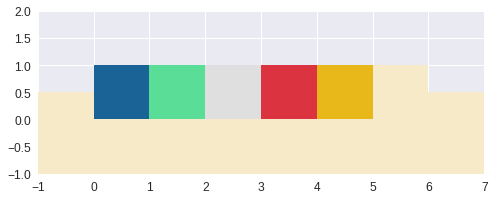

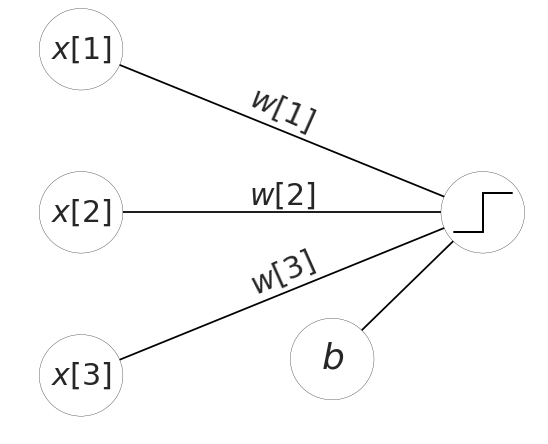

In [10]:
# Testing colors
BLUE = '#1a6396'
GREEN = '#59dd97'
ORANGE = '#E8B71A'
GREY = '#DFDFDF'
RED = '#DB3340'
TAN = '#F7EAC8'
FIGSIZE = (9, 6)
FIGSIZE_FLAT = (9, 2)
plt.figure(figsize=(8, 3))
plt.gca().add_patch(plt.Rectangle((-1, -1), 8, 1.5, fc=TAN, lw=0))
plt.gca().add_patch(plt.Rectangle((0, 0), 1, 1, fc=BLUE, lw=0))
plt.gca().add_patch(plt.Rectangle((1, 0), 1, 1, fc=GREEN, lw=0))
plt.gca().add_patch(plt.Rectangle((2, 0), 1, 1, fc=GREY, lw=0))
plt.gca().add_patch(plt.Rectangle((3, 0), 1, 1, fc=RED, lw=0))
plt.gca().add_patch(plt.Rectangle((4, 0), 1, 1, fc=ORANGE, lw=0))
plt.gca().add_patch(plt.Rectangle((5, 0), 1, 1, fc=TAN, lw=0))
plt.gca().add_patch(plt.Rectangle((5, 0), 1, 1, fc=TAN, lw=0))
plt.xlim([-1, 7])
plt.ylim([-1, 2])
plt.figure(figsize=(FIGSIZE[0], (1 - .16)*FIGSIZE[0]))
ax = plt.gca()
draw_neural_net(ax, .1, .9, .0, 1., [3, 1])

label(ax, .1, .83333, '$x[1]$')
label(ax, .1, .5, '$x[2]$')
label(ax, .1, .16666, '$x[3]$')

label(ax, .5, .71, '$w[1]$', rotation=-24)
label(ax, .5, .535, '$w[2]$')
label(ax, .5, .375, '$w[3]$', rotation=24)

b_coords = (.6, .2)
circle = plt.Circle(b_coords, 1./3./4.,
                    color='w', ec='k', zorder=4)
plt.gca().add_artist(circle)
label(ax, b_coords[0], b_coords[1], '$b$', 36)
line = plt.Line2D([b_coords[0], .9], [b_coords[1], .5], c='k')
ax.add_artist(line)

heaviside(ax, .842, .958, .46, .54)

plt.ylim([.08, .92])
plt.axis('off')
plt.savefig('2-perceptron.pdf', bbox_inches='tight', pad_inches=0.1)